In [1]:
import json, os
import cv2
import torch
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.akpd_scorer import AKPDNormalizationTransform, AKPDScorerNetwork
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# extract sample dataset
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_SQL_CREDENTIALS'])))

query = """
    select * from keypoint_annotations 
    where pen_id=61 
    and captured_at between '2019-09-13' and '2019-09-21'
    and keypoints is not null;
"""

df = rds_access_utils.extract_from_database(query)

aws_credentials = json.load(open(os.environ['AWS_CREDENTIALS']))
akpd = AKPD(aws_credentials)

# initialize data transforms so that we can run inference with AKPD scorer network
normalize_centered_2D_transform_akpd = NormalizeCentered2D(rotate=False, center=True)
akpd_normalization_transform = AKPDNormalizationTransform()
to_tensor_transform = ToTensor()

# initialize data transforms so that we can run inference with biomass neural network
normalize_centered_2D_transform_biomass = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()

# load neural network weights
biomass_network = torch.load('/root/data/alok/biomass_estimation/results/neural_network/2019-11-08T00:13:09/nn_epoch_798.pb')
akpd_scorer_network = torch.load('/root/data/alok/biomass_estimation/playground/akpd_scorer_model.pb')

In [40]:
# confidence_scores, weight_predictions = [], []
for idx, row in df.iterrows():
    if idx < 7126:
        continue
    if idx % 100 == 0:
        print(idx)
        print(len(confidence_scores))

    # run AKPD
    left_crop_url, right_crop_url = row.left_image_url, row.right_image_url
    left_crop_metadata, right_crop_metadata = row.left_crop_metadata, row.right_crop_metadata
    cm = row.camera_metadata
    akpd_keypoints = akpd.predict_keypoints(left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata)

    # run template matching
#     left_image_f, _, _ = s3_access_utils.download_from_url(left_crop_url)
#     right_image_f, _, _ = s3_access_utils.download_from_url(right_crop_url)
#     imageL = cv2.imread(left_image_f)
#     imageR = cv2.imread(right_image_f)
#     H, kps = find_matches_and_homography(imageL, imageR, cm, left_crop_metadata, right_crop_metadata)

    # run AKPD scoring network
    input_sample = {
        'keypoints': akpd_keypoints[0],
        'cm': row.camera_metadata,
        'stereo_pair_id': row.id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform_akpd.__call__(input_sample)

    akpd_normalized_kps = akpd_normalization_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(akpd_normalized_kps)
    confidence_score = akpd_scorer_network(tensorized_kps['kp_input']).item()
    print(confidence_score)
    

    # run biomass estimation
    input_sample = {
        'keypoints': akpd_keypoints[0],
        'cm': row.camera_metadata,
        'stereo_pair_id': row.id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform_biomass.__call__(input_sample)

    normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(normalized_stability_kps)
    weight_prediction = biomass_network(tensorized_kps['kp_input']).item() * 1e4
    print(weight_prediction)
    
    confidence_scores.append(confidence_score)
    weight_predictions.append(weight_prediction)

{'ADIPOSE_FIN': [-0.0943603515625, -0.0618896484375, -0.1722412109375, -0.0609130859375], 'ANAL_FIN': [-0.0572509765625, 0.0045166015625, -0.1392822265625, 0.0042724609375], 'DORSAL_FIN': [0.0172119140625, -0.0633544921875, -0.0738525390625, -0.0638427734375], 'EYE': [0.1129150390625, 0.0447998046875, 0.0028076171875, 0.0433349609375], 'PECTORAL_FIN': [0.0758056640625, 0.0633544921875, -0.0272216796875, 0.0633544921875], 'PELVIC_FIN': [-0.0015869140625, 0.0323486328125, -0.0902099609375, 0.0323486328125], 'TAIL_NOTCH': [-0.1654052734375, -0.0262451171875, -0.2379150390625, -0.0296630859375], 'UPPER_LIP': [0.1654052734375, 0.0540771484375, 0.0521240234375, 0.0511474609375]}
0.9337146282196045
2171.1352467536926
{'ADIPOSE_FIN': [-0.1552734375, -0.0009765625, 0.0185546875, 0.015869140625], 'ANAL_FIN': [-0.11083984375, 0.063232421875, -0.18896484375, 0.06298828125], 'DORSAL_FIN': [-0.022216796875, -0.0634765625, -0.108154296875, -0.064697265625], 'EYE': [0.158935546875, -0.036376953125, 0.

{'ADIPOSE_FIN': [-0.1177978515625, 0.0, -0.2366943359375, -0.000244140625], 'ANAL_FIN': [-0.0743408203125, 0.057373046875, -0.1839599609375, 0.05712890625], 'DORSAL_FIN': [0.0611572265625, -0.110107421875, -0.0496826171875, -0.110107421875], 'EYE': [0.2359619140625, -0.0849609375, 0.1322021484375, -0.086181640625], 'PECTORAL_FIN': [0.1878662109375, -0.041259765625, 0.0843505859375, -0.040771484375], 'PELVIC_FIN': [0.0350341796875, 0.0205078125, -0.0689697265625, 0.021240234375], 'TAIL_NOTCH': [-0.2576904296875, 0.110107421875, -0.3804931640625, 0.10986328125], 'UPPER_LIP': [0.2576904296875, -0.100830078125, 0.1610107421875, -0.1005859375]}
0.9540711045265198
1958.4567844867706
{'ADIPOSE_FIN': [-0.11865234375, -0.0279541015625, -0.206298828125, -0.0281982421875], 'ANAL_FIN': [-0.08984375, 0.0369873046875, -0.177001953125, 0.0369873046875], 'DORSAL_FIN': [0.05322265625, -0.0538330078125, -0.038330078125, -0.0550537109375], 'EYE': [0.21630859375, 0.0032958984375, 0.125732421875, 0.0025634

{'ADIPOSE_FIN': [-0.0423583984375, -0.0145263671875, -0.1268310546875, -0.0145263671875], 'ANAL_FIN': [-0.0303955078125, 0.0535888671875, -0.1134033203125, 0.0533447265625], 'DORSAL_FIN': [0.0494384765625, -0.0535888671875, -0.0272216796875, -0.0533447265625], 'EYE': [0.1343994140625, -0.0130615234375, 0.0645751953125, -0.0133056640625], 'PECTORAL_FIN': [0.1077880859375, 0.0169677734375, 0.0350341796875, 0.0157470703125], 'PELVIC_FIN': [0.0255126953125, 0.0511474609375, -0.0513916015625, 0.0509033203125], 'TAIL_NOTCH': [-0.1392822265625, 0.0311279296875, -0.2320556640625, 0.0294189453125], 'UPPER_LIP': [0.1392822265625, -0.0169677734375, 0.0726318359375, -0.0184326171875]}
0.9518415331840515
2453.714907169342
{'ADIPOSE_FIN': [-0.1090087890625, 0.011474609375, -0.1986083984375, 0.010986328125], 'ANAL_FIN': [-0.0745849609375, 0.065673828125, -0.1617431640625, 0.064697265625], 'DORSAL_FIN': [0.0172119140625, -0.037353515625, -0.0697021484375, -0.038818359375], 'EYE': [0.1492919921875, -0.

{'ADIPOSE_FIN': [-0.0762939453125, -0.0086669921875, -0.1729736328125, -0.0086669921875], 'ANAL_FIN': [-0.0328369140625, 0.0528564453125, -0.1258544921875, 0.0535888671875], 'DORSAL_FIN': [0.0762939453125, -0.0589599609375, -0.0135498046875, -0.0592041015625], 'EYE': [0.1890869140625, -0.0220947265625, 0.1094970703125, -0.0206298828125], 'PECTORAL_FIN': [0.1561279296875, 0.0113525390625, 0.0770263671875, 0.0118408203125], 'PELVIC_FIN': [0.0582275390625, 0.0435791015625, -0.0281982421875, 0.0445556640625], 'TAIL_NOTCH': [-0.1998291015625, 0.0589599609375, -0.2962646484375, 0.0758056640625], 'UPPER_LIP': [0.1998291015625, -0.0238037109375, 0.1241455078125, -0.0235595703125]}
0.8727636337280273
2063.729166984558
{'ADIPOSE_FIN': [-0.1114501953125, -0.051025390625, -0.1837158203125, -0.05224609375], 'ANAL_FIN': [-0.0880126953125, 0.017578125, 0.0582275390625, 0.0244140625], 'DORSAL_FIN': [-0.0469970703125, -0.05810546875, -0.1253662109375, -0.056396484375], 'EYE': [0.1029052734375, 0.031494

{'ADIPOSE_FIN': [-0.130859375, -0.0064697265625, -0.199462890625, -0.0067138671875], 'ANAL_FIN': [-0.082275390625, 0.0474853515625, -0.152587890625, 0.0482177734375], 'DORSAL_FIN': [0.01123046875, -0.0545654296875, -0.05859375, -0.0528564453125], 'EYE': [0.164794921875, 0.0067138671875, 0.078369140625, 0.0059814453125], 'PECTORAL_FIN': [0.119873046875, 0.0438232421875, 0.03515625, 0.0433349609375], 'PELVIC_FIN': [0.00390625, 0.0511474609375, -0.069580078125, 0.0509033203125], 'TAIL_NOTCH': [-0.21337890625, 0.0545654296875, -0.2861328125, 0.0496826171875], 'UPPER_LIP': [0.21337890625, 0.0006103515625, 0.121826171875, 0.0008544921875]}
0.9521079659461975
3585.2476954460144
{'ADIPOSE_FIN': [-0.2198486328125, -0.0093994140625, -0.3221435546875, -0.0098876953125], 'ANAL_FIN': [-0.1629638671875, 0.0733642578125, -0.2593994140625, 0.0740966796875], 'DORSAL_FIN': [0.0076904296875, -0.0762939453125, -0.1024169921875, -0.0765380859375], 'EYE': [0.2457275390625, -0.0108642578125, 0.1275634765625,

{'ADIPOSE_FIN': [-0.1231689453125, 0.0135498046875, -0.2008056640625, 0.0128173828125], 'ANAL_FIN': [-0.0755615234375, 0.0526123046875, -0.1534423828125, 0.0518798828125], 'DORSAL_FIN': [0.0279541015625, -0.0655517578125, -0.0511474609375, -0.0667724609375], 'EYE': [0.1871337890625, -0.0491943359375, 0.1065673828125, -0.0489501953125], 'PECTORAL_FIN': [0.1431884765625, -0.0120849609375, 0.0631103515625, -0.0115966796875], 'PELVIC_FIN': [0.0159912109375, 0.0330810546875, -0.0628662109375, 0.0323486328125], 'TAIL_NOTCH': [-0.2186279296875, 0.0655517578125, -0.2991943359375, 0.0648193359375], 'UPPER_LIP': [0.2186279296875, -0.0635986328125, 0.1341552734375, -0.0635986328125]}
0.8925151228904724
2241.8907284736633
{'ADIPOSE_FIN': [-0.1058349609375, -0.0341796875, -0.1964111328125, -0.034423828125], 'ANAL_FIN': [-0.0755615234375, 0.0341796875, -0.1619873046875, 0.0341796875], 'DORSAL_FIN': [0.0211181640625, -0.056396484375, -0.0723876953125, -0.054931640625], 'EYE': [0.1270751953125, 0.0275

{'ADIPOSE_FIN': [-0.1002197265625, -0.036865234375, -0.1834716796875, -0.03564453125], 'ANAL_FIN': [-0.0633544921875, 0.038330078125, -0.1456298828125, 0.039306640625], 'DORSAL_FIN': [-0.0941162109375, -0.038330078125, -0.1810302734375, -0.038330078125], 'EYE': [0.0972900390625, -0.009765625, -0.0152587890625, -0.010498046875], 'PECTORAL_FIN': [0.0540771484375, 0.036865234375, -0.0533447265625, 0.03662109375], 'PELVIC_FIN': [0.0570068359375, 0.036865234375, 0.0362548828125, -0.021728515625], 'TAIL_NOTCH': [-0.1497802734375, 0.014892578125, -0.2218017578125, 0.015869140625], 'UPPER_LIP': [0.1497802734375, -0.019287109375, 0.0362548828125, -0.018798828125]}
2.251146743027e-22
5935.423970222473
{'ADIPOSE_FIN': [-0.1036376953125, -0.0576171875, -0.1722412109375, -0.05615234375], 'ANAL_FIN': [-0.0811767578125, 0.01904296875, -0.1534423828125, 0.01806640625], 'DORSAL_FIN': [0.0811767578125, -0.043701171875, -0.1497802734375, 0.02099609375], 'EYE': [0.1995849609375, 0.033203125, 0.12951660156

{'ADIPOSE_FIN': [-0.12646484375, -0.068115234375, -0.211181640625, -0.06884765625], 'ANAL_FIN': [-0.0849609375, 0.0, -0.16748046875, 0.0], 'DORSAL_FIN': [0.014404296875, -0.064697265625, -0.075927734375, -0.063720703125], 'EYE': [0.1845703125, 0.0419921875, 0.079833984375, 0.041015625], 'PECTORAL_FIN': [0.130615234375, 0.068115234375, 0.031982421875, 0.066650390625], 'PELVIC_FIN': [0.001953125, 0.043701171875, -0.087646484375, 0.04443359375], 'TAIL_NOTCH': [-0.234375, -0.03857421875, -0.31494140625, -0.034423828125], 'UPPER_LIP': [0.234375, 0.033203125, 0.131591796875, 0.0341796875]}
0.9328901767730713
2973.226308822632
{'ADIPOSE_FIN': [-0.10693359375, -0.0030517578125, -0.189453125, -0.0032958984375], 'ANAL_FIN': [-0.058349609375, 0.0621337890625, -0.14111328125, 0.0631103515625], 'DORSAL_FIN': [0.006591796875, -0.0684814453125, -0.092529296875, -0.0697021484375], 'EYE': [0.126708984375, -0.0081787109375, 0.0078125, -0.0086669921875], 'PECTORAL_FIN': [0.181884765625, -0.0162353515625,

{'ADIPOSE_FIN': [-0.1507568359375, -0.028564453125, -0.2462158203125, -0.030029296875], 'ANAL_FIN': [-0.0985107421875, 0.036865234375, -0.1966552734375, 0.03662109375], 'DORSAL_FIN': [-0.0062255859375, -0.06689453125, -0.1256103515625, -0.0673828125], 'EYE': [0.1710205078125, 0.03271484375, 0.0338134765625, 0.0322265625], 'PECTORAL_FIN': [0.1146240234375, 0.06689453125, -0.0194091796875, 0.06689453125], 'PELVIC_FIN': [-0.0101318359375, 0.057373046875, -0.1221923828125, 0.057373046875], 'TAIL_NOTCH': [-0.2393798828125, 0.033935546875, -0.3314208984375, 0.0322265625], 'UPPER_LIP': [0.2393798828125, 0.031494140625, 0.0943603515625, 0.032470703125]}
0.953295886516571
2001.158595085144
{'ADIPOSE_FIN': [-0.1759033203125, -0.022705078125, -0.2950439453125, -0.02294921875], 'ANAL_FIN': [-0.1143798828125, 0.068359375, -0.2330322265625, 0.06884765625], 'DORSAL_FIN': [-0.0352783203125, -0.08154296875, -0.1824951171875, -0.080078125], 'EYE': [0.1627197265625, 0.0244140625, -0.0196533203125, 0.0244

{'ADIPOSE_FIN': [-0.185302734375, -0.0234375, -0.2646484375, -0.02392578125], 'ANAL_FIN': [-0.139404296875, 0.048828125, -0.310302734375, 0.0224609375], 'DORSAL_FIN': [-0.056396484375, -0.06884765625, -0.15087890625, -0.069091796875], 'EYE': [0.147705078125, -0.010009765625, 0.039306640625, -0.00927734375], 'PECTORAL_FIN': [0.08544921875, 0.040771484375, -0.017822265625, 0.039794921875], 'PELVIC_FIN': [-0.064697265625, 0.06884765625, -0.154541015625, 0.06787109375], 'TAIL_NOTCH': [-0.21435546875, 0.011474609375, -0.310302734375, 0.025146484375], 'UPPER_LIP': [0.21435546875, -0.02490234375, 0.103759765625, -0.02392578125]}
1.0281165486958344e-05
2564.086616039276
{'ADIPOSE_FIN': [-0.2242431640625, 0.01171875, -0.3507080078125, 0.011962890625], 'ANAL_FIN': [-0.1475830078125, 0.08740234375, -0.2769775390625, 0.088134765625], 'DORSAL_FIN': [0.0054931640625, -0.07568359375, -0.1351318359375, -0.076416015625], 'EYE': [0.2625732421875, -0.061767578125, 0.1170654296875, -0.062255859375], 'PECT

{'ADIPOSE_FIN': [-0.1514892578125, -0.0301513671875, -0.2427978515625, -0.0308837890625], 'ANAL_FIN': [-0.1151123046875, 0.0469970703125, -0.2010498046875, 0.0467529296875], 'DORSAL_FIN': [0.0474853515625, -0.0635986328125, -0.0440673828125, -0.0635986328125], 'EYE': [0.2371826171875, -0.0091552734375, 0.1453857421875, -0.0098876953125], 'PECTORAL_FIN': [0.1829833984375, 0.0364990234375, 0.0899658203125, 0.0362548828125], 'PELVIC_FIN': [0.0023193359375, 0.0635986328125, -0.0855712890625, 0.0631103515625], 'TAIL_NOTCH': [-0.2689208984375, -0.0179443359375, -0.3536376953125, -0.0101318359375], 'UPPER_LIP': [0.2689208984375, -0.0211181640625, 0.1776123046875, -0.0203857421875]}
0.9430882930755615
3271.7645168304443
{'ADIPOSE_FIN': [-0.140625, -0.0093994140625, -0.241455078125, -0.0096435546875], 'ANAL_FIN': [-0.085205078125, 0.0701904296875, -0.189453125, 0.0704345703125], 'DORSAL_FIN': [0.004150390625, -0.0838623046875, -0.122314453125, -0.0845947265625], 'EYE': [0.16162109375, 0.0028076

{'ADIPOSE_FIN': [-0.0726318359375, -0.05224609375, -0.1651611328125, -0.052978515625], 'ANAL_FIN': [-0.0465087890625, 0.01171875, -0.1361083984375, 0.011962890625], 'DORSAL_FIN': [0.0318603515625, -0.06005859375, -0.0596923828125, -0.0556640625], 'EYE': [-0.1510009765625, -0.03515625, -0.0093994140625, 0.043212890625], 'PECTORAL_FIN': [0.0784912109375, 0.06005859375, -0.0303955078125, 0.061279296875], 'PELVIC_FIN': [0.0145263671875, 0.033447265625, -0.0831298828125, 0.033203125], 'TAIL_NOTCH': [-0.1451416015625, -0.0380859375, -0.2313232421875, -0.035888671875], 'UPPER_LIP': [0.1510009765625, 0.05078125, 0.0328369140625, 0.06005859375]}
9.256123589487104e-21
6921.404600143433
{'ADIPOSE_FIN': [-0.124755859375, -0.0096435546875, -0.197509765625, -0.0103759765625], 'ANAL_FIN': [-0.082275390625, 0.0408935546875, -0.155517578125, 0.0406494140625], 'DORSAL_FIN': [0.0, -0.0477294921875, -0.077392578125, -0.0484619140625], 'EYE': [0.142822265625, -0.0006103515625, 0.057861328125, -0.0008544921

{'ADIPOSE_FIN': [-0.1563720703125, -0.024658203125, -0.2642822265625, -0.025146484375], 'ANAL_FIN': [-0.0904541015625, 0.057861328125, -0.1968994140625, 0.0576171875], 'DORSAL_FIN': [-0.0064697265625, -0.084228515625, -0.1409912109375, -0.085205078125], 'EYE': [0.1697998046875, 0.0439453125, 0.0096435546875, 0.04345703125], 'PECTORAL_FIN': [0.1212158203125, 0.084228515625, -0.0260009765625, 0.0859375], 'PELVIC_FIN': [0.0023193359375, 0.078857421875, -0.1134033203125, 0.07861328125], 'TAIL_NOTCH': [-0.2447509765625, 0.042236328125, -0.3397216796875, 0.048583984375], 'UPPER_LIP': [0.2447509765625, 0.03857421875, 0.0811767578125, 0.036376953125]}
0.7634704113006592
2928.0251264572144
{'ADIPOSE_FIN': [-0.1258544921875, 0.0009765625, -0.2115478515625, 0.000732421875], 'ANAL_FIN': [-0.0821533203125, 0.059814453125, -0.1683349609375, 0.059814453125], 'DORSAL_FIN': [0.0201416015625, -0.06640625, -0.0819091796875, -0.068115234375], 'EYE': [0.1697998046875, -0.036865234375, 0.0548095703125, -0.0

{'ADIPOSE_FIN': [-0.1328125, -0.011962890625, -0.22705078125, -0.011962890625], 'ANAL_FIN': [-0.093505859375, 0.03857421875, -0.26171875, 0.00830078125], 'DORSAL_FIN': [0.001708984375, -0.04150390625, -0.092041015625, -0.04150390625], 'EYE': [0.145751953125, -0.0009765625, 0.049072265625, -0.001220703125], 'PECTORAL_FIN': [0.103271484375, 0.029296875, 0.00830078125, 0.029541015625], 'PELVIC_FIN': [-0.011474609375, 0.04150390625, -0.1015625, 0.041015625], 'TAIL_NOTCH': [-0.181884765625, 0.007080078125, -0.264892578125, 0.011474609375], 'UPPER_LIP': [0.181884765625, -0.007080078125, 0.083740234375, -0.007568359375]}
9.251265282728127e-07
1152.3058265447617
{'ADIPOSE_FIN': [-0.0987548828125, -0.013427734375, -0.1827392578125, -0.01220703125], 'ANAL_FIN': [-0.0723876953125, 0.033447265625, -0.1536865234375, 0.033447265625], 'DORSAL_FIN': [0.0196533203125, -0.0361328125, -0.0599365234375, -0.0361328125], 'EYE': [0.1348876953125, -0.012451171875, 0.1019287109375, -0.0244140625], 'PECTORAL_FI

{'ADIPOSE_FIN': [-0.1361083984375, -0.012939453125, -0.2017822265625, -0.013671875], 'ANAL_FIN': [-0.1092529296875, 0.0380859375, -0.1710205078125, 0.03759765625], 'DORSAL_FIN': [0.0015869140625, -0.0419921875, -0.0718994140625, -0.04248046875], 'EYE': [0.1153564453125, 0.00244140625, 0.0521240234375, 0.00146484375], 'PECTORAL_FIN': [0.0762939453125, 0.025634765625, 0.0147705078125, 0.027587890625], 'PELVIC_FIN': [-0.0313720703125, 0.0419921875, -0.0965576171875, 0.04248046875], 'TAIL_NOTCH': [-0.1361083984375, -0.01416015625, -0.2886962890625, 0.0224609375], 'UPPER_LIP': [0.1361083984375, -0.00048828125, 0.0738525390625, -0.00341796875]}
0.00011911032197531313
2814.6183490753174
{'ADIPOSE_FIN': [-0.1414794921875, 0.0264892578125, -0.2244873046875, 0.0277099609375], 'ANAL_FIN': [0.2205810546875, -0.1019287109375, -0.1624755859375, 0.0697021484375], 'DORSAL_FIN': [-0.2205810546875, 0.0958251953125, -0.2943115234375, 0.1016845703125], 'EYE': [0.1746826171875, -0.0794677734375, 0.07800292

{'ADIPOSE_FIN': [-0.106689453125, 0.0072021484375, -0.2138671875, 0.0052490234375], 'ANAL_FIN': [-0.044677734375, 0.0782470703125, -0.150390625, 0.0780029296875], 'DORSAL_FIN': [0.08740234375, -0.0782470703125, -0.019775390625, -0.0780029296875], 'EYE': [0.215576171875, -0.0655517578125, 0.114990234375, -0.0675048828125], 'PECTORAL_FIN': [0.1962890625, -0.0198974609375, 0.094970703125, -0.0194091796875], 'PELVIC_FIN': [0.07568359375, 0.0618896484375, -0.02783203125, 0.0618896484375], 'TAIL_NOTCH': [-0.215576171875, 0.0599365234375, -0.312744140625, 0.0567626953125], 'UPPER_LIP': [0.215576171875, -0.0672607421875, 0.122802734375, -0.0762939453125]}
0.810764491558075
2181.5216541290283
{'ADIPOSE_FIN': [-0.1666259765625, -0.0166015625, -0.2913818359375, -0.0146484375], 'ANAL_FIN': [-0.1043701171875, 0.046142578125, -0.2232666015625, 0.046875], 'DORSAL_FIN': [0.0467529296875, -0.117919921875, -0.0709228515625, -0.119140625], 'EYE': [0.2655029296875, -0.061767578125, 0.1497802734375, -0.062

{'ADIPOSE_FIN': [-0.171142578125, -0.012939453125, -0.26171875, -0.013671875], 'ANAL_FIN': [-0.127685546875, 0.065185546875, -0.218505859375, 0.065185546875], 'DORSAL_FIN': [-0.025390625, -0.07470703125, -0.129150390625, -0.074462890625], 'EYE': [0.1669921875, -0.011474609375, 0.05029296875, -0.010986328125], 'PECTORAL_FIN': [0.108154296875, 0.04052734375, -0.003662109375, 0.039794921875], 'PELVIC_FIN': [-0.041259765625, 0.07470703125, -0.13623046875, 0.07373046875], 'TAIL_NOTCH': [-0.22607421875, 0.0322265625, -0.308349609375, 0.037109375], 'UPPER_LIP': [0.22607421875, -0.01708984375, 0.107666015625, -0.01806640625]}
0.9576104283332825
3082.294464111328
{'ADIPOSE_FIN': [-0.1458740234375, -0.055908203125, -0.2344970703125, -0.05615234375], 'ANAL_FIN': [-0.0994873046875, 0.0087890625, -0.1737060546875, 0.0146484375], 'DORSAL_FIN': [0.0103759765625, -0.055908203125, -0.0867919921875, -0.056396484375], 'EYE': [0.1922607421875, 0.01953125, 0.0994873046875, 0.02001953125], 'PECTORAL_FIN': [

{'ADIPOSE_FIN': [0.046630859375, -0.07861328125, -0.03369140625, -0.078125], 'ANAL_FIN': [-0.017822265625, 0.07861328125, -0.129150390625, 0.07958984375], 'DORSAL_FIN': [-0.0087890625, -0.069091796875, -0.10595703125, -0.06689453125], 'EYE': [-0.04443359375, 0.061279296875, -0.159423828125, 0.0625], 'PECTORAL_FIN': [-0.022216796875, 0.07861328125, -0.129150390625, 0.07958984375], 'PELVIC_FIN': [0.009033203125, 0.042236328125, -0.0849609375, 0.03955078125], 'TAIL_NOTCH': [0.09326171875, -0.0537109375, -0.2060546875, 0.07373046875], 'UPPER_LIP': [-0.09326171875, 0.072998046875, -0.2060546875, 0.073974609375]}
7.142712562560474e-27
2961.2532258033752
{'ADIPOSE_FIN': [-0.15576171875, 0.0037841796875, -0.251708984375, 0.0045166015625], 'ANAL_FIN': [-0.099609375, 0.0704345703125, -0.1962890625, 0.0697021484375], 'DORSAL_FIN': [0.02392578125, -0.0704345703125, -0.07763671875, -0.0711669921875], 'EYE': [0.20361328125, -0.0357666015625, 0.108154296875, -0.0364990234375], 'PECTORAL_FIN': [0.1557

{'ADIPOSE_FIN': [-0.1043701171875, -0.0521240234375, -0.1851806640625, -0.0521240234375], 'ANAL_FIN': [0.0626220703125, 0.0521240234375, -0.1534423828125, 0.0069580078125], 'DORSAL_FIN': [-0.0208740234375, -0.0484619140625, -0.1134033203125, -0.0479736328125], 'EYE': [0.1070556640625, 0.0303955078125, 0.0032958984375, 0.0289306640625], 'PECTORAL_FIN': [0.0513916015625, 0.0445556640625, -0.0311279296875, 0.0521240234375], 'PELVIC_FIN': [-0.0321044921875, 0.0343017578125, -0.1187744140625, 0.0343017578125], 'TAIL_NOTCH': [-0.1600341796875, -0.0242919921875, -0.2330322265625, -0.0274658203125], 'UPPER_LIP': [0.1600341796875, 0.0255126953125, 0.0538330078125, 0.0233154296875]}
3.548272854464636e-14
1486.3857626914978
{'ADIPOSE_FIN': [-0.1546630859375, -0.0008544921875, -0.2569580078125, -0.0006103515625], 'ANAL_FIN': [-0.0848388671875, 0.0904541015625, -0.1890869140625, 0.0904541015625], 'DORSAL_FIN': [-0.0240478515625, -0.0989990234375, -0.1534423828125, -0.1002197265625], 'EYE': [0.14562

{'ADIPOSE_FIN': [-0.1302490234375, 0.001953125, -0.2332763671875, 0.001220703125], 'ANAL_FIN': [-0.2091064453125, 0.07861328125, -0.3006591796875, 0.077880859375], 'DORSAL_FIN': [-0.0157470703125, -0.08251953125, -0.1456298828125, -0.082763671875], 'EYE': [0.1341552734375, -0.040283203125, -0.0242919921875, -0.041748046875], 'PECTORAL_FIN': [0.0828857421875, 0.02099609375, -0.0579833984375, 0.02001953125], 'PELVIC_FIN': [-0.0198974609375, 0.063232421875, -0.1387939453125, 0.062744140625], 'TAIL_NOTCH': [-0.2054443359375, 0.08251953125, -0.3006591796875, 0.079833984375], 'UPPER_LIP': [0.2091064453125, -0.0576171875, 0.0465087890625, -0.060302734375]}
1.6331381402778788e-07
1596.2477028369904
{'ADIPOSE_FIN': [-0.125732421875, 0.0029296875, -0.21142578125, 0.002685546875], 'ANAL_FIN': [-0.0810546875, 0.0615234375, -0.163330078125, 0.0615234375], 'DORSAL_FIN': [0.044677734375, -0.0615234375, -0.046875, -0.060546875], 'EYE': [0.20263671875, -0.032958984375, 0.117919921875, -0.0341796875], '

{'ADIPOSE_FIN': [-0.0938720703125, -0.004638671875, -0.1673583984375, -0.004150390625], 'ANAL_FIN': [-0.0567626953125, 0.051513671875, -0.1280517578125, 0.05078125], 'DORSAL_FIN': [0.0416259765625, -0.051513671875, -0.0294189453125, -0.05126953125], 'EYE': [0.1646728515625, -0.022216796875, 0.0982666015625, -0.022216796875], 'PECTORAL_FIN': [0.1368408203125, 0.007080078125, 0.0687255859375, 0.00732421875], 'PELVIC_FIN': [0.0291748046875, 0.04443359375, -0.0428466796875, 0.04443359375], 'TAIL_NOTCH': [-0.1800537109375, 0.041015625, -0.2491455078125, 0.041748046875], 'UPPER_LIP': [0.1800537109375, -0.02685546875, 0.1146240234375, -0.02587890625]}
0.944293737411499
2594.9281454086304
{'ADIPOSE_FIN': [-0.089599609375, -0.00634765625, -0.16357421875, -0.006103515625], 'ANAL_FIN': [-0.052490234375, 0.044189453125, -0.12744140625, 0.044189453125], 'DORSAL_FIN': [0.0400390625, -0.044189453125, -0.0419921875, -0.041015625], 'EYE': [0.157470703125, -0.018310546875, 0.08642578125, -0.019287109375

{'ADIPOSE_FIN': [-0.1158447265625, -0.0006103515625, -0.1837158203125, -0.0006103515625], 'ANAL_FIN': [-0.0723876953125, 0.0560302734375, -0.1407470703125, 0.0565185546875], 'DORSAL_FIN': [0.0252685546875, -0.0587158203125, -0.0516357421875, -0.0589599609375], 'EYE': [0.1627197265625, -0.0172119140625, 0.0838623046875, -0.0172119140625], 'PECTORAL_FIN': [0.1229248046875, 0.0213623046875, 0.0447998046875, 0.0203857421875], 'PELVIC_FIN': [0.0072021484375, 0.0504150390625, -0.0623779296875, 0.0509033203125], 'TAIL_NOTCH': [-0.2027587890625, 0.0587158203125, -0.2657470703125, 0.0594482421875], 'UPPER_LIP': [0.2027587890625, -0.0213623046875, 0.1231689453125, -0.0228271484375]}
0.9574965238571167
3323.514759540558
{'ADIPOSE_FIN': [-0.1240234375, -0.047119140625, -0.2001953125, -0.0478515625], 'ANAL_FIN': [-0.089599609375, 0.010498046875, -0.162841796875, 0.0107421875], 'DORSAL_FIN': [0.00341796875, -0.0556640625, -0.07861328125, -0.055908203125], 'EYE': [0.1416015625, 0.0361328125, 0.052246

{'ADIPOSE_FIN': [-0.1055908203125, 0.005859375, -0.1778564453125, 0.0068359375], 'ANAL_FIN': [-0.0672607421875, 0.060302734375, -0.1348876953125, 0.0595703125], 'DORSAL_FIN': [0.0350341796875, -0.060302734375, -0.0274658203125, -0.0625], 'EYE': [0.1663818359375, -0.04833984375, 0.0985107421875, -0.0458984375], 'PECTORAL_FIN': [0.1343994140625, -0.00439453125, 0.0677490234375, -0.00439453125], 'PELVIC_FIN': [0.0255126953125, 0.048583984375, -0.0428466796875, 0.04833984375], 'TAIL_NOTCH': [-0.1793212890625, 0.044189453125, -0.2486572265625, 0.044189453125], 'UPPER_LIP': [0.1793212890625, -0.06005859375, 0.1138916015625, -0.061279296875]}
0.9162306189537048
3415.4844284057617
{'ADIPOSE_FIN': [-0.1214599609375, -0.065185546875, -0.2149658203125, -0.06640625], 'ANAL_FIN': [-0.0853271484375, 0.0087890625, -0.1815185546875, 0.00927734375], 'DORSAL_FIN': [-0.0164794921875, -0.0732421875, -0.1229248046875, -0.07275390625], 'EYE': [0.1212158203125, 0.047607421875, -0.0111083984375, 0.0478515625]

{'ADIPOSE_FIN': [-0.113525390625, -0.0050048828125, -0.19189453125, -0.0054931640625], 'ANAL_FIN': [-0.0615234375, 0.0501708984375, -0.139892578125, 0.0501708984375], 'DORSAL_FIN': [0.042724609375, -0.0618896484375, -0.047119140625, -0.0594482421875], 'EYE': [0.188232421875, -0.0413818359375, 0.1123046875, -0.0404052734375], 'PECTORAL_FIN': [0.143310546875, 0.0008544921875, 0.0712890625, -0.0025634765625], 'PELVIC_FIN': [0.024169921875, 0.0445556640625, -0.051025390625, 0.0443115234375], 'TAIL_NOTCH': [-0.214111328125, 0.0618896484375, -0.288330078125, 0.0660400390625], 'UPPER_LIP': [0.214111328125, -0.0457763671875, 0.13818359375, -0.0462646484375]}
0.9507547616958618
2432.5157701969147
{'ADIPOSE_FIN': [-0.0980224609375, 0.0057373046875, -0.1800537109375, 0.0113525390625], 'ANAL_FIN': [-0.1593017578125, 0.0291748046875, 0.0882568359375, -0.0494384765625], 'DORSAL_FIN': [0.0101318359375, -0.0343017578125, -0.0650634765625, -0.0338134765625], 'EYE': [0.1444091796875, -0.0355224609375, 0

{'ADIPOSE_FIN': [-0.046142578125, -0.044189453125, -0.1806640625, -0.04541015625], 'ANAL_FIN': [-0.00927734375, 0.06884765625, -0.136474609375, 0.06787109375], 'DORSAL_FIN': [0.115234375, -0.08837890625, -0.003173828125, -0.090576171875], 'EYE': [-0.106201171875, 0.047607421875, 0.159912109375, 0.009521484375], 'PECTORAL_FIN': [0.22607421875, 0.06005859375, 0.066162109375, 0.078857421875], 'PELVIC_FIN': [0.078369140625, 0.08837890625, -0.03759765625, 0.08837890625], 'TAIL_NOTCH': [-0.22607421875, 0.021240234375, -0.37841796875, 0.020751953125], 'UPPER_LIP': [0.22607421875, 0.061767578125, 0.1748046875, 0.01318359375]}
1.329438278731208e-21
7337.343692779541
{'ADIPOSE_FIN': [-0.1373291015625, -0.0445556640625, -0.2239990234375, -0.0457763671875], 'ANAL_FIN': [-0.0953369140625, 0.0198974609375, -0.1832275390625, 0.0196533203125], 'DORSAL_FIN': [0.0001220703125, -0.0596923828125, -0.0982666015625, -0.0596923828125], 'EYE': [0.1605224609375, 0.0391845703125, 0.0465087890625, 0.037719726562

{'ADIPOSE_FIN': [-0.1063232421875, -0.02099609375, -0.2020263671875, -0.020751953125], 'ANAL_FIN': [-0.0731201171875, 0.02197265625, -0.0159912109375, 0.02587890625], 'DORSAL_FIN': [-0.0013427734375, -0.03173828125, -0.1051025390625, -0.031982421875], 'EYE': [0.1229248046875, -0.00146484375, 0.0191650390625, -0.001708984375], 'PECTORAL_FIN': [0.0926513671875, 0.02392578125, -0.0186767578125, 0.02587890625], 'PELVIC_FIN': [-0.0152587890625, 0.03173828125, -0.1131591796875, 0.031494140625], 'TAIL_NOTCH': [-0.1588134765625, 0.00732421875, -0.2479248046875, 0.006591796875], 'UPPER_LIP': [0.1588134765625, -0.01416015625, 0.0543212890625, -0.01513671875]}
1.9523787100905743e-11
751.0603219270706
{'ADIPOSE_FIN': [-0.0972900390625, -0.011962890625, -0.1883544921875, -0.01220703125], 'ANAL_FIN': [-0.0667724609375, 0.025634765625, -0.1566162109375, 0.025634765625], 'DORSAL_FIN': [0.0360107421875, -0.03759765625, -0.0582275390625, -0.038330078125], 'EYE': [0.1656494140625, -0.008056640625, 0.0684

{'ADIPOSE_FIN': [-0.097412109375, -0.045654296875, -0.197998046875, -0.044677734375], 'ANAL_FIN': [-0.0771484375, 0.038330078125, -0.1767578125, 0.0390625], 'DORSAL_FIN': [0.046875, -0.057861328125, -0.04833984375, -0.0576171875], 'EYE': [0.177734375, 0.010498046875, 0.090576171875, 0.010498046875], 'PECTORAL_FIN': [0.010009765625, 0.057861328125, -0.301513671875, 0.0009765625], 'PELVIC_FIN': [0.013427734375, 0.056884765625, -0.08056640625, 0.056884765625], 'TAIL_NOTCH': [-0.191162109375, 0.004150390625, -0.30517578125, 0.001953125], 'UPPER_LIP': [0.191162109375, 0.017578125, -0.30517578125, -0.00146484375]}
0.0
2680.7695627212524
{'ADIPOSE_FIN': [-0.1341552734375, -0.010986328125, -0.2423095703125, -0.01171875], 'ANAL_FIN': [-0.0841064453125, 0.062255859375, -0.1895751953125, 0.061767578125], 'DORSAL_FIN': [0.0567626953125, -0.09423828125, -0.0462646484375, -0.095458984375], 'EYE': [0.2435302734375, -0.06640625, 0.1448974609375, -0.06689453125], 'PECTORAL_FIN': [0.1934814453125, -0.01

{'ADIPOSE_FIN': [-0.0667724609375, -0.061767578125, -0.1619873046875, -0.05859375], 'ANAL_FIN': [-0.0477294921875, -0.00634765625, -0.1273193359375, -0.007080078125], 'DORSAL_FIN': [0.0321044921875, -0.052001953125, -0.0638427734375, -0.055419921875], 'EYE': [0.1180419921875, 0.050537109375, 0.0142822265625, 0.050048828125], 'PECTORAL_FIN': [0.0828857421875, 0.061767578125, -0.0203857421875, 0.060302734375], 'PELVIC_FIN': [0.0096435546875, 0.027587890625, -0.0782470703125, 0.026611328125], 'TAIL_NOTCH': [-0.1656494140625, -0.02490234375, -0.2457275390625, -0.026123046875], 'UPPER_LIP': [0.1656494140625, 0.060546875, 0.0545654296875, 0.061767578125]}
0.9309143424034119
1292.1148538589478
{'ADIPOSE_FIN': [0.20361328125, -0.0162353515625, -0.05908203125, -0.0736083984375], 'ANAL_FIN': [0.16748046875, 0.0721435546875, 0.070556640625, 0.0723876953125], 'DORSAL_FIN': [0.046630859375, -0.0736083984375, -0.05908203125, -0.0736083984375], 'EYE': [-0.154541015625, -0.0318603515625, -0.259765625,

{'ADIPOSE_FIN': [-0.0635986328125, -0.03515625, -0.1463623046875, -0.034912109375], 'ANAL_FIN': [-0.0479736328125, 0.021484375, -0.1280517578125, 0.020751953125], 'DORSAL_FIN': [-0.0667724609375, -0.0341796875, -0.1463623046875, -0.036865234375], 'EYE': [0.1600341796875, 0.02734375, 0.0814208984375, 0.02880859375], 'PECTORAL_FIN': [-0.0699462890625, -0.0341796875, 0.0413818359375, 0.043701171875], 'PELVIC_FIN': [0.0264892578125, 0.03515625, -0.0511474609375, 0.03564453125], 'TAIL_NOTCH': [-0.1600341796875, -0.014892578125, -0.2449951171875, 0.006103515625], 'UPPER_LIP': [-0.0699462890625, -0.0341796875, -0.1434326171875, -0.035888671875]}
0.0
921.3834255933762
{'ADIPOSE_FIN': [-0.1737060546875, 0.0047607421875, -0.2491455078125, 0.0050048828125], 'ANAL_FIN': [-0.1246337890625, 0.0621337890625, -0.1988525390625, 0.0614013671875], 'DORSAL_FIN': [-0.0225830078125, -0.0621337890625, -0.1099853515625, -0.0606689453125], 'EYE': [-0.0301513671875, -0.0621337890625, 0.0098876953125, 0.00036621

{'ADIPOSE_FIN': [-0.072265625, -0.05078125, -0.16650390625, -0.051025390625], 'ANAL_FIN': [-0.06884765625, 0.010986328125, -0.156494140625, 0.010498046875], 'DORSAL_FIN': [0.05859375, -0.03857421875, -0.029052734375, -0.041259765625], 'EYE': [0.165771484375, 0.02880859375, 0.085205078125, 0.02880859375], 'PECTORAL_FIN': [0.12548828125, 0.05078125, 0.04150390625, 0.049560546875], 'PELVIC_FIN': [0.00830078125, 0.041015625, -0.075927734375, 0.041259765625], 'TAIL_NOTCH': [-0.1826171875, -0.04541015625, -0.27392578125, -0.0439453125], 'UPPER_LIP': [0.1826171875, 0.032958984375, 0.105224609375, 0.03271484375]}
0.9400595426559448
1263.8843059539795
{'ADIPOSE_FIN': [0.0609130859375, -0.0845947265625, -0.2279052734375, -0.1019287109375], 'ANAL_FIN': [0.0076904296875, 0.0870361328125, -0.1893310546875, 0.0465087890625], 'DORSAL_FIN': [0.0113525390625, -0.0626220703125, -0.0985107421875, -0.0640869140625], 'EYE': [0.1712646484375, 0.0845947265625, 0.0626220703125, 0.0863037109375], 'PECTORAL_FIN

{'ADIPOSE_FIN': [0.1470947265625, -0.049560546875, 0.0555419921875, -0.048828125], 'ANAL_FIN': [0.1864013671875, 0.037841796875, 0.1187744140625, 0.03759765625], 'DORSAL_FIN': [0.0096435546875, -0.048095703125, -0.0924072265625, -0.046142578125], 'EYE': [-0.1356201171875, 0.029296875, -0.2445068359375, 0.029541015625], 'PECTORAL_FIN': [-0.0765380859375, 0.049560546875, -0.1812744140625, 0.0498046875], 'PELVIC_FIN': [0.0489501953125, 0.033447265625, -0.0460205078125, 0.033447265625], 'TAIL_NOTCH': [0.1195068359375, 0.01025390625, -0.2952880859375, 0.029541015625], 'UPPER_LIP': [-0.1864013671875, 0.03076171875, -0.2952880859375, 0.03076171875]}
9.48804673370025e-33
3955.867290496826
{'ADIPOSE_FIN': [-0.16845703125, -0.053466796875, -0.25732421875, -0.0537109375], 'ANAL_FIN': [-0.142333984375, 0.006103515625, -0.23193359375, 0.00732421875], 'DORSAL_FIN': [-0.026123046875, -0.0478515625, -0.12255859375, -0.048583984375], 'EYE': [0.119873046875, 0.03466796875, 0.01220703125, 0.03466796875],

{'ADIPOSE_FIN': [0.033935546875, -0.06689453125, -0.079833984375, -0.06591796875], 'ANAL_FIN': [-0.1103515625, 0.042724609375, -0.209228515625, 0.04345703125], 'DORSAL_FIN': [0.033935546875, -0.06689453125, -0.075927734375, -0.0673828125], 'EYE': [0.18701171875, 0.009033203125, 0.0654296875, 0.009521484375], 'PECTORAL_FIN': [0.119384765625, 0.05029296875, 0.0693359375, 0.008056640625], 'PELVIC_FIN': [-0.029296875, 0.06689453125, -0.136474609375, 0.06640625], 'TAIL_NOTCH': [-0.23193359375, -0.024169921875, -0.322265625, -0.024169921875], 'UPPER_LIP': [0.23193359375, 0.01220703125, 0.11376953125, 0.01416015625]}
2.9892517318820855e-17
4147.845506668091
{'ADIPOSE_FIN': [-0.125244140625, -0.0440673828125, -0.23974609375, -0.0399169921875], 'ANAL_FIN': [-0.1015625, 0.0408935546875, -0.202392578125, 0.0413818359375], 'DORSAL_FIN': [0.05419921875, -0.0653076171875, -0.052490234375, -0.0655517578125], 'EYE': [0.21484375, 0.0167236328125, 0.101318359375, 0.0157470703125], 'PECTORAL_FIN': [0.148

{'ADIPOSE_FIN': [-0.13916015625, -0.0418701171875, -0.236572265625, -0.0416259765625], 'ANAL_FIN': [-0.111083984375, 0.0350341796875, -0.20556640625, 0.0352783203125], 'DORSAL_FIN': [0.0263671875, -0.0626220703125, -0.07763671875, -0.0631103515625], 'EYE': [0.203857421875, 0.0255126953125, 0.0888671875, 0.0260009765625], 'PECTORAL_FIN': [0.13916015625, 0.0599365234375, 0.03076171875, 0.0599365234375], 'PELVIC_FIN': [-0.01806640625, 0.0626220703125, -0.120361328125, 0.0626220703125], 'TAIL_NOTCH': [-0.244140625, -0.0074462890625, -0.33349609375, -0.0091552734375], 'UPPER_LIP': [0.244140625, 0.0255126953125, 0.131591796875, 0.0247802734375]}
0.9459326267242432
2128.4571290016174
{'ADIPOSE_FIN': [-0.1400146484375, -0.0430908203125, -0.2359619140625, -0.0413818359375], 'ANAL_FIN': [-0.1134033203125, 0.0372314453125, -0.2103271484375, 0.0364990234375], 'DORSAL_FIN': [0.0245361328125, -0.0633544921875, -0.0855712890625, -0.0645751953125], 'EYE': [0.2020263671875, 0.0269775390625, 0.086059570

{'ADIPOSE_FIN': [-0.1279296875, -0.0450439453125, -0.04736328125, 0.0665283203125], 'ANAL_FIN': [-0.10205078125, 0.0374755859375, -0.185791015625, 0.0389404296875], 'DORSAL_FIN': [-0.03076171875, -0.0699462890625, -0.128173828125, -0.0694580078125], 'EYE': [0.11865234375, 0.0218505859375, 0.00146484375, 0.0208740234375], 'PECTORAL_FIN': [0.06005859375, 0.0638427734375, -0.04736328125, 0.0650634765625], 'PELVIC_FIN': [-0.050048828125, 0.0699462890625, -0.142578125, 0.0697021484375], 'TAIL_NOTCH': [-0.183349609375, -0.0169677734375, -0.2578125, -0.0157470703125], 'UPPER_LIP': [0.183349609375, 0.0250244140625, 0.06494140625, 0.0252685546875]}
1.3164670925092005e-23
3499.464690685272
{'ADIPOSE_FIN': [-0.1199951171875, -0.0374755859375, -0.1910400390625, -0.0367431640625], 'ANAL_FIN': [-0.0921630859375, 0.0291748046875, -0.1685791015625, 0.0289306640625], 'DORSAL_FIN': [0.0401611328125, -0.0516357421875, -0.0308837890625, -0.0504150390625], 'EYE': [0.2003173828125, 0.0106201171875, 0.118041

{'ADIPOSE_FIN': [-0.0335693359375, -0.0496826171875, -0.1063232421875, -0.0418701171875], 'ANAL_FIN': [-0.1409912109375, 0.0098876953125, -0.2171630859375, 0.0086669921875], 'DORSAL_FIN': [-0.0335693359375, -0.0460205078125, -0.1063232421875, -0.0421142578125], 'EYE': [0.0972900390625, 0.0640869140625, 0.0135498046875, 0.0640869140625], 'PECTORAL_FIN': [0.0435791015625, 0.0802001953125, -0.0418701171875, 0.0799560546875], 'PELVIC_FIN': [-0.0804443359375, 0.0496826171875, -0.1588134765625, 0.0501708984375], 'TAIL_NOTCH': [0.0301513671875, -0.0802001953125, -0.0540771484375, -0.0889892578125], 'UPPER_LIP': [0.1409912109375, 0.0714111328125, 0.0565185546875, 0.0711669921875]}
4.0435066102607833e-33
3198.036551475525
{'ADIPOSE_FIN': [-0.2332763671875, -0.03564453125, -0.3282470703125, -0.035400390625], 'ANAL_FIN': [-0.1947021484375, 0.049560546875, -0.2889404296875, 0.04833984375], 'DORSAL_FIN': [-0.0601806640625, -0.07275390625, -0.1622314453125, -0.07275390625], 'EYE': [0.1754150390625, 

{'ADIPOSE_FIN': [-0.18603515625, 0.048095703125, -0.236083984375, 0.0703125], 'ANAL_FIN': [-0.181396484375, 0.04833984375, -0.29833984375, 0.048828125], 'DORSAL_FIN': [-0.031005859375, -0.08447265625, -0.170166015625, -0.084716796875], 'EYE': [-0.265380859375, -0.005859375, -0.02001953125, 0.01904296875], 'PECTORAL_FIN': [0.08837890625, 0.08447265625, -0.009033203125, 0.037353515625], 'PELVIC_FIN': [-0.097412109375, 0.069580078125, -0.232421875, 0.0703125], 'TAIL_NOTCH': [-0.26123046875, -0.00732421875, -0.360595703125, -0.0087890625], 'UPPER_LIP': [0.265380859375, 0.0302734375, 0.071533203125, 0.03076171875]}
0.0
8192.164897918701
{'ADIPOSE_FIN': [-0.0401611328125, -0.0523681640625, -0.1688232421875, -0.0535888671875], 'ANAL_FIN': [-0.0360107421875, 0.0382080078125, -0.1571044921875, 0.0389404296875], 'DORSAL_FIN': [0.1207275390625, -0.0623779296875, 0.0169677734375, -0.0604248046875], 'EYE': [0.2174072265625, 0.0189208984375, 0.1214599609375, 0.0184326171875], 'PECTORAL_FIN': [0.1812

{'ADIPOSE_FIN': [-0.1156005859375, -0.0400390625, -0.2213134765625, -0.041015625], 'ANAL_FIN': [-0.0850830078125, 0.03857421875, -0.1912841796875, 0.038818359375], 'DORSAL_FIN': [0.0589599609375, -0.05908203125, -0.0494384765625, -0.058349609375], 'EYE': [0.2335205078125, 0.021728515625, 0.1226806640625, 0.0224609375], 'PECTORAL_FIN': [0.1724853515625, 0.050048828125, -0.3331298828125, -0.01611328125], 'PELVIC_FIN': [0.0108642578125, 0.05908203125, -0.0965576171875, 0.05859375], 'TAIL_NOTCH': [-0.2335205078125, -0.01416015625, -0.3372802734375, -0.01611328125], 'UPPER_LIP': [-0.2247314453125, -0.015380859375, 0.1571044921875, 0.025146484375]}
0.0
1234.9315732717514
{'ADIPOSE_FIN': [-0.219482421875, 0.009521484375, -0.02587890625, -0.0517578125], 'ANAL_FIN': [-0.0673828125, 0.039794921875, -0.16552734375, 0.03955078125], 'DORSAL_FIN': [0.07373046875, -0.052978515625, -0.022216796875, -0.052001953125], 'EYE': [0.207763671875, 0.0205078125, -0.3125, 0.011474609375], 'PECTORAL_FIN': [-0.21

{'ADIPOSE_FIN': [-0.2667236328125, -0.0665283203125, -0.1134033203125, -0.0753173828125], 'ANAL_FIN': [-0.1536865234375, 0.0301513671875, -0.2716064453125, 0.0296630859375], 'DORSAL_FIN': [0.0179443359375, -0.0767822265625, -0.1134033203125, -0.0767822265625], 'EYE': [0.2169189453125, 0.0560302734375, 0.0667724609375, 0.0555419921875], 'PECTORAL_FIN': [0.2620849609375, 0.0611572265625, 0.0667724609375, 0.0570068359375], 'PELVIC_FIN': [-0.0679931640625, 0.0767822265625, -0.1968994140625, 0.0777587890625], 'TAIL_NOTCH': [-0.2623291015625, -0.0699462890625, -0.3685302734375, -0.0614013671875], 'UPPER_LIP': [0.2667236328125, 0.0594482421875, 0.0714111328125, 0.0572509765625]}
9.188093304330473e-27
2262.2957825660706
{'ADIPOSE_FIN': [-0.1376953125, -0.0601806640625, -0.25048828125, -0.0596923828125], 'ANAL_FIN': [-0.132568359375, 0.0382080078125, -0.245849609375, 0.0377197265625], 'DORSAL_FIN': [0.04248046875, -0.0743408203125, -0.086181640625, -0.0753173828125], 'EYE': [0.2275390625, 0.036

{'ADIPOSE_FIN': [-0.1575927734375, -0.045654296875, -0.3748779296875, -0.013671875], 'ANAL_FIN': [-0.1422119140625, 0.05517578125, -0.2620849609375, 0.05517578125], 'DORSAL_FIN': [0.0457763671875, -0.08447265625, -0.0948486328125, -0.08447265625], 'EYE': [0.2642822265625, 0.009521484375, 0.0948486328125, 0.00927734375], 'PECTORAL_FIN': [0.1575927734375, 0.066650390625, 0.0045166015625, 0.066650390625], 'PELVIC_FIN': [-0.0457763671875, 0.08447265625, -0.1761474609375, 0.084716796875], 'TAIL_NOTCH': [-0.2642822265625, -0.01318359375, -0.3704833984375, -0.01220703125], 'UPPER_LIP': [0.2591552734375, 0.00634765625, 0.1627197265625, 0.012451171875]}
2.285945583935245e-06
1540.660411119461
{'ADIPOSE_FIN': [-0.1361083984375, -0.036865234375, -0.2100830078125, -0.036865234375], 'ANAL_FIN': [-0.0989990234375, 0.0322265625, -0.1729736328125, 0.03271484375], 'DORSAL_FIN': [0.0413818359375, -0.052978515625, -0.0443115234375, -0.053955078125], 'EYE': [0.2064208984375, 0.02197265625, 0.1292724609375

{'ADIPOSE_FIN': [-0.169189453125, -0.0274658203125, -0.27880859375, -0.0279541015625], 'ANAL_FIN': [-0.142578125, 0.0611572265625, -0.254150390625, 0.0616455078125], 'DORSAL_FIN': [-0.00439453125, -0.0794677734375, -0.11962890625, -0.0780029296875], 'EYE': [0.20068359375, 0.0030517578125, 0.060302734375, 0.0030517578125], 'PECTORAL_FIN': [0.125, 0.0535888671875, -0.017333984375, 0.0528564453125], 'PELVIC_FIN': [-0.049072265625, 0.0794677734375, -0.172607421875, 0.0789794921875], 'TAIL_NOTCH': [-0.254150390625, 0.0216064453125, -0.356201171875, 0.0235595703125], 'UPPER_LIP': [0.254150390625, 0.0091552734375, 0.11328125, 0.0081787109375]}
0.9558013677597046
2264.126092195511
{'ADIPOSE_FIN': [-0.1256103515625, -0.076904296875, -0.2142333984375, -0.076416015625], 'ANAL_FIN': [-0.1143798828125, 0.0009765625, -0.2042236328125, -0.000732421875], 'DORSAL_FIN': [-0.0125732421875, -0.058349609375, -0.1231689453125, -0.0625], 'EYE': [0.0662841796875, 0.060546875, -0.0599365234375, 0.06103515625],

{'ADIPOSE_FIN': [0.0440673828125, 0.0338134765625, 0.0411376953125, 0.0367431640625], 'ANAL_FIN': [0.1075439453125, 0.0367431640625, 0.0411376953125, 0.0367431640625], 'DORSAL_FIN': [0.0379638671875, 0.0316162109375, -0.1510009765625, 0.0123291015625], 'EYE': [-0.1075439453125, -0.0347900390625, -0.1795654296875, -0.0350341796875], 'PECTORAL_FIN': [0.0408935546875, 0.0335693359375, 0.0411376953125, 0.0379638671875], 'PELVIC_FIN': [0.0408935546875, 0.0335693359375, -0.0281982421875, 0.0335693359375], 'TAIL_NOTCH': [-0.1014404296875, -0.0367431640625, -0.1446533203125, -0.0604248046875], 'UPPER_LIP': [0.0408935546875, 0.0335693359375, -0.0281982421875, 0.0335693359375]}
0.0
3534.531593322754
{'ADIPOSE_FIN': [-0.275146484375, -0.0716552734375, -0.44091796875, -0.0728759765625], 'ANAL_FIN': [-0.241455078125, 0.0648193359375, -0.400390625, 0.0655517578125], 'DORSAL_FIN': [-0.0537109375, -0.1260986328125, -0.260498046875, -0.1199951171875], 'EYE': [0.275390625, 0.0648193359375, 0.01318359375

{'ADIPOSE_FIN': [-0.121826171875, 0.0013427734375, -0.21044921875, 0.0037841796875], 'ANAL_FIN': [0.012939453125, -0.0447998046875, -0.189697265625, 0.0718994140625], 'DORSAL_FIN': [0.012939453125, -0.0450439453125, -0.301513671875, 0.0360107421875], 'EYE': [0.161865234375, -0.0010986328125, 0.0419921875, -0.0010986328125], 'PECTORAL_FIN': [0.07470703125, 0.0450439453125, -0.03515625, 0.0443115234375], 'PELVIC_FIN': [0.219970703125, -0.0010986328125, -0.21044921875, 0.0025634765625], 'TAIL_NOTCH': [-0.219970703125, 0.0369873046875, -0.3017578125, 0.0347900390625], 'UPPER_LIP': [0.216552734375, -0.0010986328125, -0.3017578125, 0.0335693359375]}
0.0
1071.0451751947403
{'ADIPOSE_FIN': [0.1751708984375, -0.011962890625, 0.1114501953125, -0.01220703125], 'ANAL_FIN': [-0.0562744140625, 0.0498046875, -0.1290283203125, 0.04931640625], 'DORSAL_FIN': [0.0474853515625, -0.0498046875, -0.0284423828125, -0.04833984375], 'EYE': [0.1632080078125, -0.007080078125, 0.0960693359375, -0.006103515625], 'P

{'ADIPOSE_FIN': [-0.1324462890625, -0.012939453125, -0.2271728515625, -0.013671875], 'ANAL_FIN': [-0.0858154296875, 0.04345703125, -0.1788330078125, 0.0439453125], 'DORSAL_FIN': [0.0306396484375, -0.0576171875, -0.0618896484375, -0.057373046875], 'EYE': [0.1976318359375, -0.0107421875, 0.0953369140625, -0.01025390625], 'PECTORAL_FIN': [0.1512451171875, 0.029296875, 0.0511474609375, 0.03466796875], 'PELVIC_FIN': [0.0113525390625, 0.04931640625, -0.0821533203125, 0.048583984375], 'TAIL_NOTCH': [-0.2374267578125, 0.0576171875, -0.3280029296875, 0.055419921875], 'UPPER_LIP': [0.2374267578125, -0.015380859375, 0.1365966796875, -0.015869140625]}
0.9530069231987
1751.1391639709473
{'ADIPOSE_FIN': [-0.1251220703125, -0.0118408203125, -0.2127685546875, -0.0123291015625], 'ANAL_FIN': [-0.0811767578125, 0.0430908203125, -0.1719970703125, 0.0423583984375], 'DORSAL_FIN': [0.0252685546875, -0.0518798828125, -0.0765380859375, -0.0516357421875], 'EYE': [0.1793212890625, 0.0050048828125, 0.074096679687

{'ADIPOSE_FIN': [0.1025390625, 0.051025390625, -0.20947265625, -0.05224609375], 'ANAL_FIN': [-0.10498046875, 0.0166015625, -0.1923828125, 0.01708984375], 'DORSAL_FIN': [-0.0283203125, -0.05224609375, -0.129150390625, -0.053955078125], 'EYE': [0.05810546875, 0.041015625, -0.05615234375, 0.040283203125], 'PECTORAL_FIN': [0.05810546875, 0.042236328125, -0.090087890625, 0.063232421875], 'PELVIC_FIN': [-0.065185546875, 0.042236328125, -0.156005859375, 0.04345703125], 'TAIL_NOTCH': [-0.0283203125, -0.04931640625, -0.2119140625, -0.052490234375], 'UPPER_LIP': [0.10498046875, 0.05224609375, -0.009765625, 0.0517578125]}
3.4660860013074086e-24
569.9352920055389
{'ADIPOSE_FIN': [0.144287109375, 0.0447998046875, -0.18310546875, -0.0606689453125], 'ANAL_FIN': [-0.078857421875, 0.0096435546875, -0.167724609375, 0.0106201171875], 'DORSAL_FIN': [0.000244140625, -0.0577392578125, -0.10546875, -0.0609130859375], 'EYE': [0.09912109375, 0.0352783203125, -0.019775390625, 0.0343017578125], 'PECTORAL_FIN': [

{'ADIPOSE_FIN': [-0.2120361328125, -0.050537109375, -0.3638916015625, -0.05029296875], 'ANAL_FIN': [-0.1842041015625, 0.069580078125, -0.3360595703125, 0.069580078125], 'DORSAL_FIN': [-0.0054931640625, -0.09912109375, -0.1885986328125, -0.099853515625], 'EYE': [0.2230224609375, 0.010498046875, -0.0223388671875, 0.009521484375], 'PECTORAL_FIN': [0.3179931640625, 0.023193359375, -0.1146240234375, 0.07568359375], 'PELVIC_FIN': [-0.0892333984375, 0.09912109375, -0.2623291015625, 0.0986328125], 'TAIL_NOTCH': [-0.3236083984375, -0.010498046875, -0.4422607421875, -0.012939453125], 'UPPER_LIP': [0.3236083984375, 0.023193359375, 0.0792236328125, 0.02001953125]}
1.0701085200251481e-12
1077.440232038498
{'ADIPOSE_FIN': [-0.2420654296875, -0.0469970703125, -0.3907470703125, -0.0472412109375], 'ANAL_FIN': [-0.2813720703125, 0.0321044921875, -0.3575439453125, 0.0748291015625], 'DORSAL_FIN': [-0.0338134765625, -0.1031494140625, -0.2296142578125, -0.1031494140625], 'EYE': [0.2193603515625, 0.013549804

{'ADIPOSE_FIN': [-0.1895751953125, -0.0804443359375, -0.3194580078125, -0.0767822265625], 'ANAL_FIN': [-0.1685791015625, 0.0157470703125, -0.3096923828125, 0.0150146484375], 'DORSAL_FIN': [-0.0316162109375, -0.0733642578125, -0.1903076171875, -0.0716552734375], 'EYE': [0.2159423828125, 0.0565185546875, 0.0103759765625, 0.0557861328125], 'PECTORAL_FIN': [0.1107177734375, 0.1046142578125, -0.0850830078125, 0.1041259765625], 'PELVIC_FIN': [-0.0894775390625, 0.0638427734375, -0.2476806640625, 0.0633544921875], 'TAIL_NOTCH': [-0.3160400390625, -0.1046142578125, -0.4339599609375, -0.1024169921875], 'UPPER_LIP': [0.3160400390625, 0.0589599609375, 0.1060791015625, 0.0582275390625]}
0.8810091614723206
1435.4227483272552
{'ADIPOSE_FIN': [0.1099853515625, 0.08544921875, -0.3011474609375, 0.0068359375], 'ANAL_FIN': [-0.1651611328125, 0.007568359375, -0.3011474609375, 0.0087890625], 'DORSAL_FIN': [-0.0401611328125, -0.072509765625, -0.2015380859375, -0.0732421875], 'EYE': [0.2149658203125, 0.039062

{'ADIPOSE_FIN': [-0.13427734375, -0.10546875, -0.25927734375, -0.10546875], 'ANAL_FIN': [-0.12646484375, -0.002685546875, -0.2490234375, -0.001708984375], 'DORSAL_FIN': [-0.00390625, -0.09765625, -0.150146484375, -0.097412109375], 'EYE': [0.14599609375, 0.06689453125, -0.0341796875, 0.0693359375], 'PECTORAL_FIN': [0.067138671875, 0.108154296875, -0.102294921875, 0.110107421875], 'PELVIC_FIN': [-0.059326171875, 0.064453125, -0.197998046875, 0.063720703125], 'TAIL_NOTCH': [-0.217041015625, -0.108154296875, -0.327392578125, -0.108154296875], 'UPPER_LIP': [0.217041015625, 0.0771484375, 0.03076171875, 0.080078125]}
0.9471746683120728
2159.5121920108795
{'ADIPOSE_FIN': [-0.1202392578125, -0.0758056640625, -0.2371826171875, -0.0770263671875], 'ANAL_FIN': [-0.1134033203125, 0.0228271484375, -0.2340087890625, 0.0235595703125], 'DORSAL_FIN': [-0.0069580078125, -0.0780029296875, -0.1446533203125, -0.0792236328125], 'EYE': [0.1339111328125, 0.0638427734375, -0.0308837890625, 0.0655517578125], 'PEC

{'ADIPOSE_FIN': [-0.08642578125, -0.078125, -0.182861328125, -0.0791015625], 'ANAL_FIN': [-0.080078125, 0.001220703125, -0.179931640625, 0.0009765625], 'DORSAL_FIN': [0.009765625, -0.06494140625, -0.103759765625, -0.06494140625], 'EYE': [0.11865234375, 0.060546875, -0.012939453125, 0.061767578125], 'PECTORAL_FIN': [0.064208984375, 0.093505859375, -0.059814453125, 0.0947265625], 'PELVIC_FIN': [-0.03515625, 0.05615234375, -0.141845703125, 0.054931640625], 'TAIL_NOTCH': [-0.173095703125, -0.093505859375, -0.059814453125, 0.096923828125], 'UPPER_LIP': [0.173095703125, 0.06494140625, 0.0400390625, 0.066650390625]}
1.1800319794216523e-32
1777.7326703071594
{'ADIPOSE_FIN': [0.0841064453125, 0.0494384765625, -0.1761474609375, -0.0584716796875], 'ANAL_FIN': [-0.0841064453125, 0.0206298828125, -0.1763916015625, 0.0208740234375], 'DORSAL_FIN': [-0.0155029296875, -0.0692138671875, -0.1192626953125, -0.0684814453125], 'EYE': [0.0413818359375, 0.0384521484375, -0.0411376953125, 0.0487060546875], 'PE

{'ADIPOSE_FIN': [0.05126953125, 0.08447265625, 0.009033203125, 0.069091796875], 'ANAL_FIN': [-0.08056640625, 0.01318359375, -0.181640625, 0.015380859375], 'DORSAL_FIN': [-0.003173828125, -0.08447265625, -0.119873046875, -0.0859375], 'EYE': [0.099853515625, 0.056396484375, -0.04736328125, 0.0556640625], 'PECTORAL_FIN': [0.05126953125, 0.080810546875, -0.087646484375, 0.08056640625], 'PELVIC_FIN': [-0.029052734375, 0.052490234375, -0.141357421875, 0.052001953125], 'TAIL_NOTCH': [-0.160888671875, -0.028076171875, -0.04736328125, 0.0556640625], 'UPPER_LIP': [0.160888671875, 0.065673828125, 0.009033203125, 0.0673828125]}
0.0
1095.198467373848
{'ADIPOSE_FIN': [-0.0709228515625, -0.0947265625, 0.0362548828125, 0.023193359375], 'ANAL_FIN': [0.0592041015625, 0.0947265625, -0.0284423828125, 0.046142578125], 'DORSAL_FIN': [-0.0709228515625, -0.094482421875, -0.3050537109375, -0.10107421875], 'EYE': [0.2071533203125, 0.022216796875, -0.0885009765625, 0.020751953125], 'PECTORAL_FIN': [0.06530761718

{'ADIPOSE_FIN': [-0.1951904296875, -0.0313720703125, -0.3114013671875, -0.0308837890625], 'ANAL_FIN': [-0.1629638671875, 0.0635986328125, -0.2789306640625, 0.0631103515625], 'DORSAL_FIN': [-0.0240478515625, -0.0772705078125, -0.1634521484375, -0.0780029296875], 'EYE': [0.2164306640625, 0.0142822265625, 0.0355224609375, 0.0142822265625], 'PECTORAL_FIN': [0.1148681640625, 0.0736083984375, -0.2095947265625, 0.0797119140625], 'PELVIC_FIN': [-0.0775146484375, 0.0772705078125, -0.2142333984375, 0.0780029296875], 'TAIL_NOTCH': [-0.3179931640625, 0.0076904296875, -0.4224853515625, 0.0108642578125], 'UPPER_LIP': [0.3179931640625, 0.0177001953125, 0.1326904296875, 0.0177001953125]}
2.2607398175722437e-09
1816.1505460739136
{'ADIPOSE_FIN': [-0.19189453125, -0.035888671875, -0.31298828125, -0.03173828125], 'ANAL_FIN': [-0.1640625, 0.064453125, -0.279541015625, 0.063232421875], 'DORSAL_FIN': [-0.02490234375, -0.079345703125, -0.164794921875, -0.078369140625], 'EYE': [0.219482421875, 0.014404296875,

{'ADIPOSE_FIN': [-0.162109375, -0.0245361328125, -0.27880859375, -0.0235595703125], 'ANAL_FIN': [-0.120361328125, 0.0665283203125, -0.2392578125, 0.0670166015625], 'DORSAL_FIN': [-0.013916015625, -0.0716552734375, -0.147705078125, -0.0723876953125], 'EYE': [0.19921875, 0.0194091796875, 0.04052734375, 0.0181884765625], 'PECTORAL_FIN': [0.125, 0.0716552734375, -0.029541015625, 0.0704345703125], 'PELVIC_FIN': [0.273193359375, 0.0142822265625, -0.025146484375, 0.0721435546875], 'TAIL_NOTCH': [-0.273193359375, 0.0496826171875, -0.383544921875, 0.0479736328125], 'UPPER_LIP': [0.273193359375, 0.0125732421875, 0.11474609375, 0.0128173828125]}
1.4889861529016475e-35
3362.9247546195984
{'ADIPOSE_FIN': [-0.1763916015625, -0.0211181640625, -0.0325927734375, 0.0697021484375], 'ANAL_FIN': [-0.1405029296875, 0.0716552734375, -0.2628173828125, 0.0716552734375], 'DORSAL_FIN': [-0.0245361328125, -0.0716552734375, -0.1580810546875, -0.0726318359375], 'EYE': [0.1939697265625, 0.0164794921875, 0.0345458984

{'ADIPOSE_FIN': [-0.1845703125, -0.0379638671875, -0.31494140625, -0.0394287109375], 'ANAL_FIN': [-0.1640625, 0.0657958984375, -0.291015625, 0.0665283203125], 'DORSAL_FIN': [0.015380859375, -0.0916748046875, -0.141357421875, -0.0933837890625], 'EYE': [0.23583984375, 0.0155029296875, 0.056884765625, 0.0145263671875], 'PECTORAL_FIN': [0.302490234375, 0.0277099609375, 0.12451171875, 0.0184326171875], 'PELVIC_FIN': [-0.066650390625, 0.0916748046875, -0.213623046875, 0.0916748046875], 'TAIL_NOTCH': [-0.312744140625, 0.0052490234375, -0.43115234375, 0.0047607421875], 'UPPER_LIP': [0.312744140625, 0.0294189453125, 0.12451171875, 0.0223388671875]}
2.8974810060030024e-17
2008.6419582366943
{'ADIPOSE_FIN': [-0.1798095703125, -0.0467529296875, -0.3048095703125, -0.0469970703125], 'ANAL_FIN': [-0.1595458984375, 0.0592041015625, -0.2855224609375, 0.0589599609375], 'DORSAL_FIN': [0.0125732421875, -0.0909423828125, -0.1407470703125, -0.0899658203125], 'EYE': [0.2406005859375, 0.0220947265625, 0.06213

{'ADIPOSE_FIN': [0.13134765625, -0.0362548828125, -0.360595703125, 0.0230712890625], 'ANAL_FIN': [-0.13134765625, 0.0372314453125, -0.212158203125, 0.0374755859375], 'DORSAL_FIN': [0.087158203125, -0.0296630859375, -0.001220703125, -0.0306396484375], 'EYE': [0.087158203125, -0.0308837890625, -0.001220703125, -0.0306396484375], 'PECTORAL_FIN': [0.056396484375, 0.0037841796875, -0.029052734375, 0.0028076171875], 'PELVIC_FIN': [-0.046142578125, 0.0308837890625, -0.129150390625, 0.0303955078125], 'TAIL_NOTCH': [0.087158203125, -0.0296630859375, -0.360595703125, 0.0242919921875], 'UPPER_LIP': [0.128173828125, -0.0372314453125, 0.0400390625, -0.0377197265625]}
6.415850624105032e-39
1678.418219089508
{'ADIPOSE_FIN': [-0.2069091796875, -0.0343017578125, -0.3250732421875, -0.0350341796875], 'ANAL_FIN': [-0.1622314453125, 0.0733642578125, -0.2811279296875, 0.0740966796875], 'DORSAL_FIN': [0.0784912109375, -0.0733642578125, -0.0115966796875, -0.0684814453125], 'EYE': [0.2908935546875, 0.006225585

{'ADIPOSE_FIN': [-0.0948486328125, -0.02685546875, 0.1175537109375, 0.0185546875], 'ANAL_FIN': [-0.0657958984375, 0.0224609375, -0.1470947265625, 0.02197265625], 'DORSAL_FIN': [0.0474853515625, -0.037353515625, -0.0396728515625, -0.0380859375], 'EYE': [0.1715087890625, 0.020263671875, 0.0772705078125, 0.019775390625], 'PECTORAL_FIN': [-0.2154541015625, -0.006103515625, 0.1217041015625, 0.023193359375], 'PELVIC_FIN': [0.0181884765625, 0.037353515625, -0.0667724609375, 0.037353515625], 'TAIL_NOTCH': [-0.2117919921875, -0.006103515625, 0.1217041015625, 0.020751953125], 'UPPER_LIP': [0.2154541015625, 0.021240234375, 0.1217041015625, 0.020751953125]}
0.0
1150.403693318367
{'ADIPOSE_FIN': [-0.12939453125, -0.0706787109375, -0.224365234375, -0.0723876953125], 'ANAL_FIN': [-0.104736328125, -0.0015869140625, -0.19970703125, -0.0003662109375], 'DORSAL_FIN': [0.005126953125, -0.0626220703125, -0.097900390625, -0.0618896484375], 'EYE': [0.1611328125, 0.0562744140625, 0.042236328125, 0.056274414062

{'ADIPOSE_FIN': [-0.1552734375, -0.0467529296875, -0.255126953125, -0.0469970703125], 'ANAL_FIN': [-0.126708984375, 0.0291748046875, -0.228759765625, 0.0291748046875], 'DORSAL_FIN': [-0.004150390625, -0.0655517578125, -0.119384765625, -0.0653076171875], 'EYE': [0.17578125, 0.0340576171875, 0.04248046875, 0.0338134765625], 'PECTORAL_FIN': [0.102294921875, 0.0655517578125, -0.025146484375, 0.0655517578125], 'PELVIC_FIN': [-0.044921875, 0.0560302734375, -0.1572265625, 0.0565185546875], 'TAIL_NOTCH': [-0.23291015625, -0.0152587890625, -0.32666015625, -0.0211181640625], 'UPPER_LIP': [0.23291015625, 0.0386962890625, 0.098876953125, 0.0384521484375]}
0.9474983811378479
1692.265123128891
{'ADIPOSE_FIN': [-0.0838623046875, -0.0045166015625, -0.1834716796875, -0.0054931640625], 'ANAL_FIN': [-0.0328369140625, 0.0523681640625, -0.1312255859375, 0.0518798828125], 'DORSAL_FIN': [0.0582275390625, -0.0946044921875, -0.0272216796875, -0.0943603515625], 'EYE': [0.1927490234375, -0.0853271484375, 0.11071

{'ADIPOSE_FIN': [-0.0977783203125, -0.0015869140625, -0.1583251953125, -0.0015869140625], 'ANAL_FIN': [-0.0599365234375, 0.0482177734375, -0.1234130859375, 0.0482177734375], 'DORSAL_FIN': [0.0316162109375, -0.0482177734375, -0.0250244140625, -0.0482177734375], 'EYE': [0.1610107421875, -0.0147705078125, 0.1021728515625, -0.0145263671875], 'PECTORAL_FIN': [0.1263427734375, 0.0137939453125, 0.0701904296875, 0.0133056640625], 'PELVIC_FIN': [0.0220947265625, 0.0435791015625, -0.0377197265625, 0.0423583984375], 'TAIL_NOTCH': [-0.1861572265625, 0.0391845703125, -0.2474365234375, 0.0447998046875], 'UPPER_LIP': [0.1861572265625, -0.0172119140625, 0.1275634765625, -0.0179443359375]}
0.951065182685852
4021.274447441101
{'ADIPOSE_FIN': [-0.0780029296875, -0.0015869140625, -0.1751708984375, -0.0018310546875], 'ANAL_FIN': [-0.0328369140625, 0.0589599609375, -0.1268310546875, 0.0589599609375], 'DORSAL_FIN': [0.0640869140625, -0.0684814453125, -0.0230712890625, -0.0675048828125], 'EYE': [0.18542480468

{'ADIPOSE_FIN': [0.1927490234375, 0.007568359375, -0.2730712890625, 0.0166015625], 'ANAL_FIN': [-0.0765380859375, 0.033203125, -0.1580810546875, 0.032470703125], 'DORSAL_FIN': [0.0133056640625, -0.046630859375, -0.0726318359375, -0.046875], 'EYE': [0.1595458984375, 0.01171875, 0.0653076171875, 0.011474609375], 'PECTORAL_FIN': [0.1129150390625, 0.03857421875, 0.0194091796875, 0.038330078125], 'PELVIC_FIN': [-0.0098876953125, 0.046630859375, -0.0924072265625, 0.047119140625], 'TAIL_NOTCH': [-0.1927490234375, 0.02197265625, -0.2698974609375, 0.0166015625], 'UPPER_LIP': [0.1895751953125, 0.0078125, 0.0982666015625, 0.007568359375]}
4.098096686294665e-37
1719.8951542377472
{'ADIPOSE_FIN': [-0.119384765625, -0.0306396484375, -0.20654296875, -0.0303955078125], 'ANAL_FIN': [-0.0869140625, 0.0318603515625, -0.174560546875, 0.0316162109375], 'DORSAL_FIN': [0.029052734375, -0.0496826171875, -0.060791015625, -0.0489501953125], 'EYE': [0.19189453125, 0.0064697265625, 0.095458984375, 0.0064697265625

{'ADIPOSE_FIN': [-0.109619140625, -0.0093994140625, -0.2041015625, -0.0115966796875], 'ANAL_FIN': [-0.07373046875, 0.0540771484375, -0.1650390625, 0.0550537109375], 'DORSAL_FIN': [0.044677734375, -0.0540771484375, -0.044921875, -0.0533447265625], 'EYE': [0.1884765625, -0.0294189453125, 0.10009765625, -0.0294189453125], 'PECTORAL_FIN': [0.152587890625, 0.0067138671875, 0.11767578125, -0.0343017578125], 'PELVIC_FIN': [0.02685546875, 0.0491943359375, -0.066162109375, 0.0487060546875], 'TAIL_NOTCH': [-0.2099609375, 0.0218505859375, -0.2958984375, 0.0208740234375], 'UPPER_LIP': [0.2099609375, -0.0343017578125, 0.124755859375, -0.0345458984375]}
0.005402693524956703
2733.437418937683
{'ADIPOSE_FIN': [-0.0703125, -0.00341796875, -0.158935546875, -0.005615234375], 'ANAL_FIN': [-0.173095703125, 0.05078125, -0.1259765625, 0.053955078125], 'DORSAL_FIN': [0.046875, -0.05078125, -0.03369140625, -0.05126953125], 'EYE': [0.15869140625, -0.018798828125, 0.0849609375, -0.01953125], 'PECTORAL_FIN': [0.1

{'ADIPOSE_FIN': [0.101806640625, 0.0262451171875, -0.2177734375, -0.0128173828125], 'ANAL_FIN': [-0.09814453125, 0.0557861328125, -0.18994140625, 0.0550537109375], 'DORSAL_FIN': [0.009033203125, -0.0557861328125, -0.095703125, -0.0562744140625], 'EYE': [0.169677734375, -0.0167236328125, 0.05419921875, -0.0174560546875], 'PECTORAL_FIN': [0.10546875, 0.0260009765625, -0.0048828125, 0.0257568359375], 'PELVIC_FIN': [0.10888671875, 0.0272216796875, -0.005126953125, 0.0247802734375], 'TAIL_NOTCH': [-0.216064453125, 0.0286865234375, -0.298095703125, 0.0245361328125], 'UPPER_LIP': [0.216064453125, -0.0177001953125, 0.10302734375, -0.0177001953125]}
1.0412177928758803e-28
595.9314107894897
{'ADIPOSE_FIN': [0.1068115234375, 0.0284423828125, 0.1016845703125, -0.0093994140625], 'ANAL_FIN': [-0.1141357421875, 0.0579833984375, -0.2088623046875, 0.0574951171875], 'DORSAL_FIN': [0.0057373046875, -0.0579833984375, -0.0963134765625, -0.0582275390625], 'EYE': [0.1739501953125, -0.0123291015625, 0.0572509

{'ADIPOSE_FIN': [-0.12109375, -0.0032958984375, -0.22119140625, -0.0035400390625], 'ANAL_FIN': [-0.071044921875, 0.0587158203125, -0.171630859375, 0.0582275390625], 'DORSAL_FIN': [0.0458984375, -0.0740966796875, -0.059814453125, -0.0740966796875], 'EYE': [0.209228515625, -0.0550537109375, 0.10986328125, -0.0548095703125], 'PECTORAL_FIN': [0.16748046875, -0.0101318359375, 0.068603515625, -0.0089111328125], 'PELVIC_FIN': [0.03759765625, 0.0399169921875, -0.06396484375, 0.0406494140625], 'TAIL_NOTCH': [-0.22998046875, 0.0740966796875, -0.3330078125, 0.0758056640625], 'UPPER_LIP': [0.22998046875, -0.0653076171875, 0.134765625, -0.0635986328125]}
0.9584061503410339
1522.3842859268188
{'ADIPOSE_FIN': [-0.1060791015625, -0.00927734375, -0.2088623046875, -0.00830078125], 'ANAL_FIN': [-0.0589599609375, 0.049560546875, -0.1553955078125, 0.04931640625], 'DORSAL_FIN': [0.0511474609375, -0.07470703125, -0.0482177734375, -0.07470703125], 'EYE': [0.2005615234375, -0.05615234375, 0.1119384765625, -0.0

{'ADIPOSE_FIN': [-0.1114501953125, -0.0264892578125, -0.1856689453125, -0.0286865234375], 'ANAL_FIN': [-0.0770263671875, 0.0328369140625, -0.1541748046875, 0.0330810546875], 'DORSAL_FIN': [0.0357666015625, -0.0467529296875, -0.0421142578125, -0.0462646484375], 'EYE': [0.1724853515625, 0.0135498046875, 0.0911865234375, 0.0125732421875], 'PECTORAL_FIN': [0.1280517578125, 0.0418701171875, 0.0491943359375, 0.0418701171875], 'PELVIC_FIN': [0.0015869140625, 0.0467529296875, -0.0770263671875, 0.0467529296875], 'TAIL_NOTCH': [-0.2000732421875, 0.0106201171875, -0.2801513671875, 0.0074462890625], 'UPPER_LIP': [0.2000732421875, 0.0106201171875, 0.1226806640625, 0.0113525390625]}
0.9462428092956543
2123.4485507011414
{'ADIPOSE_FIN': [-0.098388671875, 0.051513671875, 0.03173828125, 0.021240234375], 'ANAL_FIN': [-0.09814453125, 0.05029296875, -0.175048828125, 0.05029296875], 'DORSAL_FIN': [-0.006591796875, -0.052490234375, -0.088623046875, -0.052490234375], 'EYE': [0.154052734375, -0.016357421875, 

{'ADIPOSE_FIN': [-0.15234375, -0.022216796875, 0.028076171875, 0.000244140625], 'ANAL_FIN': [-0.118896484375, 0.06201171875, -0.228271484375, 0.061767578125], 'DORSAL_FIN': [-0.006103515625, -0.072509765625, -0.133056640625, -0.072509765625], 'EYE': [0.181640625, 0.00732421875, 0.035400390625, 0.008056640625], 'PECTORAL_FIN': [0.1064453125, 0.05615234375, -0.1513671875, 0.07275390625], 'PELVIC_FIN': [-0.035400390625, 0.072509765625, 0.093994140625, 0.009765625], 'TAIL_NOTCH': [-0.248291015625, 0.04736328125, -0.345458984375, 0.047607421875], 'UPPER_LIP': [0.248291015625, 0.005859375, 0.09765625, 0.008056640625]}
0.0
1155.7341367006302
{'ADIPOSE_FIN': [-0.077880859375, 0.0748291015625, 0.11474609375, 0.0140380859375], 'ANAL_FIN': [-0.16015625, 0.0574951171875, -0.274658203125, 0.0582275390625], 'DORSAL_FIN': [-0.021484375, -0.0748291015625, -0.150390625, -0.0748291015625], 'EYE': [0.19482421875, 0.0145263671875, 0.04833984375, 0.0140380859375], 'PECTORAL_FIN': [0.11279296875, 0.06213378

{'ADIPOSE_FIN': [-0.0897216796875, -0.0333251953125, -0.1632080078125, -0.0313720703125], 'ANAL_FIN': [-0.0960693359375, 0.0487060546875, -0.1793212890625, 0.0491943359375], 'DORSAL_FIN': [0.0142822265625, -0.0589599609375, -0.0728759765625, -0.0587158203125], 'EYE': [0.1473388671875, -0.0242919921875, 0.0433349609375, -0.0242919921875], 'PECTORAL_FIN': [0.0921630859375, 0.0196533203125, -0.0081787109375, 0.0194091796875], 'PELVIC_FIN': [-0.0247802734375, 0.0589599609375, -0.1148681640625, 0.0574951171875], 'TAIL_NOTCH': [-0.1903076171875, 0.0010986328125, -0.2696533203125, -0.0018310546875], 'UPPER_LIP': [0.1903076171875, -0.0311279296875, 0.0789794921875, -0.0313720703125]}
0.883690595626831
2456.924319267273
{'ADIPOSE_FIN': [-0.0838623046875, -0.0263671875, -0.1854248046875, -0.01708984375], 'ANAL_FIN': [-0.0838623046875, 0.052001953125, -0.1697998046875, 0.052490234375], 'DORSAL_FIN': [0.0316162109375, -0.058837890625, -0.0618896484375, -0.057861328125], 'EYE': [0.1712646484375, -0

{'ADIPOSE_FIN': [-0.0948486328125, -0.03662109375, -0.1597900390625, -0.037109375], 'ANAL_FIN': [-0.0753173828125, 0.019287109375, -0.1441650390625, 0.02001953125], 'DORSAL_FIN': [0.0360107421875, -0.041748046875, -0.0369873046875, -0.042724609375], 'EYE': [0.1573486328125, 0.01611328125, 0.0887451171875, 0.017822265625], 'PECTORAL_FIN': [0.1177978515625, 0.039794921875, 0.0447998046875, 0.041015625], 'PELVIC_FIN': [-0.0001220703125, 0.041748046875, -0.0687255859375, 0.0419921875], 'TAIL_NOTCH': [-0.1802978515625, -0.01708984375, -0.2479248046875, -0.01416015625], 'UPPER_LIP': [0.1802978515625, 0.013916015625, 0.1077880859375, 0.013427734375]}
0.9463558197021484
2155.676633119583
{'ADIPOSE_FIN': [-0.1231689453125, -0.016357421875, -0.2008056640625, -0.01806640625], 'ANAL_FIN': [-0.0872802734375, 0.04638671875, -0.1656494140625, 0.046142578125], 'DORSAL_FIN': [0.0435791015625, -0.05029296875, -0.0479736328125, -0.050537109375], 'EYE': [0.1986083984375, -0.005859375, 0.1087646484375, -0.

{'ADIPOSE_FIN': [0.0687255859375, 0.043212890625, -0.1058349609375, -0.034912109375], 'ANAL_FIN': [-0.0076904296875, 0.029052734375, -0.0894775390625, 0.028564453125], 'DORSAL_FIN': [0.0941162109375, -0.043212890625, 0.0111083984375, -0.0439453125], 'EYE': [-0.1246337890625, -0.029052734375, 0.0872802734375, 0.003173828125], 'PECTORAL_FIN': [0.1246337890625, 0.029296875, -0.2144775390625, -0.029052734375], 'PELVIC_FIN': [0.0662841796875, 0.043212890625, -0.0133056640625, 0.04345703125], 'TAIL_NOTCH': [-0.1246337890625, -0.028076171875, -0.2117919921875, -0.02783203125], 'UPPER_LIP': [0.0635986328125, 0.043212890625, 0.0899658203125, 0.000732421875]}
5.957666799910976e-31
351.43449902534485
{'ADIPOSE_FIN': [-0.091552734375, -0.0443115234375, -0.17724609375, -0.0438232421875], 'ANAL_FIN': [-0.05712890625, 0.0279541015625, -0.13916015625, 0.0274658203125], 'DORSAL_FIN': [0.02783203125, -0.0679931640625, -0.0703125, -0.0675048828125], 'EYE': [0.086181640625, 0.0479736328125, -0.02758789062

{'ADIPOSE_FIN': [-0.02197265625, -0.033447265625, -0.236328125, 0.048095703125], 'ANAL_FIN': [-0.062255859375, 0.0537109375, -0.143798828125, 0.053955078125], 'DORSAL_FIN': [0.054931640625, -0.053955078125, -0.02880859375, -0.053955078125], 'EYE': [0.201416015625, -0.019775390625, 0.123291015625, -0.02001953125], 'PECTORAL_FIN': [0.16845703125, 0.011962890625, 0.08984375, 0.0107421875], 'PELVIC_FIN': [-0.062255859375, 0.053955078125, -0.143798828125, 0.050537109375], 'TAIL_NOTCH': [-0.216064453125, 0.03125, -0.299560546875, 0.030517578125], 'UPPER_LIP': [0.216064453125, -0.017578125, 0.13818359375, -0.017333984375]}
4.33185023847813e-17
3970.808982849121
{'ADIPOSE_FIN': [-0.1044921875, -0.032470703125, -0.18798828125, -0.034423828125], 'ANAL_FIN': [-0.079345703125, 0.034912109375, -0.162353515625, 0.03466796875], 'DORSAL_FIN': [0.02880859375, -0.052734375, -0.06298828125, -0.053466796875], 'EYE': [0.155029296875, 0.01708984375, 0.04931640625, 0.01708984375], 'PECTORAL_FIN': [0.10449218

{'ADIPOSE_FIN': [-0.1202392578125, -0.0206298828125, -0.2105712890625, -0.0203857421875], 'ANAL_FIN': [-0.0865478515625, 0.0438232421875, -0.1700439453125, 0.0445556640625], 'DORSAL_FIN': [0.0335693359375, -0.0516357421875, -0.0552978515625, -0.0511474609375], 'EYE': [0.1839599609375, 0.0010986328125, 0.0885009765625, 0.0003662109375], 'PECTORAL_FIN': [0.1351318359375, 0.0321044921875, 0.0440673828125, 0.0323486328125], 'PELVIC_FIN': [0.0035400390625, 0.0516357421875, -0.0850830078125, 0.0518798828125], 'TAIL_NOTCH': [-0.2215576171875, 0.0159912109375, -0.3028564453125, 0.0162353515625], 'UPPER_LIP': [0.2215576171875, -0.0023193359375, 0.1290283203125, -0.0020751953125]}
0.9509846568107605
1866.6881322860718
{'ADIPOSE_FIN': [-0.103515625, -0.02685546875, -0.18798828125, -0.026611328125], 'ANAL_FIN': [-0.06640625, 0.036865234375, -0.153076171875, 0.0380859375], 'DORSAL_FIN': [0.0390625, -0.051513671875, -0.05126953125, -0.05126953125], 'EYE': [0.151123046875, 0.0234375, 0.0439453125, 0.

{'ADIPOSE_FIN': [-0.1510009765625, -0.0372314453125, -0.2498779296875, -0.0374755859375], 'ANAL_FIN': [-0.1207275390625, 0.0404052734375, -0.2208251953125, 0.0394287109375], 'DORSAL_FIN': [0.0174560546875, -0.0648193359375, -0.0919189453125, -0.0653076171875], 'EYE': [0.2115478515625, 0.0220947265625, 0.0909423828125, 0.0213623046875], 'PECTORAL_FIN': [0.1424560546875, 0.0616455078125, 0.0245361328125, 0.0606689453125], 'PELVIC_FIN': [-0.0301513671875, 0.0648193359375, -0.1336669921875, 0.0655517578125], 'TAIL_NOTCH': [-0.2589111328125, 0.0023193359375, -0.3497314453125, 0.0001220703125], 'UPPER_LIP': [0.2589111328125, 0.0235595703125, 0.1365966796875, 0.0213623046875]}
0.9483718872070312
2127.637565135956
{'ADIPOSE_FIN': [-0.1695556640625, -0.033203125, -0.2720947265625, -0.0322265625], 'ANAL_FIN': [-0.1363525390625, 0.048095703125, -0.2366943359375, 0.047119140625], 'DORSAL_FIN': [0.0140380859375, -0.06884765625, -0.0992431640625, -0.070068359375], 'EYE': [0.2210693359375, 0.01269531

{'ADIPOSE_FIN': [-0.21337890625, -0.0611572265625, -0.363037109375, -0.0626220703125], 'ANAL_FIN': [-0.166748046875, 0.0443115234375, -0.32177734375, 0.0447998046875], 'DORSAL_FIN': [-0.0146484375, -0.1033935546875, -0.198486328125, -0.1038818359375], 'EYE': [0.23095703125, 0.0465087890625, 0.002685546875, 0.0447998046875], 'PECTORAL_FIN': [0.131591796875, 0.1033935546875, -0.083984375, 0.1041259765625], 'PELVIC_FIN': [-0.067138671875, 0.0802001953125, -0.221435546875, 0.0838623046875], 'TAIL_NOTCH': [-0.318603515625, 0.0106201171875, -0.449951171875, 0.0081787109375], 'UPPER_LIP': [0.318603515625, 0.0548095703125, 0.098876953125, 0.0494384765625]}
0.9499692916870117
1545.032411813736
{'ADIPOSE_FIN': [-0.0953369140625, -0.0460205078125, -0.1763916015625, -0.0460205078125], 'ANAL_FIN': [-0.0755615234375, 0.0164794921875, -0.1566162109375, 0.0164794921875], 'DORSAL_FIN': [-0.0953369140625, -0.0438232421875, -0.0250244140625, -0.0426025390625], 'EYE': [0.1773681640625, 0.0281982421875, 0.

{'ADIPOSE_FIN': [-0.08984375, -0.027099609375, -0.181640625, -0.02734375], 'ANAL_FIN': [-0.064208984375, 0.051025390625, -0.154541015625, 0.0517578125], 'DORSAL_FIN': [0.07861328125, -0.061279296875, -0.00830078125, -0.061767578125], 'EYE': [0.210693359375, -0.0107421875, 0.130126953125, -0.0107421875], 'PECTORAL_FIN': [0.177734375, 0.029541015625, 0.091552734375, 0.030029296875], 'PELVIC_FIN': [0.042236328125, 0.061279296875, -0.04296875, 0.061767578125], 'TAIL_NOTCH': [-0.2216796875, 0.015625, -0.316162109375, 0.01611328125], 'UPPER_LIP': [0.2216796875, -0.01953125, 0.1416015625, -0.0185546875]}
0.9335899353027344
2989.179491996765
{'ADIPOSE_FIN': [-0.1605224609375, 0.0166015625, -0.2379150390625, 0.0185546875], 'ANAL_FIN': [-0.0723876953125, 0.04248046875, -0.1590576171875, 0.04248046875], 'DORSAL_FIN': [0.0155029296875, -0.053955078125, -0.0802001953125, -0.05419921875], 'EYE': [0.1119384765625, 0.012939453125, -0.0037841796875, 0.013427734375], 'PECTORAL_FIN': [0.0665283203125, 0.

{'ADIPOSE_FIN': [-0.1226806640625, -0.069580078125, -0.1986083984375, -0.068115234375], 'ANAL_FIN': [-0.0933837890625, -0.00146484375, -0.1707763671875, -0.001220703125], 'DORSAL_FIN': [0.0164794921875, -0.0693359375, -0.0697021484375, -0.068115234375], 'EYE': [0.1632080078125, 0.054443359375, 0.0657958984375, 0.05419921875], 'PECTORAL_FIN': [0.1046142578125, 0.069580078125, 0.0101318359375, 0.068603515625], 'PELVIC_FIN': [-0.0128173828125, 0.03759765625, -0.0977783203125, 0.037841796875], 'TAIL_NOTCH': [-0.2181396484375, -0.0439453125, -0.2891845703125, -0.043701171875], 'UPPER_LIP': [0.2181396484375, 0.06298828125, 0.1146240234375, 0.063720703125]}
0.9449848532676697
3386.7275714874268
{'ADIPOSE_FIN': [-0.0911865234375, -0.0103759765625, -0.1815185546875, -0.0111083984375], 'ANAL_FIN': [-0.0438232421875, 0.0531005859375, -0.1373291015625, 0.0523681640625], 'DORSAL_FIN': [0.0728759765625, -0.0601806640625, -0.0174560546875, -0.0614013671875], 'EYE': [0.2008056640625, -0.0220947265625,

{'ADIPOSE_FIN': [-0.1142578125, -0.0401611328125, -0.20458984375, -0.0413818359375], 'ANAL_FIN': [-0.09423828125, 0.0225830078125, -0.18212890625, 0.0220947265625], 'DORSAL_FIN': [0.003173828125, -0.0511474609375, -0.091796875, -0.0506591796875], 'EYE': [0.140869140625, 0.0198974609375, 0.033935546875, 0.0206298828125], 'PECTORAL_FIN': [0.09375, 0.0511474609375, -0.01123046875, 0.0504150390625], 'PELVIC_FIN': [-0.027099609375, 0.0457763671875, -0.12060546875, 0.0462646484375], 'TAIL_NOTCH': [-0.191162109375, -0.0386962890625, -0.275390625, -0.0252685546875], 'UPPER_LIP': [0.191162109375, 0.0198974609375, 0.078857421875, 0.0206298828125]}
0.9515687823295593
1507.8359842300415
{'ADIPOSE_FIN': [-0.11572265625, -0.038818359375, -0.202880859375, -0.038818359375], 'ANAL_FIN': [-0.091064453125, 0.023193359375, -0.178955078125, 0.02294921875], 'DORSAL_FIN': [0.010498046875, -0.05224609375, -0.08935546875, -0.0537109375], 'EYE': [0.13671875, 0.02197265625, 0.02734375, 0.021728515625], 'PECTORAL

{'ADIPOSE_FIN': [-0.1844482421875, 0.00830078125, 0.0250244140625, 0.02197265625], 'ANAL_FIN': [-0.0831298828125, 0.043212890625, -0.1507568359375, 0.043212890625], 'DORSAL_FIN': [0.0245361328125, -0.043212890625, -0.0465087890625, -0.043701171875], 'EYE': [0.1475830078125, -0.01220703125, 0.0697021484375, -0.011474609375], 'PECTORAL_FIN': [0.1043701171875, 0.022705078125, 0.0279541015625, 0.02197265625], 'PELVIC_FIN': [0.1043701171875, 0.022705078125, -0.1536865234375, 0.04248046875], 'TAIL_NOTCH': [-0.1815185546875, 0.00927734375, -0.2430419921875, 0.009765625], 'UPPER_LIP': [0.1844482421875, -0.014892578125, -0.2498779296875, 0.009033203125]}
0.0
2626.8181204795837
{'ADIPOSE_FIN': [-0.2840576171875, -0.0054931640625, -0.0877685546875, 0.0596923828125], 'ANAL_FIN': [-0.2318115234375, 0.0875244140625, -0.3790283203125, 0.0875244140625], 'DORSAL_FIN': [-0.0753173828125, -0.0875244140625, -0.2437744140625, -0.0853271484375], 'EYE': [0.1971435546875, -0.0128173828125, 0.0006103515625, -0

{'ADIPOSE_FIN': [0.0467529296875, 0.0487060546875, -0.1529541015625, 0.0574951171875], 'ANAL_FIN': [-0.1441650390625, 0.0355224609375, -0.2203369140625, 0.0357666015625], 'DORSAL_FIN': [-0.0303955078125, -0.0560302734375, -0.1146240234375, -0.0574951171875], 'EYE': [0.0970458984375, 0.0137939453125, 0.0040283203125, 0.0140380859375], 'PECTORAL_FIN': [0.0501708984375, 0.0477294921875, -0.0377197265625, 0.0504150390625], 'PELVIC_FIN': [-0.0706787109375, 0.0560302734375, -0.1529541015625, 0.0552978515625], 'TAIL_NOTCH': [0.0501708984375, 0.0487060546875, -0.3197021484375, -0.0042724609375], 'UPPER_LIP': [0.1441650390625, 0.0198974609375, 0.0489501953125, 0.0198974609375]}
1.865802700967211e-38
2944.985032081604
{'ADIPOSE_FIN': [0.22021484375, 0.0145263671875, 0.012939453125, 0.0489501953125], 'ANAL_FIN': [-0.108154296875, 0.0443115234375, -0.18603515625, 0.0438232421875], 'DORSAL_FIN': [0.01611328125, -0.0618896484375, -0.0712890625, -0.0611572265625], 'EYE': [0.168212890625, 0.0081787109

{'ADIPOSE_FIN': [-0.204833984375, -0.039794921875, -0.336181640625, -0.038330078125], 'ANAL_FIN': [-0.1572265625, 0.052490234375, -0.29443359375, 0.052490234375], 'DORSAL_FIN': [0.014892578125, -0.078125, -0.1328125, -0.076904296875], 'EYE': [0.26416015625, 0.021728515625, 0.096435546875, 0.02099609375], 'PECTORAL_FIN': [0.175048828125, 0.07421875, 0.01318359375, 0.0732421875], 'PELVIC_FIN': [-0.032470703125, 0.078125, -0.174560546875, 0.07861328125], 'TAIL_NOTCH': [-0.33544921875, 0.021728515625, -0.4560546875, 0.007080078125], 'UPPER_LIP': [0.33544921875, 0.016357421875, 0.16943359375, 0.015625]}
0.9466516971588135
1678.125262260437
{'ADIPOSE_FIN': [-0.1983642578125, -0.0362548828125, -0.3240966796875, -0.0345458984375], 'ANAL_FIN': [-0.1466064453125, 0.0540771484375, -0.2764892578125, 0.0538330078125], 'DORSAL_FIN': [0.0201416015625, -0.0782470703125, -0.1287841796875, -0.0784912109375], 'EYE': [0.2615966796875, 0.0301513671875, 0.0926513671875, 0.0299072265625], 'PECTORAL_FIN': [0.

{'ADIPOSE_FIN': [-0.080322265625, -0.032958984375, -0.195556640625, -0.032958984375], 'ANAL_FIN': [-0.057861328125, 0.04931640625, -0.171630859375, 0.049560546875], 'DORSAL_FIN': [0.076171875, -0.06005859375, -0.03076171875, -0.060546875], 'EYE': [0.206787109375, 0.013671875, 0.10595703125, 0.012939453125], 'PECTORAL_FIN': [0.165771484375, 0.03955078125, 0.065673828125, 0.0390625], 'PELVIC_FIN': [0.038818359375, 0.06005859375, -0.071044921875, 0.06005859375], 'TAIL_NOTCH': [-0.218017578125, 0.019287109375, -0.34423828125, 0.022216796875], 'UPPER_LIP': [0.218017578125, 0.014892578125, 0.121826171875, 0.012939453125]}
0.9131727814674377
1688.53759765625
{'ADIPOSE_FIN': [0.211669921875, 0.02294921875, -0.304931640625, 0.00732421875], 'ANAL_FIN': [-0.104736328125, 0.0380859375, -0.19775390625, 0.037353515625], 'DORSAL_FIN': [0.00537109375, -0.05859375, -0.1005859375, -0.059326171875], 'EYE': [0.159912109375, 0.025390625, 0.040283203125, 0.02490234375], 'PECTORAL_FIN': [0.097412109375, 0.05

{'ADIPOSE_FIN': [-0.0972900390625, -0.0399169921875, -0.0948486328125, -0.0506591796875], 'ANAL_FIN': [-0.0802001953125, 0.0264892578125, -0.1502685546875, 0.0272216796875], 'DORSAL_FIN': [0.0462646484375, -0.0474853515625, -0.0784912109375, 0.0469970703125], 'EYE': [0.1658935546875, 0.0152587890625, 0.0880126953125, 0.0159912109375], 'PECTORAL_FIN': [0.1522216796875, -0.0499267578125, 0.0877685546875, -0.0518798828125], 'PELVIC_FIN': [-0.0015869140625, 0.0499267578125, -0.0784912109375, 0.0494384765625], 'TAIL_NOTCH': [-0.2034912109375, -0.0347900390625, 0.1270751953125, 0.0208740234375], 'UPPER_LIP': [0.2034912109375, 0.0213623046875, 0.1239013671875, 0.0211181640625]}
0.0
4014.500677585602
{'ADIPOSE_FIN': [-0.1920166015625, -0.0345458984375, -0.3243408203125, -0.0335693359375], 'ANAL_FIN': [-0.1427001953125, 0.0557861328125, -0.2796630859375, 0.0552978515625], 'DORSAL_FIN': [0.0220947265625, -0.0772705078125, -0.1207275390625, -0.0780029296875], 'EYE': [0.2525634765625, 0.0311279296

{'ADIPOSE_FIN': [-0.079345703125, -0.0374755859375, -0.189208984375, -0.0413818359375], 'ANAL_FIN': [-0.05078125, 0.0465087890625, -0.15478515625, 0.0460205078125], 'DORSAL_FIN': [0.05712890625, -0.0565185546875, -0.0341796875, -0.0548095703125], 'EYE': [0.177490234375, 0.0159912109375, 0.08935546875, 0.0159912109375], 'PECTORAL_FIN': [-0.1806640625, 0.0223388671875, 0.093017578125, 0.0174560546875], 'PELVIC_FIN': [0.0380859375, 0.0565185546875, -0.05859375, 0.0557861328125], 'TAIL_NOTCH': [-0.183837890625, 0.0223388671875, -0.302734375, 0.0228271484375], 'UPPER_LIP': [0.183837890625, 0.0159912109375, 0.096435546875, 0.0186767578125]}
1.4521084256024635e-37
1501.6008913516998
{'ADIPOSE_FIN': [-0.1212158203125, -0.018310546875, -0.2056884765625, -0.02001953125], 'ANAL_FIN': [-0.0885009765625, 0.0458984375, -0.1700439453125, 0.04541015625], 'DORSAL_FIN': [0.0272216796875, -0.04931640625, -0.0523681640625, -0.04833984375], 'EYE': [0.1793212890625, 0.00244140625, 0.0972900390625, 0.0024414

{'ADIPOSE_FIN': [-0.0726318359375, -0.03955078125, -0.1444091796875, -0.041015625], 'ANAL_FIN': [-0.0614013671875, 0.020263671875, -0.1317138671875, 0.02099609375], 'DORSAL_FIN': [0.0223388671875, -0.044189453125, 0.0118408203125, 0.031494140625], 'EYE': [0.1397705078125, 0.010986328125, 0.0577392578125, 0.0107421875], 'PECTORAL_FIN': [0.1090087890625, 0.044189453125, 0.0142822265625, 0.03369140625], 'PELVIC_FIN': [-0.0054931640625, 0.03759765625, -0.0828857421875, 0.038330078125], 'TAIL_NOTCH': [-0.1397705078125, -0.034912109375, -0.2083740234375, -0.03076171875], 'UPPER_LIP': [-0.1368408203125, -0.037109375, 0.0909423828125, 0.016357421875]}
1.0740868775314442e-25
2527.543008327484
{'ADIPOSE_FIN': [0.0654296875, -0.001953125, -0.1748046875, 0.0009765625], 'ANAL_FIN': [0.0263671875, 0.052001953125, -0.141845703125, 0.0654296875], 'DORSAL_FIN': [0.009765625, -0.077880859375, -0.09228515625, -0.07861328125], 'EYE': [0.1015625, -0.06298828125, -0.0234375, -0.0595703125], 'PECTORAL_FIN': 

{'ADIPOSE_FIN': [-0.114990234375, -0.03076171875, 0.011474609375, 0.05029296875], 'ANAL_FIN': [-0.087890625, 0.0341796875, -0.17138671875, 0.034912109375], 'DORSAL_FIN': [0.020263671875, -0.053466796875, -0.068603515625, -0.0537109375], 'EYE': [0.162353515625, 0.018310546875, 0.062744140625, 0.018798828125], 'PECTORAL_FIN': [0.108154296875, 0.050048828125, 0.011474609375, 0.049072265625], 'PELVIC_FIN': [-0.016845703125, 0.053466796875, -0.10400390625, 0.0537109375], 'TAIL_NOTCH': [-0.199462890625, 0.0068359375, -0.277099609375, 0.004638671875], 'UPPER_LIP': [0.199462890625, 0.019287109375, 0.101318359375, 0.019775390625]}
1.2649899839997647e-25
1600.4347801208496
{'ADIPOSE_FIN': [-0.1099853515625, -0.0433349609375, -0.2020263671875, -0.0433349609375], 'ANAL_FIN': [-0.0841064453125, 0.0379638671875, -0.1754150390625, 0.0364990234375], 'DORSAL_FIN': [0.0711669921875, -0.0577392578125, -0.0194091796875, -0.0589599609375], 'EYE': [0.2266845703125, 0.0064697265625, 0.1409912109375, 0.006469

{'ADIPOSE_FIN': [-0.115234375, -0.050048828125, -0.2041015625, -0.049560546875], 'ANAL_FIN': [-0.100341796875, 0.0234375, -0.1865234375, 0.023193359375], 'DORSAL_FIN': [0.049072265625, -0.052978515625, -0.037353515625, -0.05224609375], 'EYE': [0.18798828125, 0.02197265625, 0.101318359375, 0.02197265625], 'PECTORAL_FIN': [0.140625, 0.050048828125, 0.054931640625, 0.049560546875], 'PELVIC_FIN': [-0.001953125, 0.052978515625, -0.09033203125, 0.0537109375], 'TAIL_NOTCH': [-0.206298828125, -0.039794921875, -0.285888671875, -0.0390625], 'UPPER_LIP': [0.206298828125, 0.02197265625, 0.12255859375, 0.021728515625]}
0.9397459030151367
2301.458716392517
{'ADIPOSE_FIN': [-0.113525390625, -0.0303955078125, -0.215087890625, -0.0318603515625], 'ANAL_FIN': [-0.0771484375, 0.0465087890625, -0.17578125, 0.0457763671875], 'DORSAL_FIN': [0.052734375, -0.0550537109375, 0.0078125, -0.0506591796875], 'EYE': [0.21484375, 0.0018310546875, 0.12158203125, 0.0020751953125], 'PECTORAL_FIN': [0.166259765625, 0.0316

{'ADIPOSE_FIN': [0.1024169921875, 0.01416015625, -0.0721435546875, -0.041748046875], 'ANAL_FIN': [0.0247802734375, 0.009765625, -0.0443115234375, 0.01025390625], 'DORSAL_FIN': [0.0997314453125, 0.012451171875, 0.0494384765625, -0.066162109375], 'EYE': [-0.1024169921875, -0.01416015625, 0.1619873046875, -0.032958984375], 'PECTORAL_FIN': [0.1024169921875, 0.010498046875, 0.1307373046875, -0.008056640625], 'PELVIC_FIN': [0.0997314453125, 0.012451171875, 0.0308837890625, 0.011474609375], 'TAIL_NOTCH': [-0.0994873046875, -0.01416015625, -0.1690673828125, -0.0048828125], 'UPPER_LIP': [0.0997314453125, 0.01171875, 0.1617431640625, -0.033935546875]}
7.727756335754869e-38
1268.1779265403748
{'ADIPOSE_FIN': [-0.1165771484375, -0.0179443359375, -0.2010498046875, -0.0189208984375], 'ANAL_FIN': [-0.0860595703125, 0.0465087890625, -0.1763916015625, 0.0465087890625], 'DORSAL_FIN': [-0.0050048828125, -0.0599365234375, -0.1051025390625, -0.0601806640625], 'EYE': [0.1539306640625, -0.0093994140625, 0.04

{'ADIPOSE_FIN': [-0.124267578125, -0.00732421875, 0.033447265625, 0.0205078125], 'ANAL_FIN': [-0.090576171875, 0.046875, -0.17041015625, 0.04638671875], 'DORSAL_FIN': [0.016845703125, -0.048095703125, -0.07177734375, -0.048583984375], 'EYE': [0.167724609375, -0.013916015625, 0.076171875, -0.013427734375], 'PECTORAL_FIN': [0.117431640625, 0.021240234375, 0.0302734375, 0.021484375], 'PELVIC_FIN': [-0.013427734375, 0.048095703125, -0.0947265625, 0.048583984375], 'TAIL_NOTCH': [-0.201416015625, 0.03515625, -0.275634765625, 0.03076171875], 'UPPER_LIP': [0.201416015625, -0.014892578125, 0.112548828125, -0.0146484375]}
9.199005623395371e-26
1568.6815977096558
{'ADIPOSE_FIN': [-0.0074462890625, 0.0477294921875, -0.1932373046875, 0.0189208984375], 'ANAL_FIN': [-0.0623779296875, 0.0316162109375, -0.1439208984375, 0.0318603515625], 'DORSAL_FIN': [0.0440673828125, -0.0518798828125, -0.0511474609375, -0.0531005859375], 'EYE': [0.1446533203125, 0.0242919921875, 0.0386962890625, 0.0242919921875], 'PE

{'ADIPOSE_FIN': [0.0465087890625, 0.047607421875, -0.1978759765625, 0.013671875], 'ANAL_FIN': [-0.1336669921875, 0.016357421875, -0.2005615234375, 0.0146484375], 'DORSAL_FIN': [-0.0343017578125, -0.047607421875, -0.1097412109375, -0.049072265625], 'EYE': [0.0902099609375, 0.020751953125, 0.0123291015625, 0.020751953125], 'PECTORAL_FIN': [0.0465087890625, 0.04638671875, -0.0274658203125, 0.0458984375], 'PELVIC_FIN': [-0.0745849609375, 0.0419921875, -0.1439208984375, 0.04248046875], 'TAIL_NOTCH': [-0.0343017578125, -0.047607421875, -0.2005615234375, 0.0146484375], 'UPPER_LIP': [0.1336669921875, 0.024169921875, 0.0550537109375, 0.023193359375]}
6.858704171827568e-29
1462.3183012008667
{'ADIPOSE_FIN': [-0.11767578125, -0.079345703125, -0.203857421875, -0.079345703125], 'ANAL_FIN': [-0.098876953125, -0.001953125, -0.186767578125, -0.0009765625], 'DORSAL_FIN': [-0.03466796875, -0.06982421875, -0.034423828125, 0.002685546875], 'EYE': [0.064208984375, 0.0546875, -0.056640625, 0.054931640625], 

{'ADIPOSE_FIN': [-0.0850830078125, -0.0279541015625, -0.1502685546875, -0.0277099609375], 'ANAL_FIN': [-0.0579833984375, 0.0228271484375, -0.1209716796875, 0.0233154296875], 'DORSAL_FIN': [0.0335693359375, -0.0430908203125, -0.0308837890625, -0.0421142578125], 'EYE': [0.1368408203125, 0.0257568359375, 0.0653076171875, 0.0242919921875], 'PECTORAL_FIN': [0.1033935546875, 0.0430908203125, 0.0360107421875, 0.0430908203125], 'PELVIC_FIN': [0.0120849609375, 0.0389404296875, -0.0511474609375, 0.0379638671875], 'TAIL_NOTCH': [-0.1734619140625, 0.0177001953125, -0.2406005859375, 0.0118408203125], 'UPPER_LIP': [0.1734619140625, 0.0277099609375, 0.1002197265625, 0.0284423828125]}
0.9449256062507629
2537.655830383301
{'ADIPOSE_FIN': [-0.117919921875, -0.0035400390625, -0.208984375, -0.0047607421875], 'ANAL_FIN': [-0.06982421875, 0.0511474609375, -0.1591796875, 0.0513916015625], 'DORSAL_FIN': [0.033203125, -0.0626220703125, -0.06640625, -0.0623779296875], 'EYE': [0.169189453125, -0.0167236328125, 0

{'ADIPOSE_FIN': [-0.1048583984375, -0.0523681640625, -0.1839599609375, -0.0518798828125], 'ANAL_FIN': [-0.0799560546875, 0.0208740234375, -0.1593017578125, 0.0211181640625], 'DORSAL_FIN': [0.0140380859375, -0.0599365234375, -0.0797119140625, -0.0609130859375], 'EYE': [0.1239013671875, 0.0269775390625, 0.0162353515625, 0.0272216796875], 'PECTORAL_FIN': [0.0704345703125, 0.0599365234375, -0.0301513671875, 0.0614013671875], 'PELVIC_FIN': [-0.0203857421875, 0.0479736328125, -0.1019287109375, 0.0479736328125], 'TAIL_NOTCH': [-0.1832275390625, -0.0330810546875, -0.2554931640625, -0.0384521484375], 'UPPER_LIP': [0.1832275390625, 0.0328369140625, 0.0714111328125, 0.0330810546875]}
0.948205292224884
2581.3817977905273
{'ADIPOSE_FIN': [-0.093505859375, -0.0611572265625, -0.17724609375, -0.0628662109375], 'ANAL_FIN': [-0.0693359375, 0.0069580078125, -0.151123046875, 0.0069580078125], 'DORSAL_FIN': [0.0380859375, -0.0609130859375, -0.046630859375, -0.0584716796875], 'EYE': [0.152587890625, 0.03942

{'ADIPOSE_FIN': [-0.0816650390625, -0.0576171875, -0.1614990234375, -0.057373046875], 'ANAL_FIN': [-0.0587158203125, 0.00244140625, -0.1427001953125, 0.00244140625], 'DORSAL_FIN': [0.0487060546875, -0.0498046875, -0.0447998046875, -0.051513671875], 'EYE': [0.1431884765625, 0.040771484375, -0.1612548828125, -0.05712890625], 'PECTORAL_FIN': [0.0977783203125, 0.0576171875, 0.0010986328125, 0.057861328125], 'PELVIC_FIN': [0.0096435546875, 0.033203125, -0.0787353515625, 0.033203125], 'TAIL_NOTCH': [-0.1824951171875, -0.04052734375, -0.2623291015625, -0.031005859375], 'UPPER_LIP': [0.1824951171875, 0.048583984375, 0.0804443359375, 0.050537109375]}
3.020547143913806e-23
2023.131251335144
{'ADIPOSE_FIN': [-0.036376953125, -0.006591796875, -0.088623046875, -0.00634765625], 'ANAL_FIN': [-0.033447265625, -0.00732421875, -0.0888671875, -0.008056640625], 'DORSAL_FIN': [-0.028076171875, -0.006591796875, -0.026611328125, 0.00537109375], 'EYE': [-0.036376953125, -0.00732421875, -0.02392578125, 0.00537

{'ADIPOSE_FIN': [-0.1016845703125, -0.035888671875, -0.1646728515625, -0.03515625], 'ANAL_FIN': [-0.0811767578125, 0.019775390625, -0.1473388671875, 0.019287109375], 'DORSAL_FIN': [0.0294189453125, -0.0380859375, -0.0396728515625, -0.040283203125], 'EYE': [0.1534423828125, 0.005859375, 0.0853271484375, 0.005615234375], 'PECTORAL_FIN': [0.1153564453125, 0.031494140625, 0.0469970703125, 0.03271484375], 'PELVIC_FIN': [-0.0018310546875, 0.0380859375, -0.0709228515625, 0.037841796875], 'TAIL_NOTCH': [-0.1776123046875, -0.03125, -0.2413330078125, -0.032958984375], 'UPPER_LIP': [0.1776123046875, 0.003662109375, 0.1094970703125, 0.00439453125]}
0.9476404190063477
2228.3515334129333
8200
8200
{'ADIPOSE_FIN': [0.025390625, -0.0308837890625, -0.1494140625, -0.0628662109375], 'ANAL_FIN': [-0.0556640625, -0.0089111328125, -0.134033203125, -0.0086669921875], 'DORSAL_FIN': [0.0185546875, -0.0323486328125, -0.06787109375, -0.0328369140625], 'EYE': [0.05078125, 0.0614013671875, 0.0009765625, 0.05407714

{'ADIPOSE_FIN': [-0.133544921875, -0.0203857421875, -0.21240234375, -0.0213623046875], 'ANAL_FIN': [-0.081787109375, 0.0335693359375, -0.156005859375, 0.0333251953125], 'DORSAL_FIN': [-0.001708984375, -0.0531005859375, -0.08544921875, -0.0538330078125], 'EYE': [0.10986328125, 0.0084228515625, 0.0185546875, 0.0084228515625], 'PECTORAL_FIN': [0.06982421875, 0.0374755859375, -0.01806640625, 0.0421142578125], 'PELVIC_FIN': [-0.02587890625, 0.0531005859375, -0.10791015625, 0.0533447265625], 'TAIL_NOTCH': [-0.153564453125, -0.0010986328125, -0.223388671875, -0.0052490234375], 'UPPER_LIP': [0.153564453125, 0.0072021484375, 0.060791015625, 0.0084228515625]}
0.2195318043231964
1995.8175718784332
{'ADIPOSE_FIN': [-0.0567626953125, -0.02685546875, -0.1297607421875, -0.02685546875], 'ANAL_FIN': [-0.0284423828125, 0.03759765625, -0.1087646484375, 0.037841796875], 'DORSAL_FIN': [0.0609130859375, -0.054931640625, -0.0247802734375, -0.05419921875], 'EYE': [0.1947021484375, 0.004150390625, 0.1009521484

{'ADIPOSE_FIN': [0.0582275390625, 0.104248046875, -0.1278076171875, -0.095458984375], 'ANAL_FIN': [-0.0157470703125, -0.01220703125, -0.1380615234375, 0.098876953125], 'DORSAL_FIN': [0.0762939453125, -0.052734375, -0.0491943359375, -0.052490234375], 'EYE': [0.0919189453125, 0.093505859375, -0.1207275390625, -0.0068359375], 'PECTORAL_FIN': [0.0582275390625, 0.104248046875, -0.0823974609375, 0.104736328125], 'PELVIC_FIN': [0.0133056640625, 0.044921875, -0.1051025390625, 0.044677734375], 'TAIL_NOTCH': [-0.0919189453125, -0.10693359375, -0.1800537109375, -0.10107421875], 'UPPER_LIP': [0.0604248046875, 0.10693359375, -0.0477294921875, -0.049560546875]}
5.800611332630719e-26
101.89162567257881
{'ADIPOSE_FIN': [-0.1546630859375, -0.0467529296875, -0.2496337890625, -0.0496826171875], 'ANAL_FIN': [-0.1107177734375, 0.0277099609375, -0.2137451171875, 0.0269775390625], 'DORSAL_FIN': [0.0531005859375, -0.0626220703125, -0.0606689453125, -0.0633544921875], 'EYE': [0.2257080078125, 0.0321044921875, 

{'ADIPOSE_FIN': [-0.13330078125, -0.0457763671875, -0.2197265625, -0.0465087890625], 'ANAL_FIN': [-0.106201171875, 0.0211181640625, -0.1943359375, 0.0203857421875], 'DORSAL_FIN': [0.029052734375, -0.0513916015625, -0.064453125, -0.0506591796875], 'EYE': [0.187744140625, 0.0240478515625, 0.08740234375, 0.0230712890625], 'PECTORAL_FIN': [0.13330078125, 0.0513916015625, 0.033203125, 0.0511474609375], 'PELVIC_FIN': [-0.013427734375, 0.0484619140625, -0.104248046875, 0.0484619140625], 'TAIL_NOTCH': [-0.226318359375, -0.0323486328125, -0.31005859375, -0.0306396484375], 'UPPER_LIP': [0.226318359375, 0.0211181640625, 0.127197265625, 0.0203857421875]}
0.9511940479278564
1893.6660885810852
{'ADIPOSE_FIN': [-0.111328125, -0.0283203125, -0.206298828125, -0.028076171875], 'ANAL_FIN': [-0.08447265625, 0.035888671875, -0.17431640625, 0.035888671875], 'DORSAL_FIN': [0.046142578125, -0.049072265625, -0.04248046875, -0.0498046875], 'EYE': [0.199462890625, 0.010986328125, 0.109619140625, 0.0107421875], '

{'ADIPOSE_FIN': [0.1539306640625, 0.0155029296875, -0.0211181640625, -0.0211181640625], 'ANAL_FIN': [0.0267333984375, 0.0313720703125, -0.0487060546875, 0.0321044921875], 'DORSAL_FIN': [-0.0799560546875, -0.0382080078125, -0.1490478515625, -0.0396728515625], 'EYE': [0.1510009765625, 0.0157470703125, 0.0701904296875, 0.0135498046875], 'PECTORAL_FIN': [-0.1539306640625, 0.0269775390625, -0.2283935546875, 0.0269775390625], 'PELVIC_FIN': [-0.0474853515625, 0.0382080078125, -0.1246337890625, 0.0382080078125], 'TAIL_NOTCH': [0.1510009765625, 0.0157470703125, 0.0701904296875, 0.0128173828125], 'UPPER_LIP': [0.1480712890625, 0.0137939453125, 0.0701904296875, 0.0101318359375]}
0.0
727.7008146047592
{'ADIPOSE_FIN': [0.0059814453125, 0.0115966796875, -0.0362548828125, 0.0101318359375], 'ANAL_FIN': [0.0084228515625, 0.0106201171875, -0.0386962890625, 0.0093994140625], 'DORSAL_FIN': [-0.0157470703125, -0.0135498046875, 0.0172119140625, 0.0313720703125], 'EYE': [0.0059814453125, 0.0106201171875, -0.

{'ADIPOSE_FIN': [-0.10205078125, -0.0194091796875, -0.185302734375, -0.0186767578125], 'ANAL_FIN': [-0.07470703125, 0.0418701171875, -0.1552734375, 0.0418701171875], 'DORSAL_FIN': [0.125732421875, -0.0440673828125, -0.04248046875, -0.0533447265625], 'EYE': [0.18359375, -0.0098876953125, 0.096923828125, -0.0101318359375], 'PECTORAL_FIN': [0.135986328125, 0.0218505859375, 0.047119140625, 0.0213623046875], 'PELVIC_FIN': [0.0068359375, 0.0440673828125, -0.07568359375, 0.0450439453125], 'TAIL_NOTCH': [-0.1904296875, 0.0238037109375, -0.268310546875, 0.0225830078125], 'UPPER_LIP': [0.1904296875, -0.0101318359375, -0.26513671875, 0.0191650390625]}
2.0364675527969504e-36
2285.0342094898224
{'ADIPOSE_FIN': [0.1768798828125, 0.0018310546875, 0.1004638671875, -0.0023193359375], 'ANAL_FIN': [-0.1768798828125, 0.0406494140625, -0.2381591796875, 0.0386962890625], 'DORSAL_FIN': [0.0230712890625, -0.0406494140625, 0.1124267578125, -0.0343017578125], 'EYE': [-0.1739501953125, 0.0406494140625, -0.241088

{'ADIPOSE_FIN': [0.07470703125, -0.0784912109375, 0.023193359375, -0.0775146484375], 'ANAL_FIN': [0.076416015625, -0.0804443359375, -0.185791015625, 0.0809326171875], 'DORSAL_FIN': [0.07470703125, -0.0784912109375, 0.023193359375, -0.0758056640625], 'EYE': [-0.026611328125, 0.0574951171875, -0.132568359375, 0.0584716796875], 'PECTORAL_FIN': [0.009033203125, 0.0784912109375, -0.08984375, 0.0789794921875], 'PELVIC_FIN': [0.0087890625, 0.0804443359375, -0.08984375, 0.0809326171875], 'TAIL_NOTCH': [-0.076416015625, 0.0614013671875, 0.0615234375, -0.0440673828125], 'UPPER_LIP': [0.07470703125, -0.0784912109375, -0.185791015625, 0.0809326171875]}
0.0
1694.009006023407
{'ADIPOSE_FIN': [-0.236572265625, -0.1356201171875, -0.38037109375, -0.1356201171875], 'ANAL_FIN': [-0.2490234375, -0.0123291015625, -0.385986328125, -0.0111083984375], 'DORSAL_FIN': [-0.01220703125, -0.0863037109375, -0.179443359375, -0.0843505859375], 'EYE': [0.26171875, 0.1287841796875, 0.071533203125, 0.1314697265625], 'PEC

{'ADIPOSE_FIN': [-0.099365234375, -0.0189208984375, -0.17626953125, -0.0159912109375], 'ANAL_FIN': [-0.064453125, 0.0377197265625, -0.142333984375, 0.0372314453125], 'DORSAL_FIN': [0.039794921875, -0.0423583984375, -0.033935546875, -0.0418701171875], 'EYE': [0.168701171875, -0.0018310546875, 0.0947265625, -0.0025634765625], 'PECTORAL_FIN': [0.13037109375, 0.0233154296875, 0.057373046875, 0.0233154296875], 'PELVIC_FIN': [0.0224609375, 0.0423583984375, -0.2744140625, 0.0142822265625], 'TAIL_NOTCH': [-0.193115234375, 0.0135498046875, -0.27099609375, 0.0150146484375], 'UPPER_LIP': [0.193115234375, -0.0018310546875, 0.118408203125, -0.0008544921875]}
1.525187873469162e-18
1834.6670269966125
{'ADIPOSE_FIN': [-0.04345703125, -0.01123046875, -0.119384765625, -0.00927734375], 'ANAL_FIN': [-0.023193359375, 0.029541015625, -0.097900390625, 0.029052734375], 'DORSAL_FIN': [0.058837890625, -0.031005859375, -0.015869140625, -0.031982421875], 'EYE': [-0.12548828125, 0.020263671875, 0.103271484375, -0.

{'ADIPOSE_FIN': [-0.1494140625, -0.0133056640625, -0.250244140625, -0.0135498046875], 'ANAL_FIN': [-0.10986328125, 0.0672607421875, -0.213623046875, 0.0675048828125], 'DORSAL_FIN': [-0.0126953125, -0.0750732421875, -0.130615234375, -0.0758056640625], 'EYE': [0.138671875, -0.0150146484375, -0.00439453125, -0.0164794921875], 'PECTORAL_FIN': [-0.04150390625, 0.0750732421875, -0.127197265625, 0.0738525390625], 'PELVIC_FIN': [-0.037841796875, 0.0750732421875, -0.15380859375, 0.0753173828125], 'TAIL_NOTCH': [-0.20703125, 0.0450439453125, -0.30322265625, 0.0645751953125], 'UPPER_LIP': [0.20703125, -0.0179443359375, -0.15380859375, 0.0753173828125]}
1.2310540457433912e-22
2839.4100069999695
{'ADIPOSE_FIN': [-0.169921875, -0.008056640625, -0.28076171875, -0.009521484375], 'ANAL_FIN': [0.079345703125, 0.0615234375, -0.235595703125, 0.079833984375], 'DORSAL_FIN': [-0.03857421875, -0.085205078125, -0.175537109375, -0.086181640625], 'EYE': [0.16552734375, -0.046630859375, 0.0009765625, -0.048828125

{'ADIPOSE_FIN': [-0.12646484375, -0.0230712890625, -0.180419921875, -0.0242919921875], 'ANAL_FIN': [-0.10595703125, 0.0269775390625, -0.16064453125, 0.0264892578125], 'DORSAL_FIN': [-0.00634765625, -0.0391845703125, -0.06494140625, -0.0406494140625], 'EYE': [0.095947265625, 0.0220947265625, 0.039306640625, 0.0218505859375], 'PECTORAL_FIN': [0.0576171875, 0.0391845703125, 0.002685546875, 0.0389404296875], 'PELVIC_FIN': [-0.036865234375, 0.0382080078125, -0.090087890625, 0.0372314453125], 'TAIL_NOTCH': [0.065185546875, 0.0023193359375, -0.247802734375, 0.0140380859375], 'UPPER_LIP': [0.12646484375, 0.0260009765625, 0.0703125, 0.0257568359375]}
6.912900586760479e-27
5292.1295166015625
{'ADIPOSE_FIN': [-0.14013671875, -0.061279296875, -0.208984375, -0.06103515625], 'ANAL_FIN': [-0.128173828125, -0.001953125, -0.1943359375, -0.001953125], 'DORSAL_FIN': [-0.05712890625, -0.0390625, -0.083984375, -0.0380859375], 'EYE': [0.108642578125, 0.048095703125, 0.037353515625, 0.049560546875], 'PECTORA

{'ADIPOSE_FIN': [-0.11328125, -0.0135498046875, -0.182373046875, -0.0125732421875], 'ANAL_FIN': [-0.095703125, 0.0460205078125, -0.162353515625, 0.0455322265625], 'DORSAL_FIN': [-0.014404296875, -0.0460205078125, -0.089599609375, -0.0455322265625], 'EYE': [0.119140625, -0.0015869140625, 0.03369140625, -0.0018310546875], 'PECTORAL_FIN': [0.06982421875, 0.0340576171875, -0.011474609375, 0.0335693359375], 'PELVIC_FIN': [-0.16259765625, 0.0091552734375, -0.11474609375, 0.0545654296875], 'TAIL_NOTCH': [-0.15966796875, 0.0081787109375, -0.22265625, 0.0106201171875], 'UPPER_LIP': [0.16259765625, -0.0037841796875, 0.076416015625, -0.0050048828125]}
6.381046298992166e-12
5696.103572845459
{'ADIPOSE_FIN': [-0.0731201171875, -0.038330078125, -0.1392822265625, -0.03857421875], 'ANAL_FIN': [-0.0640869140625, 0.01416015625, -0.1268310546875, 0.0146484375], 'DORSAL_FIN': [0.1712646484375, 0.015380859375, -0.0445556640625, -0.037353515625], 'EYE': [0.1563720703125, 0.02099609375, 0.0924072265625, 0.02

{'ADIPOSE_FIN': [-0.0911865234375, -0.014892578125, -0.1500244140625, -0.015380859375], 'ANAL_FIN': [-0.0640869140625, 0.031982421875, -0.1199951171875, 0.0322265625], 'DORSAL_FIN': [0.0223388671875, -0.03857421875, -0.0386962890625, -0.038818359375], 'EYE': [0.1451416015625, -0.00634765625, 0.0843505859375, -0.006591796875], 'PECTORAL_FIN': [0.1092529296875, 0.020751953125, 0.0484619140625, 0.020751953125], 'PELVIC_FIN': [0.0045166015625, 0.03857421875, -0.0538330078125, 0.038330078125], 'TAIL_NOTCH': [-0.1658935546875, 0.01513671875, -0.2220458984375, 0.016845703125], 'UPPER_LIP': [0.1658935546875, -0.010498046875, 0.1053466796875, -0.010498046875]}
0.9519795775413513
2612.064778804779
{'ADIPOSE_FIN': [-0.0980224609375, -0.025390625, -0.1695556640625, -0.025390625], 'ANAL_FIN': [-0.0736083984375, 0.03515625, -0.1434326171875, 0.035888671875], 'DORSAL_FIN': [0.0079345703125, -0.048095703125, -0.0626220703125, -0.04541015625], 'EYE': [0.1219482421875, 0.00927734375, 0.0386962890625, 0.

{'ADIPOSE_FIN': [-0.0787353515625, -0.0303955078125, -0.1495361328125, -0.0311279296875], 'ANAL_FIN': [-0.0609130859375, 0.0303955078125, -0.1304931640625, 0.0301513671875], 'DORSAL_FIN': [0.0123291015625, -0.0484619140625, -0.0653076171875, -0.0484619140625], 'EYE': [0.0833740234375, 0.0155029296875, -0.0062255859375, 0.0147705078125], 'PECTORAL_FIN': [0.0565185546875, 0.0469970703125, -0.0335693359375, 0.0440673828125], 'PELVIC_FIN': [-0.0142822265625, 0.0484619140625, -0.0885009765625, 0.0477294921875], 'TAIL_NOTCH': [-0.1231689453125, -0.0125732421875, -0.1873779296875, -0.0155029296875], 'UPPER_LIP': [0.1231689453125, 0.0191650390625, 0.0294189453125, 0.0184326171875]}
0.9354883432388306
2196.0818767547607
{'ADIPOSE_FIN': [-0.047119140625, -0.04296875, -0.125, -0.044677734375], 'ANAL_FIN': [-0.0224609375, 0.025390625, -0.1005859375, 0.025390625], 'DORSAL_FIN': [0.0546875, -0.0576171875, -0.035888671875, -0.05908203125], 'EYE': [0.092041015625, 0.034912109375, -0.013427734375, 0.03

{'ADIPOSE_FIN': [-0.07666015625, -0.022705078125, -0.138916015625, -0.023193359375], 'ANAL_FIN': [-0.056640625, 0.031494140625, -0.117919921875, 0.031494140625], 'DORSAL_FIN': [0.022705078125, -0.044189453125, -0.049560546875, -0.045166015625], 'EYE': [0.114013671875, 0.0078125, 0.036865234375, 0.00732421875], 'PECTORAL_FIN': [0.073974609375, 0.034423828125, 0.000244140625, 0.03466796875], 'PELVIC_FIN': [-0.008544921875, 0.044189453125, -0.07861328125, 0.041015625], 'TAIL_NOTCH': [-0.153564453125, 0.00390625, -0.21484375, 0.0009765625], 'UPPER_LIP': [0.153564453125, 0.0107421875, 0.076171875, 0.011474609375]}
0.94245845079422
2458.026260137558
{'ADIPOSE_FIN': [-0.09814453125, -0.0186767578125, -0.1640625, -0.0191650390625], 'ANAL_FIN': [-0.07470703125, 0.0352783203125, -0.14111328125, 0.0350341796875], 'DORSAL_FIN': [0.019775390625, -0.0428466796875, -0.044921875, -0.0435791015625], 'EYE': [0.134765625, -0.0137939453125, 0.0693359375, -0.0150146484375], 'PECTORAL_FIN': [0.108642578125,

{'ADIPOSE_FIN': [-0.0545654296875, -0.031982421875, -0.1324462890625, -0.0322265625], 'ANAL_FIN': [-0.0394287109375, 0.014892578125, -0.0992431640625, 0.01416015625], 'DORSAL_FIN': [0.0604248046875, -0.02783203125, 0.0006103515625, -0.029052734375], 'EYE': [0.1392822265625, 0.020263671875, -0.1766357421875, 0.016357421875], 'PECTORAL_FIN': [-0.1512451171875, 0.02978515625, 0.0533447265625, 0.033935546875], 'PELVIC_FIN': [0.0242919921875, 0.031982421875, -0.0352783203125, 0.03173828125], 'TAIL_NOTCH': [0.1512451171875, 0.021240234375, -0.2015380859375, -0.019775390625], 'UPPER_LIP': [0.1512451171875, 0.020263671875, 0.0975341796875, 0.021484375]}
0.0
3426.1876344680786
{'ADIPOSE_FIN': [0.049560546875, -0.029541015625, 0.10595703125, 0.024169921875], 'ANAL_FIN': [-0.0283203125, 0.005615234375, -0.078369140625, 0.006103515625], 'DORSAL_FIN': [0.0517578125, -0.029541015625, -0.00146484375, -0.029296875], 'EYE': [-0.096923828125, -0.0380859375, 0.07958984375, 0.0263671875], 'PECTORAL_FIN': 

{'ADIPOSE_FIN': [-0.0743408203125, -0.03076171875, -0.1317138671875, -0.030517578125], 'ANAL_FIN': [-0.0557861328125, 0.013916015625, -0.1099853515625, 0.013427734375], 'DORSAL_FIN': [0.0345458984375, -0.030517578125, -0.0228271484375, -0.03125], 'EYE': [0.1353759765625, 0.011474609375, 0.0753173828125, 0.011474609375], 'PECTORAL_FIN': [0.1007080078125, 0.03076171875, 0.0399169921875, 0.031005859375], 'PELVIC_FIN': [0.0106201171875, 0.03076171875, -0.0499267578125, 0.030029296875], 'TAIL_NOTCH': [-0.1512451171875, -0.009521484375, -0.2081298828125, -0.012939453125], 'UPPER_LIP': [0.1512451171875, 0.005615234375, 0.0941162109375, 0.01123046875]}
0.9422921538352966
1837.9367887973785
{'ADIPOSE_FIN': [-0.0775146484375, -0.027587890625, -0.1348876953125, -0.0283203125], 'ANAL_FIN': [-0.0552978515625, 0.0185546875, -0.1134033203125, 0.017578125], 'DORSAL_FIN': [0.0386962890625, -0.031982421875, -0.0189208984375, -0.031982421875], 'EYE': [0.1383056640625, 0.012451171875, 0.0806884765625, 0.0

{'ADIPOSE_FIN': [-0.048828125, -0.072021484375, -0.22021484375, -0.029541015625], 'ANAL_FIN': [-0.027099609375, -0.0205078125, -0.099365234375, -0.019775390625], 'DORSAL_FIN': [0.057373046875, -0.058837890625, 0.05810546875, 0.07080078125], 'EYE': [0.1171875, 0.052978515625, 0.026611328125, 0.05419921875], 'PECTORAL_FIN': [0.0927734375, 0.055908203125, -0.219970703125, -0.029541015625], 'PELVIC_FIN': [0.041015625, 0.01025390625, -0.033935546875, 0.010986328125], 'TAIL_NOTCH': [-0.14453125, -0.0263671875, -0.22021484375, -0.028076171875], 'UPPER_LIP': [0.14453125, 0.072021484375, 0.057861328125, 0.07080078125]}
3.308864723694613e-31
1160.8254164457321
{'ADIPOSE_FIN': [-0.0712890625, -0.038330078125, -0.127197265625, -0.03955078125], 'ANAL_FIN': [-0.0595703125, 0.012451171875, -0.115966796875, 0.012451171875], 'DORSAL_FIN': [0.01513671875, -0.035888671875, -0.053955078125, -0.034423828125], 'EYE': [0.0947265625, 0.027099609375, 0.032470703125, 0.026611328125], 'PECTORAL_FIN': [0.06445312

{'ADIPOSE_FIN': [-0.0872802734375, -0.0284423828125, -0.1466064453125, -0.0299072265625], 'ANAL_FIN': [-0.0679931640625, 0.0277099609375, -0.1297607421875, 0.0284423828125], 'DORSAL_FIN': [0.0401611328125, -0.0389404296875, -0.0201416015625, -0.0379638671875], 'EYE': [0.1427001953125, 0.0125732421875, 0.0865478515625, 0.0133056640625], 'PECTORAL_FIN': [0.1453857421875, 0.0133056640625, 0.0528564453125, 0.0347900390625], 'PELVIC_FIN': [0.0042724609375, 0.0389404296875, -0.0511474609375, 0.0391845703125], 'TAIL_NOTCH': [-0.1566162109375, -0.0142822265625, -0.2252197265625, 0.0098876953125], 'UPPER_LIP': [0.1566162109375, 0.0152587890625, 0.1033935546875, 0.0115966796875]}
0.005212274380028248
2208.2316875457764
{'ADIPOSE_FIN': [0.0064697265625, -0.0264892578125, -0.0548095703125, -0.0257568359375], 'ANAL_FIN': [0.0294189453125, 0.0279541015625, -0.0296630859375, 0.0286865234375], 'DORSAL_FIN': [0.0064697265625, -0.0272216796875, -0.0296630859375, 0.0286865234375], 'EYE': [-0.088256835937

{'ADIPOSE_FIN': [-0.084228515625, -0.0572509765625, -0.154052734375, -0.0589599609375], 'ANAL_FIN': [-0.06298828125, -0.0059814453125, -0.131591796875, -0.0059814453125], 'DORSAL_FIN': [0.0146484375, -0.0367431640625, -0.0595703125, -0.0382080078125], 'EYE': [0.113525390625, 0.0469970703125, 0.03466796875, 0.0457763671875], 'PECTORAL_FIN': [0.076171875, 0.0572509765625, -0.00244140625, 0.0574951171875], 'PELVIC_FIN': [-0.009521484375, 0.0235595703125, -0.08203125, 0.0235595703125], 'TAIL_NOTCH': [-0.148193359375, -0.0484619140625, -0.2109375, -0.0484619140625], 'UPPER_LIP': [0.148193359375, 0.0484619140625, 0.067138671875, 0.0484619140625]}
0.9456862807273865
1574.3403136730194
{'ADIPOSE_FIN': [-0.077880859375, -0.0333251953125, -0.13330078125, -0.0338134765625], 'ANAL_FIN': [-0.062744140625, 0.0089111328125, -0.11767578125, 0.0084228515625], 'DORSAL_FIN': [0.029541015625, -0.0206298828125, -0.029541015625, -0.0208740234375], 'EYE': [0.121826171875, 0.0274658203125, 0.06591796875, 0.02

{'ADIPOSE_FIN': [-0.092529296875, -0.0428466796875, -0.18017578125, -0.0452880859375], 'ANAL_FIN': [-0.092529296875, 0.0152587890625, -0.154296875, 0.0147705078125], 'DORSAL_FIN': [-0.092529296875, -0.0440673828125, -0.052490234375, -0.0262451171875], 'EYE': [0.082763671875, 0.0352783203125, 0.028076171875, 0.0350341796875], 'PECTORAL_FIN': [-0.090087890625, -0.0413818359375, 0.041015625, 0.0364990234375], 'PELVIC_FIN': [-0.02685546875, 0.0440673828125, -0.089111328125, 0.0433349609375], 'TAIL_NOTCH': [0.092529296875, 0.0369873046875, -0.25048828125, -0.0535888671875], 'UPPER_LIP': [0.092529296875, 0.0369873046875, 0.035888671875, 0.0362548828125]}
0.0
3788.6270880699158
{'ADIPOSE_FIN': [0.039306640625, -0.0245361328125, -0.018798828125, -0.0240478515625], 'ANAL_FIN': [0.039306640625, 0.0335693359375, -0.023193359375, 0.0328369140625], 'DORSAL_FIN': [0.039306640625, -0.0245361328125, -0.02099609375, -0.0255126953125], 'EYE': [0.0419921875, -0.0260009765625, -0.10888671875, -0.034545898

{'ADIPOSE_FIN': [-0.0809326171875, -0.0211181640625, -0.1492919921875, -0.0213623046875], 'ANAL_FIN': [-0.0599365234375, 0.0316162109375, -0.1251220703125, 0.0311279296875], 'DORSAL_FIN': [0.0421142578125, -0.0367431640625, -0.0216064453125, -0.0369873046875], 'EYE': [0.1590576171875, 0.0013427734375, 0.0941162109375, 0.0013427734375], 'PECTORAL_FIN': [0.1231689453125, 0.0267333984375, 0.0574951171875, 0.0269775390625], 'PELVIC_FIN': [0.0181884765625, 0.0367431640625, -0.0460205078125, 0.0369873046875], 'TAIL_NOTCH': [-0.1739501953125, -0.0064697265625, -0.2406005859375, -0.0062255859375], 'UPPER_LIP': [0.1739501953125, 0.0003662109375, 0.1092529296875, -0.0013427734375]}
0.9438865780830383
2017.357498407364
{'ADIPOSE_FIN': [-0.0567626953125, -0.065185546875, -0.1683349609375, -0.0654296875], 'ANAL_FIN': [-0.0611572265625, 0.03662109375, -0.1724853515625, 0.0361328125], 'DORSAL_FIN': [0.1368408203125, -0.02978515625, 0.0391845703125, -0.03076171875], 'EYE': [0.2335205078125, 0.06738281

{'ADIPOSE_FIN': [-0.05908203125, -0.0443115234375, -0.12744140625, -0.0433349609375], 'ANAL_FIN': [-0.047119140625, 0.0216064453125, -0.1123046875, 0.0216064453125], 'DORSAL_FIN': [0.06787109375, -0.0360107421875, 0.007080078125, -0.0343017578125], 'EYE': [0.156494140625, 0.0281982421875, 0.0927734375, 0.0284423828125], 'PECTORAL_FIN': [0.023681640625, 0.0443115234375, 0.068359375, 0.0501708984375], 'PELVIC_FIN': [0.026611328125, 0.0443115234375, -0.0390625, 0.0438232421875], 'TAIL_NOTCH': [-0.162353515625, -0.0362548828125, -0.234619140625, -0.0418701171875], 'UPPER_LIP': [0.162353515625, 0.0255126953125, 0.098876953125, 0.0321044921875]}
2.0615162910075924e-08
3726.3959646224976
{'ADIPOSE_FIN': [-0.097900390625, -0.03173828125, -0.153076171875, -0.03125], 'ANAL_FIN': [-0.0830078125, 0.019775390625, -0.138916015625, 0.019775390625], 'DORSAL_FIN': [-0.008544921875, -0.039306640625, -0.070068359375, -0.038818359375], 'EYE': [0.11279296875, 0.004638671875, 0.048583984375, 0.004150390625]

{'ADIPOSE_FIN': [-0.0709228515625, -0.041015625, -0.1488037109375, -0.041748046875], 'ANAL_FIN': [-0.0433349609375, 0.028076171875, -0.1234130859375, 0.027587890625], 'DORSAL_FIN': [0.0780029296875, -0.04638671875, 0.0072021484375, -0.046142578125], 'EYE': [0.1885986328125, 0.01611328125, 0.1197509765625, 0.01611328125], 'PECTORAL_FIN': [0.1610107421875, 0.043212890625, 0.0872802734375, 0.041015625], 'PELVIC_FIN': [0.0467529296875, 0.04638671875, -0.0289306640625, 0.04638671875], 'TAIL_NOTCH': [-0.1988525390625, -0.01611328125, -0.2830810546875, -0.018310546875], 'UPPER_LIP': [0.1988525390625, 0.018310546875, 0.1307373046875, 0.0185546875]}
0.9146971702575684
2728.3674478530884
{'ADIPOSE_FIN': [-0.0279541015625, -0.037841796875, -0.1488037109375, -0.06103515625], 'ANAL_FIN': [0.0018310546875, 0.01171875, -0.0528564453125, 0.011962890625], 'DORSAL_FIN': [0.1881103515625, 0.0234375, 0.1424560546875, 0.023681640625], 'EYE': [0.1881103515625, 0.024658203125, 0.1390380859375, 0.02490234375]

{'ADIPOSE_FIN': [-0.1251220703125, -0.060546875, -0.1829833984375, -0.058837890625], 'ANAL_FIN': [-0.1072998046875, -0.009521484375, -0.1654052734375, -0.009033203125], 'DORSAL_FIN': [-0.1251220703125, -0.0634765625, 0.0262451171875, 0.04833984375], 'EYE': [0.0892333984375, 0.048828125, 0.0233154296875, 0.0498046875], 'PECTORAL_FIN': [0.0506591796875, 0.05615234375, -0.0145263671875, 0.055908203125], 'PELVIC_FIN': [-0.0418701171875, 0.022705078125, -0.1014404296875, 0.0234375], 'TAIL_NOTCH': [0.1221923828125, 0.0634765625, -0.2642822265625, -0.0478515625], 'UPPER_LIP': [0.1251220703125, 0.06201171875, 0.0552978515625, 0.060546875]}
0.0
2357.1763932704926
{'ADIPOSE_FIN': [-0.1141357421875, -0.04150390625, -0.1759033203125, -0.041748046875], 'ANAL_FIN': [-0.1002197265625, 0.011474609375, -0.1593017578125, 0.01220703125], 'DORSAL_FIN': [-0.1195068359375, -0.04150390625, -0.0950927734375, -0.033935546875], 'EYE': [0.1029052734375, 0.025146484375, 0.0465087890625, 0.025146484375], 'PECTORAL

{'ADIPOSE_FIN': [-0.1214599609375, -0.02734375, -0.1766357421875, -0.027099609375], 'ANAL_FIN': [-0.0865478515625, 0.028564453125, -0.1448974609375, 0.028564453125], 'DORSAL_FIN': [0.0001220703125, -0.0458984375, -0.0589599609375, -0.04638671875], 'EYE': [0.1470947265625, 0.012451171875, 0.0809326171875, 0.012451171875], 'PECTORAL_FIN': [0.1055908203125, 0.040283203125, 0.0396728515625, 0.0390625], 'PELVIC_FIN': [-0.0159912109375, 0.0458984375, -0.0716552734375, 0.044677734375], 'TAIL_NOTCH': [-0.1888427734375, 0.0068359375, -0.2403564453125, 0.0048828125], 'UPPER_LIP': [0.1888427734375, 0.00927734375, 0.1224365234375, 0.00927734375]}
0.9520930051803589
5160.146951675415
{'ADIPOSE_FIN': [0.1356201171875, -0.089599609375, 0.0445556640625, -0.08984375], 'ANAL_FIN': [0.1302490234375, -0.013427734375, 0.0286865234375, -0.009033203125], 'DORSAL_FIN': [0.0426025390625, -0.060791015625, -0.0628662109375, -0.0576171875], 'EYE': [-0.0814208984375, 0.072998046875, -0.1956787109375, 0.07348632812

{'ADIPOSE_FIN': [-0.08203125, -0.0693359375, -0.162109375, -0.06982421875], 'ANAL_FIN': [-0.077392578125, 0.002197265625, -0.158203125, 0.003173828125], 'DORSAL_FIN': [0.0009765625, -0.050537109375, 0.018798828125, 0.07421875], 'EYE': [0.079345703125, 0.06103515625, -0.022705078125, 0.061279296875], 'PECTORAL_FIN': [0.03369140625, 0.07568359375, -0.064208984375, 0.076416015625], 'PELVIC_FIN': [-0.04248046875, 0.04638671875, -0.128173828125, 0.046142578125], 'TAIL_NOTCH': [-0.125244140625, -0.07568359375, 0.020751953125, 0.078369140625], 'UPPER_LIP': [0.125244140625, 0.07568359375, 0.020751953125, 0.076416015625]}
3.714390674507946e-36
4218.8021540641785
{'ADIPOSE_FIN': [-0.0946044921875, -0.090087890625, -0.1829833984375, -0.090576171875], 'ANAL_FIN': [-0.0885009765625, -0.019287109375, -0.1751708984375, -0.01806640625], 'DORSAL_FIN': [0.0140380859375, -0.06005859375, -0.0721435546875, -0.05419921875], 'EYE': [0.1258544921875, 0.070556640625, 0.0174560546875, 0.0703125], 'PECTORAL_FIN'

{'ADIPOSE_FIN': [-0.09228515625, -0.023193359375, -0.151611328125, -0.02294921875], 'ANAL_FIN': [-0.068603515625, 0.028076171875, -0.12451171875, 0.0283203125], 'DORSAL_FIN': [0.02685546875, -0.038818359375, -0.03466796875, -0.038330078125], 'EYE': [0.14306640625, 0.00439453125, 0.08251953125, 0.004150390625], 'PECTORAL_FIN': [0.107177734375, 0.029052734375, 0.046630859375, 0.0283203125], 'PELVIC_FIN': [0.005859375, 0.038818359375, -0.052490234375, 0.038818359375], 'TAIL_NOTCH': [-0.169921875, -0.00439453125, -0.2265625, -0.00537109375], 'UPPER_LIP': [0.169921875, 0.00244140625, 0.109619140625, 0.002197265625]}
0.9519524574279785
2849.472165107727
{'ADIPOSE_FIN': [0.1302490234375, 0.0242919921875, -0.1351318359375, -0.0416259765625], 'ANAL_FIN': [-0.0767822265625, 0.0057373046875, -0.1307373046875, 0.0062255859375], 'DORSAL_FIN': [0.1280517578125, 0.0242919921875, -0.0511474609375, -0.0267333984375], 'EYE': [0.1094970703125, 0.0301513671875, 0.0509033203125, 0.0286865234375], 'PECTORAL

{'ADIPOSE_FIN': [-0.10498046875, -0.0421142578125, -0.166015625, -0.0416259765625], 'ANAL_FIN': [-0.0849609375, 0.0247802734375, -0.146240234375, 0.0242919921875], 'DORSAL_FIN': [-0.005126953125, -0.0533447265625, -0.0771484375, -0.0523681640625], 'EYE': [0.092529296875, 0.0260009765625, 0.013916015625, 0.0255126953125], 'PECTORAL_FIN': [0.054931640625, 0.0533447265625, -0.0205078125, 0.0526123046875], 'PELVIC_FIN': [-0.030029296875, 0.0499267578125, -0.096923828125, 0.0499267578125], 'TAIL_NOTCH': [-0.142333984375, -0.0284423828125, -0.197998046875, -0.0321044921875], 'UPPER_LIP': [0.142333984375, 0.0281982421875, 0.060791015625, 0.0284423828125]}
0.9161120653152466
4139.8486495018005
{'ADIPOSE_FIN': [-0.094970703125, -0.06494140625, -0.165771484375, -0.064453125], 'ANAL_FIN': [-0.07275390625, 0.01416015625, -0.142333984375, 0.013916015625], 'DORSAL_FIN': [0.069091796875, -0.065185546875, -0.013671875, -0.06591796875], 'EYE': [-0.17333984375, -0.05859375, 0.14990234375, 0.0380859375],

{'ADIPOSE_FIN': [0.166259765625, 0.0057373046875, -0.1650390625, -0.0467529296875], 'ANAL_FIN': [-0.074951171875, 0.0115966796875, -0.14892578125, 0.0123291015625], 'DORSAL_FIN': [0.181640625, -0.0057373046875, -0.02685546875, -0.0313720703125], 'EYE': [0.166259765625, 0.0042724609375, 0.095458984375, 0.0052490234375], 'PECTORAL_FIN': [0.129638671875, 0.0345458984375, 0.056884765625, 0.0347900390625], 'PELVIC_FIN': [0.007568359375, 0.0460205078125, -0.068359375, 0.0460205078125], 'TAIL_NOTCH': [-0.181640625, -0.0460205078125, -0.2548828125, -0.0482177734375], 'UPPER_LIP': [0.181640625, -0.0057373046875, 0.1083984375, -0.0059814453125]}
8.754349383025575e-25
2241.276353597641
{'ADIPOSE_FIN': [-0.116943359375, -0.009765625, -0.190185546875, -0.01025390625], 'ANAL_FIN': [-0.11181640625, 0.045166015625, -0.1826171875, 0.044921875], 'DORSAL_FIN': [-0.02392578125, -0.045166015625, -0.0888671875, -0.044677734375], 'EYE': [0.0869140625, -0.007568359375, 0.022705078125, -0.0078125], 'PECTORAL_F

{'ADIPOSE_FIN': [-0.10400390625, -0.0439453125, -0.185546875, -0.04296875], 'ANAL_FIN': [-0.094482421875, 0.019775390625, -0.173828125, 0.019775390625], 'DORSAL_FIN': [0.03173828125, -0.0439453125, -0.03662109375, -0.040283203125], 'EYE': [-0.094482421875, 0.01806640625, 0.056884765625, -0.01513671875], 'PECTORAL_FIN': [0.10400390625, 0.014892578125, 0.053955078125, -0.0166015625], 'PELVIC_FIN': [0.0, 0.045654296875, -0.080322265625, 0.04638671875], 'TAIL_NOTCH': [0.10107421875, 0.014892578125, -0.264404296875, -0.0556640625], 'UPPER_LIP': [-0.100830078125, -0.045654296875, 0.062744140625, -0.02783203125]}
1.9350632416195373e-32
2427.945137023926
{'ADIPOSE_FIN': [-0.249755859375, 0.1204833984375, -0.28173828125, -0.1578369140625], 'ANAL_FIN': [-0.155517578125, -0.0565185546875, -0.28173828125, -0.0570068359375], 'DORSAL_FIN': [0.19970703125, 0.1488037109375, -0.0693359375, -0.0643310546875], 'EYE': [0.194091796875, 0.1446533203125, 0.049072265625, 0.1448974609375], 'PECTORAL_FIN': [0.0

{'ADIPOSE_FIN': [-0.06298828125, -0.0579833984375, -0.071533203125, -0.0616455078125], 'ANAL_FIN': [-0.043212890625, 0.0128173828125, -0.124755859375, 0.0125732421875], 'DORSAL_FIN': [0.013671875, -0.0635986328125, -0.076416015625, -0.0616455078125], 'EYE': [0.087646484375, 0.0345458984375, -0.0185546875, 0.0347900390625], 'PECTORAL_FIN': [0.057861328125, 0.0635986328125, 0.02490234375, 0.0477294921875], 'PELVIC_FIN': [-0.00634765625, 0.0447998046875, -0.093505859375, 0.0445556640625], 'TAIL_NOTCH': [-0.134521484375, -0.0203857421875, -0.204345703125, -0.0377197265625], 'UPPER_LIP': [0.134521484375, 0.0462646484375, 0.024658203125, 0.0445556640625]}
1.3520910897568683e-06
5876.896977424622
{'ADIPOSE_FIN': [-0.091796875, -0.0323486328125, -0.151611328125, -0.0328369140625], 'ANAL_FIN': [-0.06640625, 0.0262451171875, -0.125732421875, 0.0262451171875], 'DORSAL_FIN': [0.0380859375, -0.0408935546875, -0.021484375, -0.0413818359375], 'EYE': [0.161376953125, 0.0198974609375, 0.102294921875, 0

{'ADIPOSE_FIN': [-0.0523681640625, -0.0435791015625, -0.1351318359375, -0.0443115234375], 'ANAL_FIN': [-0.0435791015625, 0.0201416015625, -0.1234130859375, 0.0201416015625], 'DORSAL_FIN': [0.0404052734375, -0.0460205078125, 0.0035400390625, -0.0430908203125], 'EYE': [0.1624755859375, 0.0223388671875, 0.0921630859375, 0.0225830078125], 'PECTORAL_FIN': [0.0987548828125, 0.0460205078125, 0.0242919921875, 0.0469970703125], 'PELVIC_FIN': [0.0318603515625, 0.0423583984375, -0.0435791015625, 0.0423583984375], 'TAIL_NOTCH': [-0.1654052734375, -0.0303955078125, -0.2476806640625, -0.0323486328125], 'UPPER_LIP': [0.1654052734375, 0.0201416015625, 0.0953369140625, 0.0225830078125]}
0.002344348933547735
3088.277280330658
{'ADIPOSE_FIN': [-0.106689453125, -0.056640625, -0.182373046875, -0.0556640625], 'ANAL_FIN': [-0.096435546875, 0.009033203125, -0.172119140625, 0.008544921875], 'DORSAL_FIN': [0.02685546875, -0.03857421875, -0.053955078125, -0.037109375], 'EYE': [0.163330078125, 0.037109375, 0.0781

{'ADIPOSE_FIN': [-0.0980224609375, -0.0340576171875, -0.1724853515625, -0.0328369140625], 'ANAL_FIN': [-0.0687255859375, 0.0067138671875, -0.1405029296875, 0.0067138671875], 'DORSAL_FIN': [0.0360107421875, -0.0313720703125, -0.0416259765625, -0.0318603515625], 'EYE': [0.1632080078125, 0.0150146484375, 0.0863037109375, 0.0142822265625], 'PECTORAL_FIN': [0.1207275390625, 0.0340576171875, 0.0479736328125, 0.0335693359375], 'PELVIC_FIN': [0.0098876953125, 0.0303955078125, -0.0638427734375, 0.0306396484375], 'TAIL_NOTCH': [-0.1893310546875, 0.0008544921875, -0.2620849609375, -0.0008544921875], 'UPPER_LIP': [0.1893310546875, 0.0037841796875, 0.1151123046875, 0.0037841796875]}
0.8878244757652283
1561.2788498401642
{'ADIPOSE_FIN': [-0.0780029296875, -0.0029296875, -0.0421142578125, -0.043212890625], 'ANAL_FIN': [-0.0506591796875, 0.033203125, -0.1048583984375, 0.03271484375], 'DORSAL_FIN': [0.0150146484375, -0.042724609375, -0.0396728515625, -0.043212890625], 'EYE': [0.1246337890625, -0.034179

{'ADIPOSE_FIN': [-0.0855712890625, -0.0291748046875, -0.1395263671875, -0.0296630859375], 'ANAL_FIN': [-0.0623779296875, 0.0174560546875, -0.1156005859375, 0.0169677734375], 'DORSAL_FIN': [0.0247802734375, -0.0343017578125, -0.0350341796875, -0.0357666015625], 'EYE': [0.1348876953125, 0.0040283203125, 0.0772705078125, 0.0040283203125], 'PECTORAL_FIN': [0.0972900390625, 0.0281982421875, 0.0423583984375, 0.0284423828125], 'PELVIC_FIN': [0.0015869140625, 0.0343017578125, -0.0538330078125, 0.0338134765625], 'TAIL_NOTCH': [-0.1636962890625, 0.0003662109375, -0.2171630859375, -0.0032958984375], 'UPPER_LIP': [0.1636962890625, -0.0013427734375, 0.1038818359375, -0.0023193359375]}
0.9497014880180359
2692.4097537994385
{'ADIPOSE_FIN': [-0.0386962890625, -0.0400390625, -0.1119384765625, -0.041748046875], 'ANAL_FIN': [-0.0279541015625, 0.010009765625, -0.0802001953125, 0.0107421875], 'DORSAL_FIN': [0.0709228515625, -0.0283203125, 0.0220947265625, -0.0283203125], 'EYE': [0.0736083984375, -0.0307617

{'ADIPOSE_FIN': [0.0301513671875, 0.03564453125, -0.1617431640625, -0.0234375], 'ANAL_FIN': [0.0252685546875, 0.03564453125, -0.0242919921875, 0.036376953125], 'DORSAL_FIN': [0.0252685546875, 0.03369140625, -0.1011962890625, 0.002197265625], 'EYE': [0.0035400390625, 0.03271484375, -0.1641845703125, -0.024658203125], 'PECTORAL_FIN': [0.1173095703125, 0.0185546875, -0.1033935546875, 0.00439453125], 'PELVIC_FIN': [0.0277099609375, 0.03466796875, -0.0218505859375, 0.035400390625], 'TAIL_NOTCH': [-0.1173095703125, -0.03564453125, -0.1641845703125, -0.0234375], 'UPPER_LIP': [0.1173095703125, 0.017578125, -0.1641845703125, -0.0224609375]}
7.617987680117338e-18
581.7045271396637
{'ADIPOSE_FIN': [0.0797119140625, 0.0006103515625, 0.0096435546875, 0.0328369140625], 'ANAL_FIN': [0.0548095703125, 0.0328369140625, 0.0123291015625, 0.0328369140625], 'DORSAL_FIN': [0.0797119140625, 0.0018310546875, 0.0074462890625, 0.0316162109375], 'EYE': [0.0550537109375, 0.0284423828125, 0.0096435546875, 0.0294189

{'ADIPOSE_FIN': [-0.05712890625, -0.0511474609375, -0.1083984375, -0.0511474609375], 'ANAL_FIN': [-0.02978515625, -0.0032958984375, -0.083740234375, -0.0035400390625], 'DORSAL_FIN': [0.037109375, -0.0445556640625, 0.046875, 0.0443115234375], 'EYE': [0.099365234375, 0.0418701171875, 0.046875, 0.0443115234375], 'PECTORAL_FIN': [0.0771484375, 0.0511474609375, -0.0859375, -0.0023193359375], 'PELVIC_FIN': [0.019775390625, 0.0233154296875, -0.037109375, 0.0228271484375], 'TAIL_NOTCH': [-0.13427734375, -0.0286865234375, 0.042724609375, 0.0428466796875], 'UPPER_LIP': [0.13427734375, 0.0511474609375, 0.044921875, 0.0440673828125]}
4.972997494599741e-38
3239.5124435424805
{'ADIPOSE_FIN': [-0.0897216796875, -0.056884765625, -0.1746826171875, -0.05712890625], 'ANAL_FIN': [-0.0780029296875, 0.03173828125, -0.1668701171875, 0.031982421875], 'DORSAL_FIN': [0.0887451171875, -0.04638671875, 0.0054931640625, -0.0458984375], 'EYE': [0.2091064453125, 0.03466796875, 0.1307373046875, 0.034912109375], 'PECTO

{'ADIPOSE_FIN': [-0.0931396484375, -0.0040283203125, -0.1942138671875, -0.0035400390625], 'ANAL_FIN': [-0.0482177734375, 0.0550537109375, -0.1463623046875, 0.0548095703125], 'DORSAL_FIN': [0.0552978515625, -0.0858154296875, -0.0360107421875, -0.0863037109375], 'EYE': [0.1793212890625, -0.0797119140625, 0.0926513671875, -0.0802001953125], 'PECTORAL_FIN': [0.1588134765625, -0.0367431640625, 0.0670166015625, -0.0364990234375], 'PELVIC_FIN': [0.0518798828125, 0.0245361328125, -0.0433349609375, 0.0235595703125], 'TAIL_NOTCH': [-0.1864013671875, 0.0858154296875, -0.3006591796875, 0.0838623046875], 'UPPER_LIP': [0.1864013671875, -0.0858154296875, 0.1002197265625, -0.0863037109375]}
0.9543092250823975
1685.573160648346
{'ADIPOSE_FIN': [-0.0869140625, -0.033203125, -0.00927734375, -0.030029296875], 'ANAL_FIN': [-0.052734375, 0.015625, -0.103515625, 0.015625], 'DORSAL_FIN': [0.042236328125, -0.031494140625, -0.00927734375, -0.033203125], 'EYE': [0.03955078125, -0.033203125, 0.079833984375, 0.015

{'ADIPOSE_FIN': [-0.129150390625, -0.00732421875, -0.212158203125, -0.007080078125], 'ANAL_FIN': [-0.08447265625, 0.05419921875, -0.16650390625, 0.052978515625], 'DORSAL_FIN': [0.04296875, -0.05419921875, -0.04443359375, -0.054931640625], 'EYE': [0.203857421875, -0.02587890625, 0.11962890625, -0.02685546875], 'PECTORAL_FIN': [0.158935546875, 0.013427734375, 0.07373046875, 0.013671875], 'PELVIC_FIN': [0.0205078125, 0.052978515625, -0.059814453125, 0.052978515625], 'TAIL_NOTCH': [-0.2265625, 0.018310546875, -0.303955078125, 0.01611328125], 'UPPER_LIP': [0.2265625, -0.040771484375, 0.146240234375, -0.04150390625]}
0.9439994096755981
2598.6316800117493
{'ADIPOSE_FIN': [-0.0927734375, -0.0093994140625, -0.1611328125, -0.0096435546875], 'ANAL_FIN': [-0.060302734375, 0.0404052734375, -0.130615234375, 0.0408935546875], 'DORSAL_FIN': [0.04052734375, -0.0443115234375, -0.02587890625, -0.0447998046875], 'EYE': [0.17041015625, -0.0115966796875, 0.1025390625, -0.0115966796875], 'PECTORAL_FIN': [0.1

{'ADIPOSE_FIN': [-0.06396484375, -0.01953125, -0.12841796875, -0.0185546875], 'ANAL_FIN': [-0.0478515625, 0.03173828125, -0.111328125, 0.03271484375], 'DORSAL_FIN': [0.066650390625, -0.036865234375, 0.000732421875, -0.037109375], 'EYE': [0.149658203125, 0.005126953125, 0.095703125, 0.006591796875], 'PECTORAL_FIN': [0.1201171875, 0.026611328125, 0.064208984375, 0.02685546875], 'PELVIC_FIN': [0.031982421875, 0.036865234375, -0.03076171875, 0.03759765625], 'TAIL_NOTCH': [-0.16015625, 0.016357421875, -0.226318359375, 0.014404296875], 'UPPER_LIP': [0.16015625, 0.005126953125, 0.107177734375, 0.002685546875]}
0.919191300868988
2623.530626296997
{'ADIPOSE_FIN': [-0.087158203125, -0.052001953125, -0.160400390625, -0.052490234375], 'ANAL_FIN': [-0.080810546875, 0.01904296875, -0.1513671875, 0.01904296875], 'DORSAL_FIN': [0.055419921875, -0.04296875, -0.013671875, -0.042236328125], 'EYE': [0.1630859375, 0.0263671875, 0.093505859375, 0.025146484375], 'PECTORAL_FIN': [0.125, 0.047607421875, 0.0566

{'ADIPOSE_FIN': [-0.06884765625, -0.04248046875, -0.17529296875, -0.04296875], 'ANAL_FIN': [-0.057861328125, 0.03955078125, -0.159423828125, 0.038818359375], 'DORSAL_FIN': [0.014404296875, -0.04833984375, -0.072998046875, -0.0478515625], 'EYE': [0.112548828125, -0.003662109375, 0.03173828125, -0.00439453125], 'PECTORAL_FIN': [0.11474609375, -0.002197265625, 0.034423828125, -0.006103515625], 'PELVIC_FIN': [0.0078125, 0.04833984375, -0.086181640625, 0.046875], 'TAIL_NOTCH': [-0.116943359375, -0.02001953125, -0.23291015625, -0.04931640625], 'UPPER_LIP': [0.116943359375, -0.000732421875, 0.037109375, -0.00439453125]}
0.0005178631981834769
1182.316169142723
{'ADIPOSE_FIN': [-0.114013671875, -0.00732421875, -0.18994140625, -0.0068359375], 'ANAL_FIN': [-0.083984375, 0.046630859375, -0.16162109375, 0.0458984375], 'DORSAL_FIN': [0.0234375, -0.046630859375, -0.052001953125, -0.048095703125], 'EYE': [0.1611328125, -0.024658203125, 0.0859375, -0.02490234375], 'PECTORAL_FIN': [0.1240234375, 0.00537

{'ADIPOSE_FIN': [-0.076904296875, -0.037353515625, -0.1708984375, -0.036865234375], 'ANAL_FIN': [-0.0634765625, 0.02294921875, -0.157470703125, 0.022705078125], 'DORSAL_FIN': [0.063720703125, -0.03857421875, -0.030517578125, -0.0390625], 'EYE': [0.177490234375, 0.036376953125, -0.214111328125, 0.006591796875], 'PECTORAL_FIN': [-0.19091796875, -0.006591796875, -0.220703125, 0.006591796875], 'PELVIC_FIN': [0.0166015625, 0.035400390625, -0.0771484375, 0.035888671875], 'TAIL_NOTCH': [-0.190673828125, -0.00537109375, -0.287841796875, -0.005615234375], 'UPPER_LIP': [0.19091796875, 0.03857421875, 0.099853515625, 0.041259765625]}
0.0
2863.3520007133484
{'ADIPOSE_FIN': [-0.107421875, -0.0242919921875, -0.24658203125, -0.0157470703125], 'ANAL_FIN': [-0.0791015625, 0.0260009765625, -0.141845703125, 0.0260009765625], 'DORSAL_FIN': [0.01904296875, -0.0396728515625, -0.04345703125, -0.0396728515625], 'EYE': [0.142578125, 0.0191650390625, 0.071044921875, 0.0181884765625], 'PECTORAL_FIN': [0.098388671

{'ADIPOSE_FIN': [-0.0704345703125, -0.03759765625, -0.1390380859375, -0.037841796875], 'ANAL_FIN': [-0.0521240234375, 0.01953125, -0.1185302734375, 0.02001953125], 'DORSAL_FIN': [0.0609130859375, -0.036376953125, 0.0968017578125, 0.0146484375], 'EYE': [0.1590576171875, 0.012939453125, 0.0968017578125, 0.013427734375], 'PECTORAL_FIN': [0.1253662109375, 0.035400390625, 0.0626220703125, 0.035400390625], 'PELVIC_FIN': [0.0303955078125, 0.03759765625, -0.0399169921875, 0.0380859375], 'TAIL_NOTCH': [-0.1712646484375, -0.0263671875, -0.2381591796875, -0.027587890625], 'UPPER_LIP': [0.1712646484375, 0.01611328125, 0.1104736328125, 0.010986328125]}
2.9959063008178077e-10
3105.1212549209595
{'ADIPOSE_FIN': [-0.110595703125, -0.0372314453125, -0.18115234375, -0.0362548828125], 'ANAL_FIN': [-0.097412109375, 0.0198974609375, -0.164794921875, 0.0196533203125], 'DORSAL_FIN': [0.011474609375, -0.0340576171875, -0.053955078125, -0.0350341796875], 'EYE': [0.10400390625, 0.0189208984375, 0.040771484375, 

{'ADIPOSE_FIN': [-0.105712890625, -0.0445556640625, -0.169189453125, -0.0438232421875], 'ANAL_FIN': [-0.09130859375, 0.0191650390625, -0.1552734375, 0.0189208984375], 'DORSAL_FIN': [-0.10302734375, -0.0472412109375, -0.107666015625, 0.0384521484375], 'EYE': [0.12890625, 0.0230712890625, 0.05126953125, 0.0225830078125], 'PECTORAL_FIN': [0.07958984375, 0.0472412109375, 0.001220703125, 0.0460205078125], 'PELVIC_FIN': [-0.0419921875, 0.0377197265625, -0.10791015625, 0.0384521484375], 'TAIL_NOTCH': [-0.169677734375, -0.0206298828125, -0.23046875, -0.0167236328125], 'UPPER_LIP': [0.169677734375, 0.0260009765625, 0.093994140625, 0.0262451171875]}
3.357635697254224e-11
7416.810989379883
{'ADIPOSE_FIN': [-0.1614990234375, -0.0596923828125, -0.2352294921875, -0.0604248046875], 'ANAL_FIN': [-0.1510009765625, 0.0113525390625, -0.2218017578125, 0.0118408203125], 'DORSAL_FIN': [0.1224365234375, -0.0428466796875, -0.0946044921875, -0.0645751953125], 'EYE': [0.1121826171875, 0.0355224609375, 0.0228271

{'ADIPOSE_FIN': [-0.093505859375, -0.0389404296875, -0.17529296875, -0.0382080078125], 'ANAL_FIN': [-0.06689453125, 0.0328369140625, -0.1474609375, 0.0333251953125], 'DORSAL_FIN': [0.074462890625, -0.0516357421875, -0.00830078125, -0.0518798828125], 'EYE': [0.200439453125, 0.0023193359375, 0.12255859375, 0.0008544921875], 'PECTORAL_FIN': [0.162109375, 0.0328369140625, 0.082763671875, 0.0321044921875], 'PELVIC_FIN': [0.032470703125, 0.0516357421875, -0.048095703125, 0.0521240234375], 'TAIL_NOTCH': [-0.215576171875, -0.0277099609375, -0.30224609375, -0.0274658203125], 'UPPER_LIP': [0.215576171875, -0.0037841796875, 0.138427734375, -0.0045166015625]}
0.9433709383010864
2521.2877988815308
{'ADIPOSE_FIN': [-0.0869140625, -0.0286865234375, -0.1689453125, -0.0279541015625], 'ANAL_FIN': [-0.05908203125, 0.0396728515625, -0.14306640625, 0.0389404296875], 'DORSAL_FIN': [0.069580078125, -0.0511474609375, -0.013427734375, -0.0516357421875], 'EYE': [0.191162109375, 0.0047607421875, 0.115966796875, 

{'ADIPOSE_FIN': [-0.0628662109375, 0.002685546875, -0.1358642578125, 0.005126953125], 'ANAL_FIN': [-0.0325927734375, 0.045654296875, -0.1016845703125, 0.046142578125], 'DORSAL_FIN': [0.0250244140625, -0.0654296875, -0.0462646484375, -0.064208984375], 'EYE': [0.1231689453125, -0.0673828125, 0.0592041015625, -0.067626953125], 'PECTORAL_FIN': [0.1004638671875, -0.033203125, 0.0379638671875, -0.033935546875], 'PELVIC_FIN': [0.0301513671875, 0.01513671875, -0.0357666015625, 0.01416015625], 'TAIL_NOTCH': [-0.1331787109375, 0.078125, -0.2098388671875, 0.077880859375], 'UPPER_LIP': [0.1331787109375, -0.078125, 0.0723876953125, -0.076416015625]}
0.9592632055282593
1740.0793731212616
{'ADIPOSE_FIN': [-0.0760498046875, -0.03759765625, -0.1334228515625, -0.037353515625], 'ANAL_FIN': [-0.0618896484375, 0.0029296875, -0.1148681640625, 0.0029296875], 'DORSAL_FIN': [0.0338134765625, -0.035400390625, -0.0247802734375, -0.0361328125], 'EYE': [0.1243896484375, 0.02978515625, 0.0653076171875, 0.029296875]

{'ADIPOSE_FIN': [-0.05078125, -0.0440673828125, -0.11474609375, -0.0443115234375], 'ANAL_FIN': [-0.04296875, 0.0045166015625, -0.09912109375, 0.0047607421875], 'DORSAL_FIN': [0.0048828125, -0.0428466796875, -0.109619140625, -0.0443115234375], 'EYE': [0.111328125, 0.0360107421875, 0.04736328125, 0.0369873046875], 'PECTORAL_FIN': [0.075927734375, 0.0440673828125, 0.01318359375, 0.0426025390625], 'PELVIC_FIN': [0.01025390625, 0.0269775390625, -0.04931640625, 0.0272216796875], 'TAIL_NOTCH': [-0.144287109375, -0.0389404296875, 0.015869140625, 0.0411376953125], 'UPPER_LIP': [0.144287109375, 0.0438232421875, 0.0810546875, 0.0438232421875]}
1.9302076153496522e-29
1908.7690114974976
{'ADIPOSE_FIN': [-0.1285400390625, -0.0367431640625, -0.1986083984375, -0.0364990234375], 'ANAL_FIN': [-0.1019287109375, 0.0364990234375, -0.1715087890625, 0.0355224609375], 'DORSAL_FIN': [-0.0279541015625, -0.0599365234375, -0.1070556640625, -0.0592041015625], 'EYE': [0.0989990234375, 0.0250244140625, 0.00891113281

{'ADIPOSE_FIN': [-0.0906982421875, -0.0372314453125, -0.1239013671875, -0.0186767578125], 'ANAL_FIN': [-0.1068115234375, -0.0115966796875, -0.1072998046875, 0.0120849609375], 'DORSAL_FIN': [0.0499267578125, -0.0330810546875, -0.1265869140625, -0.0198974609375], 'EYE': [0.0472412109375, -0.0318603515625, -0.0357666015625, 0.0303955078125], 'PECTORAL_FIN': [0.1068115234375, 0.0372314453125, 0.0550537109375, 0.0374755859375], 'PELVIC_FIN': [0.0174560546875, 0.0330810546875, -0.0384521484375, 0.0323486328125], 'TAIL_NOTCH': [-0.1527099609375, -0.0223388671875, -0.2120361328125, -0.0228271484375], 'UPPER_LIP': [0.1527099609375, 0.0264892578125, -0.2117919921875, -0.0218505859375]}
1.5123301091871362e-28
4548.901617527008
{'ADIPOSE_FIN': [0.0133056640625, 0.0064697265625, -0.0435791015625, -0.0418701171875], 'ANAL_FIN': [0.0133056640625, 0.0054931640625, -0.0411376953125, 0.0052490234375], 'DORSAL_FIN': [0.0821533203125, 0.0277099609375, 0.0284423828125, 0.0284423828125], 'EYE': [-0.03967285

{'ADIPOSE_FIN': [0.1368408203125, 0.0673828125, 0.0401611328125, 0.05859375], 'ANAL_FIN': [0.1043701171875, 0.0595703125, 0.0404052734375, 0.058837890625], 'DORSAL_FIN': [0.1104736328125, 0.05810546875, 0.0430908203125, 0.060302734375], 'EYE': [0.1102294921875, 0.05810546875, 0.0460205078125, 0.05859375], 'PECTORAL_FIN': [0.0662841796875, 0.056396484375, 0.0067138671875, 0.055419921875], 'PELVIC_FIN': [-0.0074462890625, 0.019287109375, -0.0657958984375, 0.01953125], 'TAIL_NOTCH': [-0.1397705078125, -0.0673828125, 0.0374755859375, 0.058837890625], 'UPPER_LIP': [0.1397705078125, 0.06591796875, 0.0767822265625, 0.065673828125]}
0.0
2471.33806347847
{'ADIPOSE_FIN': [0.113525390625, 0.0875244140625, -0.213623046875, -0.0770263671875], 'ANAL_FIN': [-0.073974609375, -0.0133056640625, -0.1328125, -0.0128173828125], 'DORSAL_FIN': [-0.02880859375, 0.0264892578125, -0.0908203125, 0.0272216796875], 'EYE': [0.080322265625, 0.0723876953125, 0.010986328125, 0.0733642578125], 'PECTORAL_FIN': [0.040771

{'ADIPOSE_FIN': [-0.136474609375, -0.047119140625, -0.199951171875, -0.047607421875], 'ANAL_FIN': [-0.106201171875, 0.01708984375, -0.16796875, 0.017578125], 'DORSAL_FIN': [0.01513671875, -0.0498046875, -0.052490234375, -0.048828125], 'EYE': [0.17431640625, 0.0224609375, 0.10302734375, 0.02294921875], 'PECTORAL_FIN': [0.121337890625, 0.0498046875, 0.051025390625, 0.048828125], 'PELVIC_FIN': [-0.01513671875, 0.045654296875, -0.084228515625, 0.0458984375], 'TAIL_NOTCH': [-0.21240234375, -0.036376953125, -0.271728515625, -0.0380859375], 'UPPER_LIP': [0.21240234375, 0.015625, 0.138671875, 0.017578125]}
0.9471999406814575
4562.538862228394
{'ADIPOSE_FIN': [0.0797119140625, -0.0867919921875, -0.1868896484375, 0.0882568359375], 'ANAL_FIN': [0.0797119140625, -0.0889892578125, -0.1351318359375, 0.0667724609375], 'DORSAL_FIN': [0.0281982421875, -0.0511474609375, -0.0667724609375, -0.0516357421875], 'EYE': [-0.0301513671875, 0.0711669921875, -0.1370849609375, 0.0667724609375], 'PECTORAL_FIN': [0.

{'ADIPOSE_FIN': [-0.0595703125, -0.0103759765625, -0.150146484375, -0.0103759765625], 'ANAL_FIN': [-0.03173828125, 0.0511474609375, -0.1171875, 0.0509033203125], 'DORSAL_FIN': [0.046875, -0.0599365234375, -0.0322265625, -0.0601806640625], 'EYE': [0.14599609375, -0.0306396484375, 0.072509765625, -0.0294189453125], 'PECTORAL_FIN': [0.123046875, 0.0045166015625, 0.047607421875, 0.0042724609375], 'PELVIC_FIN': [0.041748046875, 0.0364990234375, -0.040283203125, 0.0362548828125], 'TAIL_NOTCH': [-0.1484375, 0.0599365234375, -0.246337890625, 0.0611572265625], 'UPPER_LIP': [0.1484375, -0.0321044921875, 0.077880859375, -0.0323486328125]}
0.9527006149291992
1933.2589209079742
{'ADIPOSE_FIN': [-0.112548828125, -0.05078125, -0.2158203125, -0.05126953125], 'ANAL_FIN': [-0.091552734375, 0.033447265625, -0.187255859375, 0.032958984375], 'DORSAL_FIN': [0.070556640625, -0.056640625, -0.025390625, -0.056884765625], 'EYE': [0.224609375, 0.029052734375, 0.131591796875, 0.02880859375], 'PECTORAL_FIN': [0.16

{'ADIPOSE_FIN': [-0.065673828125, -0.0228271484375, -0.120361328125, -0.0240478515625], 'ANAL_FIN': [-0.052490234375, 0.0211181640625, -0.105224609375, 0.0191650390625], 'DORSAL_FIN': [0.044677734375, -0.0308837890625, -0.19091796875, -0.0047607421875], 'EYE': [0.12890625, 0.0059814453125, 0.075927734375, 0.0047607421875], 'PECTORAL_FIN': [0.099853515625, 0.0233154296875, 0.0458984375, 0.0238037109375], 'PELVIC_FIN': [0.010498046875, 0.0308837890625, -0.0400390625, 0.0311279296875], 'TAIL_NOTCH': [-0.139404296875, -0.0042724609375, -0.19091796875, -0.0064697265625], 'UPPER_LIP': [0.139404296875, 0.0067138671875, 0.088623046875, 0.0086669921875]}
4.520213160590745e-17
2887.7681493759155
{'ADIPOSE_FIN': [-0.1182861328125, -0.0008544921875, -0.1795654296875, -0.0006103515625], 'ANAL_FIN': [-0.0804443359375, 0.0396728515625, -0.1378173828125, 0.0401611328125], 'DORSAL_FIN': [0.0015869140625, -0.0406494140625, -0.0601806640625, -0.0411376953125], 'EYE': [0.1466064453125, -0.0062255859375, 0

{'ADIPOSE_FIN': [-0.07421875, -0.1082763671875, -0.146484375, -0.1085205078125], 'ANAL_FIN': [-0.089599609375, -0.0528564453125, -0.1640625, -0.0528564453125], 'DORSAL_FIN': [0.00927734375, -0.0645751953125, -0.196044921875, 0.0562744140625], 'EYE': [-0.077392578125, -0.1036376953125, -0.13916015625, -0.1063232421875], 'PECTORAL_FIN': [-0.1513671875, 0.0509033203125, -0.196044921875, 0.0516357421875], 'PELVIC_FIN': [-0.024658203125, 0.0115966796875, -0.0966796875, 0.0120849609375], 'TAIL_NOTCH': [-0.07421875, -0.1129150390625, 0.076904296875, 0.1165771484375], 'UPPER_LIP': [0.1513671875, 0.1129150390625, 0.076904296875, 0.1143798828125]}
0.0
6947.5257396698
{'ADIPOSE_FIN': [-0.03955078125, -0.0191650390625, -0.10009765625, -0.0177001953125], 'ANAL_FIN': [-0.015869140625, 0.0262451171875, -0.078857421875, 0.0262451171875], 'DORSAL_FIN': [0.07666015625, -0.0301513671875, -0.02587890625, -0.0274658203125], 'EYE': [-0.134521484375, -0.0125732421875, 0.111572265625, 0.0081787109375], 'PECTO

{'ADIPOSE_FIN': [-0.1007080078125, -0.0716552734375, -0.1114501953125, -0.0570068359375], 'ANAL_FIN': [-0.1036376953125, -0.0682373046875, -0.1531982421875, -0.0155029296875], 'DORSAL_FIN': [0.0594482421875, 0.0079345703125, -0.1114501953125, -0.0552978515625], 'EYE': [0.0721435546875, 0.0606689453125, -0.0018310546875, 0.0604248046875], 'PECTORAL_FIN': [0.0311279296875, 0.0623779296875, -0.0406494140625, 0.0621337890625], 'PELVIC_FIN': [-0.0379638671875, 0.0225830078125, -0.1065673828125, 0.0223388671875], 'TAIL_NOTCH': [0.0565185546875, 0.0098876953125, -0.1068115234375, -0.0587158203125], 'UPPER_LIP': [0.1036376953125, 0.0716552734375, 0.0347900390625, 0.0694580078125]}
2.8959495377818335e-29
3109.3809008598328
{'ADIPOSE_FIN': [-0.02197265625, -0.0023193359375, -0.077880859375, -0.0008544921875], 'ANAL_FIN': [-0.02001953125, -0.0010986328125, -0.067138671875, 0.0452880859375], 'DORSAL_FIN': [0.017822265625, 0.0001220703125, 0.05419921875, 0.0738525390625], 'EYE': [0.02197265625, -0.

{'ADIPOSE_FIN': [-0.0927734375, -0.0576171875, -0.14697265625, -0.056884765625], 'ANAL_FIN': [-0.157470703125, -0.052734375, -0.141357421875, -0.002197265625], 'DORSAL_FIN': [0.005615234375, -0.03564453125, -0.055419921875, -0.037109375], 'EYE': [0.12939453125, 0.040283203125, 0.064697265625, 0.040283203125], 'PECTORAL_FIN': [0.08154296875, 0.0576171875, 0.01611328125, 0.056884765625], 'PELVIC_FIN': [-0.03369140625, 0.033935546875, -0.095458984375, 0.0341796875], 'TAIL_NOTCH': [-0.160400390625, -0.052978515625, -0.215576171875, -0.05078125], 'UPPER_LIP': [0.160400390625, 0.041748046875, 0.09619140625, 0.041748046875]}
3.6517794796964154e-06
4569.099247455597
{'ADIPOSE_FIN': [-0.0709228515625, 0.002197265625, -0.1546630859375, 0.001953125], 'ANAL_FIN': [-0.0521240234375, 0.05322265625, -0.1322021484375, 0.05224609375], 'DORSAL_FIN': [0.0457763671875, -0.0546875, -0.0257568359375, -0.055419921875], 'EYE': [0.1688232421875, -0.029541015625, 0.0970458984375, -0.029541015625], 'PECTORAL_FIN

{'ADIPOSE_FIN': [0.1173095703125, 0.039306640625, 0.0465087890625, -0.0166015625], 'ANAL_FIN': [0.0189208984375, 0.02001953125, -0.0401611328125, -0.0361328125], 'DORSAL_FIN': [0.0245361328125, 0.01513671875, -0.0343017578125, -0.038818359375], 'EYE': [0.0245361328125, 0.01513671875, -0.1671142578125, -0.0390625], 'PECTORAL_FIN': [0.0272216796875, 0.017578125, -0.0401611328125, -0.0390625], 'PELVIC_FIN': [0.0272216796875, 0.017578125, -0.0313720703125, 0.018798828125], 'TAIL_NOTCH': [-0.1173095703125, -0.039306640625, -0.1700439453125, -0.04150390625], 'UPPER_LIP': [0.0325927734375, 0.016357421875, -0.0313720703125, 0.020263671875]}
4.2960708541411256e-26
634.8992139101028
{'ADIPOSE_FIN': [0.09423828125, -0.0118408203125, -0.116943359375, -0.0457763671875], 'ANAL_FIN': [-0.006103515625, 0.0172119140625, -0.066650390625, 0.0179443359375], 'DORSAL_FIN': [0.091796875, -0.0106201171875, 0.0283203125, -0.0101318359375], 'EYE': [0.059814453125, 0.0364990234375, -0.006103515625, 0.03820800781

{'ADIPOSE_FIN': [-0.1131591796875, -0.017578125, 0.0098876953125, -0.025146484375], 'ANAL_FIN': [-0.0230712890625, 0.014892578125, -0.0782470703125, 0.015625], 'DORSAL_FIN': [0.0277099609375, -0.02880859375, 0.0098876953125, -0.025146484375], 'EYE': [-0.1107177734375, -0.017578125, 0.0523681640625, 0.0146484375], 'PECTORAL_FIN': [0.1131591796875, 0.02880859375, 0.0599365234375, 0.028564453125], 'PELVIC_FIN': [0.0369873046875, 0.025390625, -0.0179443359375, 0.02587890625], 'TAIL_NOTCH': [-0.1107177734375, -0.015869140625, -0.1688232421875, -0.013671875], 'UPPER_LIP': [-0.1085205078125, -0.015869140625, 0.0523681640625, 0.013671875]}
1.4497944529538992e-30
4421.513378620148
{'ADIPOSE_FIN': [0.1124267578125, 0.01953125, -0.1751708984375, -0.0205078125], 'ANAL_FIN': [-0.0257568359375, 0.009521484375, -0.0826416015625, 0.009765625], 'DORSAL_FIN': [0.1102294921875, 0.019775390625, 0.0096435546875, -0.031982421875], 'EYE': [-0.1146240234375, -0.021484375, -0.1800537109375, -0.017333984375], '

{'ADIPOSE_FIN': [-0.1368408203125, -0.04052734375, -0.2052001953125, -0.0390625], 'ANAL_FIN': [-0.1180419921875, 0.01513671875, -0.1895751953125, 0.0146484375], 'DORSAL_FIN': [0.0013427734375, -0.039306640625, -0.0716552734375, -0.040283203125], 'EYE': [0.1146240234375, 0.024169921875, 0.0430908203125, 0.023681640625], 'PECTORAL_FIN': [0.0738525390625, 0.04052734375, 0.0028076171875, 0.040771484375], 'PELVIC_FIN': [-0.0362548828125, 0.036865234375, -0.1058349609375, 0.0380859375], 'TAIL_NOTCH': [-0.1304931640625, -0.039306640625, -0.2984619140625, -0.032470703125], 'UPPER_LIP': [0.1368408203125, 0.021484375, 0.0679931640625, 0.0224609375]}
0.0005621202872134745
2381.756752729416
{'ADIPOSE_FIN': [-0.02880859375, -0.0816650390625, -0.1015625, -0.0806884765625], 'ANAL_FIN': [-0.01318359375, -0.0264892578125, -0.083251953125, -0.0255126953125], 'DORSAL_FIN': [-0.031005859375, -0.0836181640625, -0.01708984375, 0.0706787109375], 'EYE': [0.087890625, 0.0665283203125, -0.083251953125, -0.02770

{'ADIPOSE_FIN': [-0.048095703125, -0.01611328125, -0.14599609375, -0.01513671875], 'ANAL_FIN': [-0.01611328125, 0.045166015625, -0.10791015625, 0.044921875], 'DORSAL_FIN': [0.0341796875, -0.071044921875, -0.05224609375, -0.069091796875], 'EYE': [0.120849609375, -0.045166015625, 0.0439453125, -0.045166015625], 'PECTORAL_FIN': [0.09814453125, -0.017822265625, 0.02099609375, -0.0166015625], 'PELVIC_FIN': [0.036376953125, 0.024169921875, -0.0498046875, 0.026123046875], 'TAIL_NOTCH': [-0.123291015625, 0.071044921875, -0.2294921875, 0.07177734375], 'UPPER_LIP': [0.123291015625, -0.046630859375, 0.048828125, -0.046875]}
0.9526910781860352
1444.4084465503693
{'ADIPOSE_FIN': [-0.0643310546875, -0.017333984375, -0.1192626953125, -0.01806640625], 'ANAL_FIN': [-0.0433349609375, 0.026123046875, -0.1060791015625, 0.0263671875], 'DORSAL_FIN': [0.0538330078125, -0.028564453125, -0.0030517578125, -0.028564453125], 'EYE': [0.1483154296875, 0.002685546875, -0.2117919921875, 0.00390625], 'PECTORAL_FIN': [

{'ADIPOSE_FIN': [0.04296875, -0.0198974609375, -0.024658203125, -0.0211181640625], 'ANAL_FIN': [0.025146484375, 0.0240478515625, -0.0380859375, 0.0235595703125], 'DORSAL_FIN': [-0.077880859375, -0.0284423828125, -0.1015625, -0.0284423828125], 'EYE': [0.040283203125, -0.0206298828125, -0.226318359375, 0.0064697265625], 'PECTORAL_FIN': [-0.130859375, 0.0233154296875, -0.186767578125, 0.0228271484375], 'PELVIC_FIN': [-0.045166015625, 0.0284423828125, -0.1044921875, 0.0277099609375], 'TAIL_NOTCH': [0.12841796875, 0.0042724609375, 0.0654296875, 0.0155029296875], 'UPPER_LIP': [0.130859375, 0.0042724609375, -0.2265625, 0.0057373046875]}
0.0
4104.982018470764
{'ADIPOSE_FIN': [-0.0819091796875, -0.019775390625, -0.1470947265625, -0.019775390625], 'ANAL_FIN': [-0.0679931640625, 0.024658203125, -0.1322021484375, 0.025390625], 'DORSAL_FIN': [0.0347900390625, -0.028564453125, -0.1470947265625, -0.019775390625], 'EYE': [-0.0819091796875, -0.019775390625, 0.0655517578125, 0.004150390625], 'PECTORAL_F

{'ADIPOSE_FIN': [0.0352783203125, -0.03125, -0.0960693359375, -0.02734375], 'ANAL_FIN': [-0.0174560546875, 0.0205078125, -0.0826416015625, 0.020751953125], 'DORSAL_FIN': [0.0374755859375, -0.029296875, 0.0242919921875, -0.02490234375], 'EYE': [-0.1275634765625, -0.018798828125, 0.1099853515625, 0.01513671875], 'PECTORAL_FIN': [0.1275634765625, 0.03125, 0.0777587890625, 0.0302734375], 'PELVIC_FIN': [0.0501708984375, 0.0302734375, -0.0103759765625, 0.0302734375], 'TAIL_NOTCH': [-0.1251220703125, -0.018798828125, -0.1922607421875, -0.011474609375], 'UPPER_LIP': [-0.1226806640625, -0.018798828125, 0.1231689453125, 0.014892578125]}
1.1294531758364556e-32
5202.43227481842
{'ADIPOSE_FIN': [-0.0594482421875, -0.0289306640625, -0.1236572265625, -0.0299072265625], 'ANAL_FIN': [-0.0435791015625, 0.0181884765625, -0.1077880859375, 0.0181884765625], 'DORSAL_FIN': [0.0567626953125, -0.0272216796875, -0.0042724609375, -0.0264892578125], 'EYE': [-0.1492919921875, -0.0172119140625, 0.0010986328125, -0.

{'ADIPOSE_FIN': [0.084716796875, -0.0257568359375, -0.1484375, -0.0135498046875], 'ANAL_FIN': [0.003662109375, 0.0172119140625, -0.053955078125, 0.0181884765625], 'DORSAL_FIN': [-0.055419921875, 0.0059814453125, -0.1484375, -0.0125732421875], 'EYE': [0.0576171875, 0.0257568359375, 0.001953125, 0.0255126953125], 'PECTORAL_FIN': [-0.01611328125, 0.0069580078125, 0.088623046875, 0.0255126953125], 'PELVIC_FIN': [0.0625, 0.0257568359375, 0.007080078125, 0.0262451171875], 'TAIL_NOTCH': [-0.084716796875, -0.0098876953125, -0.1484375, -0.0108642578125], 'UPPER_LIP': [-0.052734375, 0.0059814453125, -0.145751953125, -0.0108642578125]}
1.0164598099212201e-32
-62.74571642279625
{'ADIPOSE_FIN': [0.1138916015625, 0.0252685546875, 0.0140380859375, -0.0264892578125], 'ANAL_FIN': [-0.0240478515625, 0.0125732421875, -0.0792236328125, 0.0135498046875], 'DORSAL_FIN': [0.1090087890625, 0.0245361328125, 0.0115966796875, -0.0255126953125], 'EYE': [-0.0218505859375, 0.0115966796875, -0.1697998046875, -0.01306

{'ADIPOSE_FIN': [0.019287109375, 0.009765625, -0.039306640625, 0.011962890625], 'ANAL_FIN': [0.019287109375, 0.009521484375, -0.037109375, 0.0107421875], 'DORSAL_FIN': [0.067138671875, 0.027587890625, 0.021484375, 0.02490234375], 'EYE': [0.021484375, 0.007568359375, -0.133056640625, -0.000244140625], 'PECTORAL_FIN': [0.021484375, 0.009521484375, 0.019287109375, 0.02294921875], 'PELVIC_FIN': [0.02392578125, 0.009521484375, 0.021484375, 0.02294921875], 'TAIL_NOTCH': [-0.067138671875, -0.027587890625, -0.128173828125, -0.01708984375], 'UPPER_LIP': [-0.065185546875, -0.027587890625, -0.03466796875, 0.010986328125]}
1.6233657820455417e-21
612.3065203428268
{'ADIPOSE_FIN': [0.037841796875, 0.01904296875, -0.108154296875, -0.02197265625], 'ANAL_FIN': [0.044677734375, 0.01904296875, -0.013916015625, 0.01904296875], 'DORSAL_FIN': [0.044677734375, 0.01806640625, -0.1083984375, -0.017578125], 'EYE': [0.047119140625, 0.01708984375, -0.10595703125, -0.016845703125], 'PECTORAL_FIN': [0.040283203125,

{'ADIPOSE_FIN': [0.0731201171875, 0.025146484375, -0.0936279296875, -0.032958984375], 'ANAL_FIN': [0.0137939453125, 0.01171875, -0.0401611328125, 0.011474609375], 'DORSAL_FIN': [0.0137939453125, 0.010986328125, 0.0186767578125, 0.0263671875], 'EYE': [0.0159912109375, 0.013916015625, 0.0137939453125, 0.025146484375], 'PECTORAL_FIN': [0.0706787109375, 0.025146484375, 0.0943603515625, 0.03466796875], 'PELVIC_FIN': [0.0709228515625, 0.0244140625, 0.0184326171875, 0.026123046875], 'TAIL_NOTCH': [-0.0731201171875, -0.025146484375, -0.1326904296875, -0.023193359375], 'UPPER_LIP': [-0.0731201171875, -0.025146484375, -0.0377197265625, 0.012451171875]}
3.921992068717426e-23
428.0436784029007
{'ADIPOSE_FIN': [-0.0684814453125, -0.0159912109375, -0.0430908203125, 0.0430908203125], 'ANAL_FIN': [-0.0728759765625, -0.0159912109375, -0.0430908203125, 0.0443115234375], 'DORSAL_FIN': [0.0728759765625, 0.0159912109375, 0.0133056640625, 0.0631103515625], 'EYE': [-0.0684814453125, -0.0135498046875, 0.01330

{'ADIPOSE_FIN': [0.0369873046875, -0.0135498046875, 0.0111083984375, -0.0555419921875], 'ANAL_FIN': [0.0394287109375, -0.0172119140625, -0.0364990234375, -0.0020751953125], 'DORSAL_FIN': [-0.0369873046875, 0.0172119140625, 0.0086669921875, -0.0567626953125], 'EYE': [-0.0421142578125, 0.0150146484375, -0.0364990234375, -0.0032958984375], 'PECTORAL_FIN': [0.0394287109375, -0.0150146484375, 0.0108642578125, -0.0555419921875], 'PELVIC_FIN': [-0.0421142578125, 0.0172119140625, -0.0958251953125, 0.0164794921875], 'TAIL_NOTCH': [0.0369873046875, -0.0147705078125, 0.0086669921875, -0.0577392578125], 'UPPER_LIP': [0.0421142578125, -0.0125732421875, -0.0982666015625, 0.0164794921875]}
1.3923300313842232e-22
379.13478910923004
{'ADIPOSE_FIN': [-0.058349609375, -0.035888671875, -0.11572265625, -0.033447265625], 'ANAL_FIN': [-0.00927734375, 0.01904296875, -0.064208984375, 0.02001953125], 'DORSAL_FIN': [0.05126953125, 0.037109375, -0.11328125, -0.03466796875], 'EYE': [-0.007080078125, 0.01904296875,

{'ADIPOSE_FIN': [-0.079833984375, -0.019287109375, -0.06201171875, -0.014892578125], 'ANAL_FIN': [0.0205078125, 0.0087890625, -0.041259765625, 0.00927734375], 'DORSAL_FIN': [0.015380859375, 0.008056640625, -0.06689453125, -0.013427734375], 'EYE': [0.023193359375, 0.0087890625, 0.1396484375, 0.010986328125], 'PECTORAL_FIN': [0.01806640625, 0.0087890625, 0.108642578125, 0.022705078125], 'PELVIC_FIN': [0.08251953125, 0.019287109375, 0.0234375, 0.01953125], 'TAIL_NOTCH': [-0.08251953125, -0.01904296875, -0.14208984375, -0.020263671875], 'UPPER_LIP': [-0.079833984375, -0.0185546875, -0.14208984375, -0.01953125]}
1.1646496459549392e-37
193.2498998939991
{'ADIPOSE_FIN': [-0.0377197265625, 0.0111083984375, -0.0125732421875, -0.0308837890625], 'ANAL_FIN': [-0.0374755859375, 0.0096435546875, -0.0963134765625, 0.0101318359375], 'DORSAL_FIN': [0.0257568359375, 0.0238037109375, -0.0125732421875, -0.0291748046875], 'EYE': [0.1375732421875, 0.0155029296875, -0.0362548828125, 0.0211181640625], 'PECTOR

{'ADIPOSE_FIN': [-0.0714111328125, -0.0699462890625, -0.1480712890625, -0.0677490234375], 'ANAL_FIN': [-0.0684814453125, -0.0030517578125, -0.1480712890625, -0.0028076171875], 'DORSAL_FIN': [0.0562744140625, -0.0218505859375, -0.0299072265625, -0.0216064453125], 'EYE': [0.1507568359375, 0.0806884765625, 0.0670166015625, 0.0809326171875], 'PECTORAL_FIN': [0.0960693359375, 0.0870361328125, 0.0125732421875, 0.0892333984375], 'PELVIC_FIN': [-0.0198974609375, 0.0367431640625, -0.1026611328125, 0.0369873046875], 'TAIL_NOTCH': [-0.1749267578125, -0.0909423828125, -0.2540283203125, -0.0823974609375], 'UPPER_LIP': [0.1749267578125, 0.0909423828125, 0.0914306640625, 0.0914306640625]}
0.7535876035690308
1497.4766969680786
{'ADIPOSE_FIN': [-0.0870361328125, -0.0606689453125, -0.1749267578125, -0.0623779296875], 'ANAL_FIN': [-0.0738525390625, 0.0103759765625, -0.1610107421875, 0.0103759765625], 'DORSAL_FIN': [0.0704345703125, -0.0369873046875, -0.0086669921875, -0.0360107421875], 'EYE': [0.18762207

{'ADIPOSE_FIN': [0.0, 0.0003662109375, -0.04150390625, 0.0010986328125], 'ANAL_FIN': [-0.00439453125, 0.0018310546875, -0.097900390625, -0.0103759765625], 'DORSAL_FIN': [0.0, 0.0010986328125, -0.039306640625, 0.0008544921875], 'EYE': [0.00439453125, 0.0001220703125, -0.095703125, -0.0118408203125], 'PECTORAL_FIN': [0.0, -0.0018310546875, 0.030517578125, 0.0025634765625], 'PELVIC_FIN': [0.002197265625, 0.0003662109375, -0.04150390625, 0.0001220703125], 'TAIL_NOTCH': [0.0, 0.0003662109375, -0.18798828125, -0.0338134765625], 'UPPER_LIP': [-0.002197265625, 0.0003662109375, 0.03271484375, 0.0032958984375]}
2.9120196837641157e-24
927.0770102739334
{'ADIPOSE_FIN': [-0.0380859375, -0.01318359375, 0.041748046875, -0.0244140625], 'ANAL_FIN': [-0.0361328125, -0.01318359375, -0.00537109375, 0.013916015625], 'DORSAL_FIN': [0.038330078125, 0.0146484375, 0.041748046875, -0.023681640625], 'EYE': [-0.038330078125, -0.012451171875, -0.10009765625, -0.0146484375], 'PECTORAL_FIN': [-0.038330078125, -0.012

{'ADIPOSE_FIN': [-0.0386962890625, 0.0179443359375, -0.0318603515625, 0.0311279296875], 'ANAL_FIN': [-0.0362548828125, 0.0164794921875, -0.0916748046875, 0.0169677734375], 'DORSAL_FIN': [0.0411376953125, -0.0179443359375, -0.0345458984375, 0.0313720703125], 'EYE': [-0.0362548828125, 0.0147705078125, -0.0916748046875, 0.0155029296875], 'PECTORAL_FIN': [-0.0338134765625, 0.0155029296875, -0.0343017578125, 0.0301513671875], 'PELVIC_FIN': [-0.0362548828125, 0.0147705078125, -0.0343017578125, 0.0303955078125], 'TAIL_NOTCH': [-0.0362548828125, 0.0164794921875, -0.1837158203125, -0.0076904296875], 'UPPER_LIP': [-0.0411376953125, 0.0172119140625, -0.0318603515625, 0.0303955078125]}
2.6878903132665613e-18
3041.3848161697388
{'ADIPOSE_FIN': [-0.025146484375, -0.0103759765625, -0.061767578125, -0.0125732421875], 'ANAL_FIN': [0.067138671875, 0.0233154296875, 0.01220703125, 0.0230712890625], 'DORSAL_FIN': [-0.025146484375, -0.0093994140625, -0.074462890625, -0.0093994140625], 'EYE': [0.008544921875

{'ADIPOSE_FIN': [-0.0352783203125, -0.0736083984375, -0.1314697265625, -0.0716552734375], 'ANAL_FIN': [0.0150146484375, -0.0008544921875, -0.0782470703125, -0.0015869140625], 'DORSAL_FIN': [0.1055908203125, -0.0718994140625, -0.0091552734375, -0.0758056640625], 'EYE': [0.1458740234375, 0.0736083984375, 0.0157470703125, 0.0726318359375], 'PECTORAL_FIN': [0.1190185546875, 0.0753173828125, 0.0032958984375, 0.0782470703125], 'PELVIC_FIN': [0.0753173828125, 0.0321044921875, -0.0250244140625, 0.0308837890625], 'TAIL_NOTCH': [-0.1458740234375, -0.0147705078125, -0.2320556640625, -0.0108642578125], 'UPPER_LIP': [-0.0321044921875, -0.0753173828125, 0.0001220703125, 0.0745849609375]}
1.1425614190623456e-18
232.87678137421608
{'ADIPOSE_FIN': [-0.10107421875, -0.085205078125, -0.19775390625, -0.084228515625], 'ANAL_FIN': [-0.059814453125, -0.01025390625, -0.1494140625, -0.010498046875], 'DORSAL_FIN': [0.072265625, -0.068115234375, -0.037353515625, -0.06884765625], 'EYE': [0.19189453125, 0.06982421

{'ADIPOSE_FIN': [-0.0887451171875, -0.0396728515625, -0.1666259765625, -0.0374755859375], 'ANAL_FIN': [-0.0579833984375, 0.0360107421875, -0.1392822265625, 0.0372314453125], 'DORSAL_FIN': [0.0545654296875, -0.0489501953125, -0.0230712890625, -0.0484619140625], 'EYE': [0.0545654296875, -0.0479736328125, -0.0469970703125, 0.0487060546875], 'PECTORAL_FIN': [-0.0887451171875, -0.0396728515625, -0.2828369140625, -0.0101318359375], 'PELVIC_FIN': [0.0374755859375, 0.0489501953125, -0.0401611328125, 0.0487060546875], 'TAIL_NOTCH': [-0.1947021484375, -0.0177001953125, -0.2825927734375, 0.0113525390625], 'UPPER_LIP': [0.1947021484375, 0.0198974609375, -0.2825927734375, 0.0089111328125]}
7.744678523629778e-35
4122.831225395203
{'ADIPOSE_FIN': [-0.0574951171875, -0.0306396484375, -0.1368408203125, -0.0306396484375], 'ANAL_FIN': [-0.0272216796875, 0.0421142578125, -0.1077880859375, 0.0426025390625], 'DORSAL_FIN': [0.0667724609375, -0.0501708984375, 0.0015869140625, -0.0479736328125], 'EYE': [0.1544

{'ADIPOSE_FIN': [-0.059326171875, -0.0029296875, -0.1103515625, -0.00634765625], 'ANAL_FIN': [-0.059326171875, -0.00439453125, -0.112548828125, -0.005615234375], 'DORSAL_FIN': [-0.0615234375, -0.002197265625, -0.112548828125, -0.005615234375], 'EYE': [0.057373046875, 0.00439453125, -0.112548828125, -0.0048828125], 'PECTORAL_FIN': [-0.0615234375, -0.002197265625, -0.057861328125, 0.0], 'PELVIC_FIN': [-0.0615234375, -0.002197265625, -0.057861328125, 0.0009765625], 'TAIL_NOTCH': [0.0615234375, -0.0029296875, -0.197021484375, -0.031982421875], 'UPPER_LIP': [-0.059326171875, -0.00439453125, -0.11474609375, -0.004150390625]}
7.970272942860556e-21
1762.7418041229248
{'ADIPOSE_FIN': [-0.0604248046875, -0.07275390625, -0.1976318359375, -0.0712890625], 'ANAL_FIN': [-0.0159912109375, 0.059814453125, -0.1480712890625, 0.058837890625], 'DORSAL_FIN': [0.0762939453125, -0.072998046875, 0.1177978515625, 0.036865234375], 'EYE': [0.2169189453125, 0.039794921875, 0.1134033203125, 0.03515625], 'PECTORAL_F

{'ADIPOSE_FIN': [0.0167236328125, 0.0167236328125, 0.1048583984375, 0.0291748046875], 'ANAL_FIN': [0.0191650390625, 0.0174560546875, -0.0406494140625, 0.0179443359375], 'DORSAL_FIN': [0.0191650390625, -0.0286865234375, -0.0015869140625, -0.0284423828125], 'EYE': [0.0216064453125, 0.0167236328125, 0.0181884765625, 0.0269775390625], 'PECTORAL_FIN': [0.0811767578125, 0.0269775390625, 0.1048583984375, 0.0291748046875], 'PELVIC_FIN': [0.0811767578125, 0.0286865234375, 0.0235595703125, 0.0289306640625], 'TAIL_NOTCH': [-0.0811767578125, -0.0150146484375, -0.1329345703125, -0.0223388671875], 'UPPER_LIP': [0.0167236328125, 0.0201416015625, 0.0291748046875, 0.0301513671875]}
3.0157529946041255e-26
1784.4295501708984
{'ADIPOSE_FIN': [-0.1197509765625, -0.00341796875, -0.0931396484375, -0.015380859375], 'ANAL_FIN': [-0.0179443359375, 0.029541015625, -0.0784912109375, 0.029296875], 'DORSAL_FIN': [0.0653076171875, -0.016845703125, -0.0294189453125, -0.01708984375], 'EYE': [-0.1080322265625, -0.03735

{'ADIPOSE_FIN': [-0.1099853515625, -0.0128173828125, -0.1021728515625, -0.0389404296875], 'ANAL_FIN': [-0.0191650390625, 0.0089111328125, -0.0867919921875, 0.0093994140625], 'DORSAL_FIN': [0.1146240234375, 0.0108642578125, 0.0089111328125, -0.0455322265625], 'EYE': [-0.1124267578125, -0.0145263671875, 0.0606689453125, 0.0057373046875], 'PECTORAL_FIN': [-0.1146240234375, -0.0145263671875, 0.0604248046875, 0.0084228515625], 'PELVIC_FIN': [0.0452880859375, 0.0145263671875, -0.0196533203125, 0.0145263671875], 'TAIL_NOTCH': [-0.1124267578125, -0.0137939453125, -0.1873779296875, -0.0152587890625], 'UPPER_LIP': [-0.1121826171875, -0.0128173828125, 0.0941162109375, -0.0064697265625]}
5.2761661752788726e-39
1209.8415195941925
{'ADIPOSE_FIN': [-0.0855712890625, 0.0191650390625, -0.1715087890625, 0.0191650390625], 'ANAL_FIN': [-0.0260009765625, 0.0574951171875, -0.1104736328125, 0.0572509765625], 'DORSAL_FIN': [-0.0855712890625, 0.0169677734375, 0.0689697265625, -0.0550537109375], 'EYE': [0.17443

{'ADIPOSE_FIN': [0.0787353515625, -0.0250244140625, -0.1434326171875, -0.0035400390625], 'ANAL_FIN': [0.0047607421875, 0.0179443359375, -0.0511474609375, 0.0181884765625], 'DORSAL_FIN': [0.0787353515625, -0.0235595703125, 0.0118408203125, 0.0264892578125], 'EYE': [0.0047607421875, 0.0164794921875, 0.0028076171875, 0.0250244140625], 'PECTORAL_FIN': [0.0621337890625, 0.0247802734375, 0.0074462890625, 0.0250244140625], 'PELVIC_FIN': [0.0618896484375, 0.0250244140625, 0.0074462890625, 0.0255126953125], 'TAIL_NOTCH': [-0.0787353515625, -0.0196533203125, -0.1434326171875, -0.0057373046875], 'UPPER_LIP': [0.0621337890625, 0.0250244140625, 0.0140380859375, 0.0250244140625]}
7.442603824903138e-12
1594.032496213913
{'ADIPOSE_FIN': [-0.070068359375, -0.024169921875, 0.02490234375, 0.0205078125], 'ANAL_FIN': [-0.05810546875, 0.017333984375, -0.11328125, 0.017578125], 'DORSAL_FIN': [0.070068359375, 0.024169921875, 0.020263671875, 0.019775390625], 'EYE': [-0.0009765625, 0.022705078125, -0.05859375, 

{'ADIPOSE_FIN': [0.0052490234375, -0.025634765625, -0.0528564453125, -0.026611328125], 'ANAL_FIN': [0.0186767578125, 0.015380859375, -0.0391845703125, 0.016357421875], 'DORSAL_FIN': [0.0186767578125, 0.015380859375, -0.0118408203125, -0.027587890625], 'EYE': [-0.0001220703125, 0.001708984375, -0.0501708984375, -0.025634765625], 'PECTORAL_FIN': [-0.0028076171875, 0.00341796875, 0.0208740234375, 0.026123046875], 'PELVIC_FIN': [0.0723876953125, 0.025634765625, 0.0184326171875, 0.026123046875], 'TAIL_NOTCH': [-0.0723876953125, -0.004638671875, -0.0501708984375, -0.024658203125], 'UPPER_LIP': [0.0213623046875, 0.016357421875, -0.0364990234375, 0.017333984375]}
3.7486750026106895e-17
893.7749266624451
{'ADIPOSE_FIN': [0.008544921875, 0.0054931640625, -0.063720703125, -0.0374755859375], 'ANAL_FIN': [0.00634765625, 0.0045166015625, -0.049072265625, 0.0052490234375], 'DORSAL_FIN': [0.00634765625, 0.0045166015625, -0.131103515625, -0.0350341796875], 'EYE': [0.008544921875, 0.0062255859375, -0.13

{'ADIPOSE_FIN': [0.0155029296875, 0.0152587890625, 0.0062255859375, -0.0338134765625], 'ANAL_FIN': [0.0179443359375, 0.0142822265625, -0.0445556640625, 0.0142822265625], 'DORSAL_FIN': [0.0726318359375, 0.0255126953125, 0.0191650390625, -0.0301513671875], 'EYE': [0.0726318359375, 0.0247802734375, 0.0216064453125, 0.0242919921875], 'PECTORAL_FIN': [0.0750732421875, 0.0247802734375, 0.1004638671875, 0.0296630859375], 'PELVIC_FIN': [0.0775146484375, 0.0255126953125, 0.0191650390625, 0.0260009765625], 'TAIL_NOTCH': [-0.0821533203125, -0.0257568359375, -0.1414794921875, -0.0184326171875], 'UPPER_LIP': [0.0821533203125, 0.0257568359375, -0.1414794921875, -0.0191650390625]}
5.5933571117494296e-24
1388.622671365738
{'ADIPOSE_FIN': [-0.0780029296875, -0.001953125, -0.0789794921875, 0.003173828125], 'ANAL_FIN': [0.0203857421875, 0.028076171875, -0.0433349609375, 0.028564453125], 'DORSAL_FIN': [-0.0059814453125, -0.038818359375, -0.0433349609375, -0.038330078125], 'EYE': [0.0731201171875, 0.038085

{'ADIPOSE_FIN': [0.0814208984375, -0.0169677734375, -0.1077880859375, -0.0364990234375], 'ANAL_FIN': [-0.0113525390625, 0.0137939453125, -0.0692138671875, 0.0140380859375], 'DORSAL_FIN': [0.0792236328125, -0.0157470703125, -0.1075439453125, -0.0345458984375], 'EYE': [-0.0543212890625, -0.0113525390625, -0.0137939453125, 0.0321044921875], 'PECTORAL_FIN': [0.0474853515625, 0.0323486328125, -0.0113525390625, 0.0321044921875], 'PELVIC_FIN': [0.0477294921875, 0.0313720703125, -0.0089111328125, 0.0321044921875], 'TAIL_NOTCH': [-0.0814208984375, -0.0323486328125, -0.1510009765625, -0.0162353515625], 'UPPER_LIP': [-0.0701904296875, -0.0245361328125, -0.0089111328125, 0.0291748046875]}
1.3398921008787415e-19
411.84499859809875
{'ADIPOSE_FIN': [0.0540771484375, -0.037109375, -0.0709228515625, 0.026611328125], 'ANAL_FIN': [0.0938720703125, -0.016845703125, -0.0115966796875, 0.008544921875], 'DORSAL_FIN': [0.0513916015625, -0.037109375, -0.0660400390625, 0.02880859375], 'EYE': [-0.0086669921875, 0

{'ADIPOSE_FIN': [-0.0260009765625, -0.03662109375, -0.1158447265625, -0.03662109375], 'ANAL_FIN': [-0.0115966796875, 0.011962890625, -0.0775146484375, 0.01220703125], 'DORSAL_FIN': [0.0953369140625, -0.0302734375, 0.0296630859375, -0.030517578125], 'EYE': [-0.0230712890625, -0.03759765625, 0.1156005859375, 0.01953125], 'PECTORAL_FIN': [0.1241455078125, 0.03759765625, 0.0831298828125, 0.031494140625], 'PELVIC_FIN': [0.0577392578125, 0.02587890625, -0.0059814453125, 0.026611328125], 'TAIL_NOTCH': [-0.1241455078125, -0.012939453125, -0.1929931640625, -0.019287109375], 'UPPER_LIP': [0.0635986328125, 0.02587890625, 0.1304931640625, 0.01953125]}
7.39846949654128e-17
3752.239942550659
{'ADIPOSE_FIN': [-0.013671875, -0.0325927734375, -0.078369140625, -0.0311279296875], 'ANAL_FIN': [0.0, 0.0181884765625, -0.06689453125, 0.0181884765625], 'DORSAL_FIN': [0.1083984375, -0.0235595703125, 0.046875, -0.0216064453125], 'EYE': [0.10009765625, -0.0235595703125, -0.075439453125, -0.0321044921875], 'PECTO

{'ADIPOSE_FIN': [0.121337890625, 0.0098876953125, 0.05126953125, 0.0445556640625], 'ANAL_FIN': [-0.027587890625, 0.0257568359375, -0.0849609375, 0.0252685546875], 'DORSAL_FIN': [-0.027587890625, -0.0399169921875, -0.0244140625, 0.0384521484375], 'EYE': [0.030029296875, 0.0357666015625, -0.0849609375, 0.0262451171875], 'PECTORAL_FIN': [-0.0224609375, -0.0408935546875, 0.048828125, 0.0426025390625], 'PELVIC_FIN': [0.032470703125, 0.0379638671875, -0.0244140625, 0.0384521484375], 'TAIL_NOTCH': [-0.121337890625, -0.0069580078125, -0.082275390625, 0.0230712890625], 'UPPER_LIP': [0.10302734375, 0.0408935546875, -0.016845703125, 0.0384521484375]}
4.559679771360281e-33
3487.4409437179565
{'ADIPOSE_FIN': [-0.0753173828125, -0.022216796875, 0.0206298828125, 0.02294921875], 'ANAL_FIN': [0.0167236328125, 0.009033203125, -0.0428466796875, 0.0087890625], 'DORSAL_FIN': [-0.0753173828125, -0.022216796875, 0.0181884765625, 0.02392578125], 'EYE': [0.0775146484375, 0.02001953125, 0.1016845703125, 0.02758

{'ADIPOSE_FIN': [0.1781005859375, 0.049072265625, -0.1551513671875, -0.06103515625], 'ANAL_FIN': [-0.1112060546875, -0.0185546875, -0.2200927734375, -0.016845703125], 'DORSAL_FIN': [-0.0623779296875, -0.062744140625, -0.0247802734375, -0.038330078125], 'EYE': [0.1719970703125, 0.049072265625, 0.0916748046875, 0.049072265625], 'PECTORAL_FIN': [0.1444091796875, 0.062744140625, 0.0609130859375, 0.06298828125], 'PELVIC_FIN': [-0.1749267578125, -0.05517578125, 0.0987548828125, 0.049072265625], 'TAIL_NOTCH': [-0.1781005859375, -0.05517578125, -0.2921142578125, -0.052490234375], 'UPPER_LIP': [0.1778564453125, 0.049072265625, 0.0985107421875, 0.049072265625]}
0.0
1729.801595211029
{'ADIPOSE_FIN': [0.099365234375, -0.0396728515625, -0.22314453125, -0.0196533203125], 'ANAL_FIN': [0.049560546875, 0.0408935546875, -0.05078125, 0.0411376953125], 'DORSAL_FIN': [0.099365234375, -0.0384521484375, -0.077880859375, -0.0426025390625], 'EYE': [0.10546875, -0.0411376953125, 0.125244140625, 0.0765380859375]

{'ADIPOSE_FIN': [-0.082275390625, -0.0797119140625, -0.160888671875, -0.0845947265625], 'ANAL_FIN': [-0.0888671875, -0.0147705078125, -0.160888671875, -0.0150146484375], 'DORSAL_FIN': [0.058837890625, -0.0399169921875, -0.0126953125, -0.0389404296875], 'EYE': [0.14599609375, 0.0628662109375, 0.066650390625, 0.0643310546875], 'PECTORAL_FIN': [0.09228515625, 0.0733642578125, 0.014892578125, 0.0723876953125], 'PELVIC_FIN': [-0.014892578125, 0.0333251953125, -0.085205078125, 0.0325927734375], 'TAIL_NOTCH': [-0.179443359375, -0.0838623046875, -0.2607421875, -0.0845947265625], 'UPPER_LIP': [0.179443359375, 0.0838623046875, 0.10107421875, 0.0823974609375]}
0.9254549741744995
2819.6927905082703
{'ADIPOSE_FIN': [-0.052978515625, -0.042236328125, -0.1181640625, -0.041748046875], 'ANAL_FIN': [-0.026611328125, 0.00048828125, -0.091796875, 0.000732421875], 'DORSAL_FIN': [-0.10888671875, -0.00390625, -0.05712890625, -0.052001953125], 'EYE': [0.11962890625, 0.029296875, -0.113037109375, -0.0417480468

{'ADIPOSE_FIN': [-0.0621337890625, -0.0546875, -0.0401611328125, 0.037841796875], 'ANAL_FIN': [-0.0570068359375, -0.008544921875, -0.1151123046875, -0.008056640625], 'DORSAL_FIN': [-0.0172119140625, -0.03173828125, -0.0823974609375, -0.033203125], 'EYE': [0.0345458984375, 0.0390625, -0.0367431640625, 0.037841796875], 'PECTORAL_FIN': [0.0604248046875, 0.0546875, -0.1151123046875, -0.008056640625], 'PELVIC_FIN': [-0.0362548828125, 0.020263671875, -0.0970458984375, 0.02001953125], 'TAIL_NOTCH': [0.0604248046875, 0.04931640625, -0.1151123046875, -0.008056640625], 'UPPER_LIP': [0.0621337890625, 0.047607421875, -0.0335693359375, 0.037841796875]}
4.200743440693569e-21
701.3779133558273
{'ADIPOSE_FIN': [0.025634765625, 0.016357421875, -0.064697265625, -0.008056640625], 'ANAL_FIN': [0.028076171875, 0.0966796875, -0.142333984375, 0.15185546875], 'DORSAL_FIN': [-0.006103515625, -0.03857421875, -0.08154296875, -0.037109375], 'EYE': [-0.028076171875, -0.0966796875, -0.14208984375, 0.144775390625], 

{'ADIPOSE_FIN': [0.0220947265625, 0.0340576171875, -0.0526123046875, -0.0579833984375], 'ANAL_FIN': [-0.0540771484375, -0.0340576171875, -0.1129150390625, -0.0345458984375], 'DORSAL_FIN': [0.0220947265625, 0.0306396484375, -0.0555419921875, -0.0594482421875], 'EYE': [0.0540771484375, 0.0272216796875, -0.0167236328125, 0.0269775390625], 'PECTORAL_FIN': [0.0220947265625, 0.0323486328125, -0.1116943359375, -0.0362548828125], 'PELVIC_FIN': [-0.0286865234375, 0.0008544921875, -0.0897216796875, 0.0003662109375], 'TAIL_NOTCH': [0.0238037109375, 0.0306396484375, -0.0555419921875, -0.0562744140625], 'UPPER_LIP': [0.0540771484375, 0.0306396484375, -0.0135498046875, 0.0269775390625]}
2.983530491816176e-26
-334.2435508966446
{'ADIPOSE_FIN': [-0.0810546875, -0.036376953125, -0.1474609375, -0.03564453125], 'ANAL_FIN': [-0.0751953125, 0.024658203125, -0.14990234375, 0.0244140625], 'DORSAL_FIN': [0.027099609375, -0.040771484375, -0.0615234375, -0.042724609375], 'EYE': [0.106689453125, 0.01025390625, 0

{'ADIPOSE_FIN': [-0.0909423828125, -0.030029296875, -0.1705322265625, -0.029052734375], 'ANAL_FIN': [-0.0606689453125, 0.029052734375, -0.1392822265625, 0.029541015625], 'DORSAL_FIN': [0.0606689453125, -0.037841796875, -0.0220947265625, -0.0390625], 'EYE': [0.1715087890625, 0.006103515625, 0.0985107421875, 0.006591796875], 'PECTORAL_FIN': [0.1346435546875, 0.029052734375, 0.0606689453125, 0.030517578125], 'PELVIC_FIN': [0.0267333984375, 0.037841796875, -0.0496826171875, 0.038818359375], 'TAIL_NOTCH': [-0.1885986328125, -0.00439453125, -0.2669677734375, -0.0107421875], 'UPPER_LIP': [0.1885986328125, 0.01025390625, 0.1192626953125, 0.01025390625]}
0.9324277639389038
1548.9590167999268
{'ADIPOSE_FIN': [-0.062744140625, -0.026611328125, -0.121826171875, -0.0263671875], 'ANAL_FIN': [-0.043701171875, 0.025634765625, -0.1025390625, 0.02587890625], 'DORSAL_FIN': [0.049072265625, -0.034912109375, -0.005615234375, -0.034912109375], 'EYE': [0.139404296875, 0.009765625, 0.085693359375, 0.009765625

{'ADIPOSE_FIN': [-0.12109375, -0.0548095703125, -0.207275390625, -0.0545654296875], 'ANAL_FIN': [0.07958984375, 0.0614013671875, -0.1982421875, 0.0096435546875], 'DORSAL_FIN': [0.009521484375, -0.0338134765625, -0.0869140625, -0.0330810546875], 'EYE': [0.143310546875, 0.0389404296875, 0.03369140625, 0.0386962890625], 'PECTORAL_FIN': [-0.044677734375, 0.0372314453125, -0.137939453125, 0.0372314453125], 'PELVIC_FIN': [-0.044677734375, 0.0389404296875, -0.140869140625, 0.0372314453125], 'TAIL_NOTCH': [-0.184814453125, -0.0614013671875, -0.2646484375, -0.0592041015625], 'UPPER_LIP': [0.184814453125, 0.0438232421875, 0.075927734375, 0.0447998046875]}
1.7737527356474864e-22
1628.2929480075836
{'ADIPOSE_FIN': [0.0125732421875, -0.0277099609375, -0.0994873046875, -0.0064697265625], 'ANAL_FIN': [-0.0169677734375, 0.0277099609375, -0.0706787109375, 0.0286865234375], 'DORSAL_FIN': [0.0125732421875, -0.0286865234375, -0.0062255859375, -0.0413818359375], 'EYE': [0.0328369140625, 0.0213623046875, -0

{'ADIPOSE_FIN': [-0.04638671875, -0.0595703125, -0.1650390625, -0.06884765625], 'ANAL_FIN': [-0.046630859375, -0.010498046875, -0.09423828125, -0.011474609375], 'DORSAL_FIN': [0.044189453125, -0.026123046875, -0.0048828125, -0.025146484375], 'EYE': [0.08837890625, 0.055908203125, 0.034423828125, 0.0556640625], 'PECTORAL_FIN': [0.0556640625, 0.055908203125, 0.00537109375, 0.057373046875], 'PELVIC_FIN': [0.0, 0.0244140625, -0.050537109375, 0.023681640625], 'TAIL_NOTCH': [-0.114013671875, -0.068359375, -0.1630859375, -0.067138671875], 'UPPER_LIP': [0.114013671875, 0.068359375, 0.057373046875, 0.069091796875]}
5.773445445811376e-05
1941.9603049755096
{'ADIPOSE_FIN': [-0.0611572265625, -0.0589599609375, -0.1141357421875, -0.0572509765625], 'ANAL_FIN': [-0.0550537109375, -0.0032958984375, -0.1082763671875, -0.0032958984375], 'DORSAL_FIN': [0.0428466796875, -0.0426025390625, -0.0157470703125, -0.0418701171875], 'EYE': [0.1439208984375, 0.0509033203125, 0.0794677734375, 0.0506591796875], 'PECT

{'ADIPOSE_FIN': [-0.08984375, -0.0159912109375, -0.1611328125, -0.0142822265625], 'ANAL_FIN': [-0.065185546875, 0.0426025390625, -0.134765625, 0.0423583984375], 'DORSAL_FIN': [0.04345703125, -0.0469970703125, -0.019775390625, -0.0452880859375], 'EYE': [0.170654296875, -0.0108642578125, 0.102294921875, -0.0098876953125], 'PECTORAL_FIN': [0.133544921875, 0.0201416015625, 0.069091796875, 0.0198974609375], 'PELVIC_FIN': [0.021728515625, 0.0469970703125, -0.0458984375, 0.0467529296875], 'TAIL_NOTCH': [-0.18603515625, 0.0267333984375, -0.260009765625, 0.0242919921875], 'UPPER_LIP': [0.18603515625, -0.0118408203125, 0.121826171875, -0.0120849609375]}
0.942938506603241
2862.803637981415
{'ADIPOSE_FIN': [-0.058837890625, -0.011962890625, -0.134033203125, -0.01025390625], 'ANAL_FIN': [-0.035888671875, 0.047119140625, -0.1064453125, 0.046875], 'DORSAL_FIN': [0.055908203125, -0.047119140625, -0.008544921875, -0.046875], 'EYE': [0.15625, -0.015625, 0.09228515625, -0.01513671875], 'PECTORAL_FIN': [0

{'ADIPOSE_FIN': [-0.06884765625, -0.051025390625, -0.125, -0.051025390625], 'ANAL_FIN': [-0.06396484375, -0.0048828125, -0.11767578125, -0.005615234375], 'DORSAL_FIN': [0.037353515625, -0.028564453125, -0.02880859375, -0.032958984375], 'EYE': [0.107177734375, 0.04541015625, 0.047607421875, 0.0458984375], 'PECTORAL_FIN': [0.073486328125, 0.051025390625, 0.012939453125, 0.050537109375], 'PELVIC_FIN': [-0.0107421875, 0.02587890625, -0.06591796875, 0.026123046875], 'TAIL_NOTCH': [-0.13623046875, -0.05517578125, -0.186767578125, -0.058837890625], 'UPPER_LIP': [0.13623046875, 0.05517578125, 0.07470703125, 0.05517578125]}
0.9239422082901001
2090.4745161533356
{'ADIPOSE_FIN': [-0.1123046875, -0.0438232421875, -0.18603515625, -0.0426025390625], 'ANAL_FIN': [-0.103515625, 0.0201416015625, -0.17724609375, 0.0201416015625], 'DORSAL_FIN': [0.00390625, -0.0452880859375, -0.0791015625, -0.0450439453125], 'EYE': [0.1259765625, 0.0172119140625, 0.036376953125, 0.0159912109375], 'PECTORAL_FIN': [0.07080

{'ADIPOSE_FIN': [0.127197265625, 0.0390625, -0.17578125, -0.025390625], 'ANAL_FIN': [-0.07763671875, 0.03369140625, -0.15087890625, 0.0341796875], 'DORSAL_FIN': [0.040283203125, -0.044677734375, -0.035400390625, -0.0439453125], 'EYE': [0.164306640625, 0.0048828125, 0.08935546875, 0.0048828125], 'PECTORAL_FIN': [0.13037109375, 0.040283203125, -0.25390625, 0.000732421875], 'PELVIC_FIN': [0.003173828125, 0.044677734375, -0.06982421875, 0.0458984375], 'TAIL_NOTCH': [-0.18310546875, 0.00048828125, -0.25390625, 0.001708984375], 'UPPER_LIP': [0.18310546875, 0.011474609375, 0.111083984375, 0.011474609375]}
0.0
268.9983882009983
{'ADIPOSE_FIN': [0.1405029296875, 0.0177001953125, -0.2108154296875, 0.0264892578125], 'ANAL_FIN': [-0.0430908203125, 0.0347900390625, -0.1177978515625, 0.0352783203125], 'DORSAL_FIN': [0.0096435546875, -0.0477294921875, -0.0738525390625, -0.0469970703125], 'EYE': [0.1014404296875, 0.0189208984375, 0.0067138671875, 0.0191650390625], 'PECTORAL_FIN': [0.0709228515625, 0.0

{'ADIPOSE_FIN': [-0.0953369140625, -0.042236328125, -0.1688232421875, -0.04150390625], 'ANAL_FIN': [-0.0797119140625, 0.024169921875, -0.1544189453125, 0.024169921875], 'DORSAL_FIN': [0.0565185546875, -0.04736328125, -0.0223388671875, -0.047607421875], 'EYE': [0.1851806640625, 0.020263671875, 0.0953369140625, 0.019287109375], 'PECTORAL_FIN': [0.1268310546875, 0.04736328125, 0.0418701171875, 0.046875], 'PELVIC_FIN': [-0.0018310546875, 0.046142578125, -0.0794677734375, 0.045654296875], 'TAIL_NOTCH': [-0.1851806640625, -0.021728515625, -0.2471923828125, -0.017333984375], 'UPPER_LIP': [-0.1812744140625, -0.021728515625, -0.2508544921875, -0.018798828125]}
0.0
1574.3643045425415
{'ADIPOSE_FIN': [-0.07958984375, -0.0218505859375, -0.17041015625, -0.0228271484375], 'ANAL_FIN': [-0.050048828125, 0.0513916015625, -0.13720703125, 0.0523681640625], 'DORSAL_FIN': [0.109130859375, -0.0528564453125, 0.0224609375, -0.0523681640625], 'EYE': [0.216796875, -0.0167236328125, 0.14208984375, -0.01550292968

{'ADIPOSE_FIN': [-0.12646484375, -0.019775390625, -0.2001953125, -0.020263671875], 'ANAL_FIN': [-0.1015625, 0.036865234375, -0.17333984375, 0.036376953125], 'DORSAL_FIN': [-0.0078125, -0.0439453125, -0.0830078125, -0.0439453125], 'EYE': [0.148193359375, -0.009765625, 0.061279296875, -0.010009765625], 'PECTORAL_FIN': [0.098388671875, 0.02783203125, -0.10107421875, 0.04150390625], 'PELVIC_FIN': [-0.032958984375, 0.0439453125, -0.25146484375, 0.005615234375], 'TAIL_NOTCH': [-0.1826171875, 0.005615234375, -0.248291015625, 0.005615234375], 'UPPER_LIP': [0.1826171875, -0.013671875, 0.097412109375, -0.01416015625]}
2.448291948949771e-13
1068.8149183988571
{'ADIPOSE_FIN': [0.04443359375, -0.0382080078125, -0.037841796875, -0.0389404296875], 'ANAL_FIN': [0.047119140625, 0.0401611328125, -0.037841796875, 0.0389404296875], 'DORSAL_FIN': [-0.050048828125, -0.0030517578125, -0.037841796875, -0.0450439453125], 'EYE': [-0.044677734375, -0.0030517578125, -0.037841796875, 0.0408935546875], 'PECTORAL_FI

{'ADIPOSE_FIN': [-0.1468505859375, -0.052490234375, -0.2249755859375, -0.052734375], 'ANAL_FIN': [-0.1192626953125, 0.023681640625, -0.1986083984375, 0.0244140625], 'DORSAL_FIN': [0.0040283203125, -0.05859375, -0.0809326171875, -0.05859375], 'EYE': [0.1749267578125, 0.026611328125, 0.0787353515625, 0.02587890625], 'PECTORAL_FIN': [0.1112060546875, 0.05859375, 0.0179443359375, 0.05908203125], 'PELVIC_FIN': [-0.0318603515625, 0.055419921875, -0.1187744140625, 0.0546875], 'TAIL_NOTCH': [-0.2303466796875, -0.037109375, -0.3048095703125, -0.04052734375], 'UPPER_LIP': [0.2303466796875, 0.0234375, 0.1317138671875, 0.02294921875]}
0.9522528648376465
3206.833302974701
{'ADIPOSE_FIN': [-0.111083984375, -0.006103515625, -0.215576171875, -0.006591796875], 'ANAL_FIN': [-0.076171875, 0.07373046875, -0.175048828125, 0.073486328125], 'DORSAL_FIN': [0.050048828125, -0.07373046875, -0.044921875, -0.0732421875], 'EYE': [0.228271484375, -0.03125, 0.13427734375, -0.030517578125], 'PECTORAL_FIN': [0.1804199

{'ADIPOSE_FIN': [-0.1121826171875, -0.0450439453125, -0.1949462890625, -0.0465087890625], 'ANAL_FIN': [-0.0921630859375, 0.0242919921875, -0.1739501953125, 0.0240478515625], 'DORSAL_FIN': [-0.0374755859375, -0.0574951171875, -0.1319580078125, -0.0587158203125], 'EYE': [0.1033935546875, 0.0242919921875, -0.0086669921875, 0.0240478515625], 'PECTORAL_FIN': [0.0516357421875, 0.0574951171875, -0.0557861328125, 0.0565185546875], 'PELVIC_FIN': [-0.0489501953125, 0.0533447265625, -0.1397705078125, 0.0526123046875], 'TAIL_NOTCH': [-0.1639404296875, -0.0198974609375, -0.2369384765625, -0.0128173828125], 'UPPER_LIP': [0.1639404296875, 0.0216064453125, 0.0467529296875, 0.0198974609375]}
0.9499627351760864
2057.415246963501
{'ADIPOSE_FIN': [0.1688232421875, 0.0367431640625, -0.0203857421875, -0.0343017578125], 'ANAL_FIN': [-0.0660400390625, 0.0152587890625, -0.1204833984375, 0.0155029296875], 'DORSAL_FIN': [0.1688232421875, 0.0345458984375, -0.0174560546875, -0.0352783203125], 'EYE': [-0.0660400390

{'ADIPOSE_FIN': [-0.0765380859375, -0.002197265625, -0.1390380859375, -0.001708984375], 'ANAL_FIN': [-0.0465087890625, 0.0361328125, -0.1094970703125, 0.03515625], 'DORSAL_FIN': [0.0213623046875, -0.0361328125, -0.0435791015625, -0.037109375], 'EYE': [0.1119384765625, -0.01171875, 0.0421142578125, -0.011962890625], 'PECTORAL_FIN': [0.0867919921875, 0.013671875, 0.0201416015625, 0.01220703125], 'PELVIC_FIN': [0.0213623046875, 0.0322265625, -0.0482177734375, 0.0341796875], 'TAIL_NOTCH': [-0.1395263671875, 0.0302734375, -0.2000732421875, 0.031494140625], 'UPPER_LIP': [0.1395263671875, -0.01953125, 0.0689697265625, -0.0185546875]}
0.9543817639350891
1453.9054036140442
{'ADIPOSE_FIN': [0.126953125, 0.0927734375, -0.121337890625, -0.085205078125], 'ANAL_FIN': [-0.043212890625, -0.0166015625, -0.113037109375, -0.01513671875], 'DORSAL_FIN': [0.027587890625, -0.0537109375, -0.041748046875, -0.046875], 'EYE': [0.082763671875, 0.072998046875, -0.00634765625, 0.073974609375], 'PECTORAL_FIN': [0.04

{'ADIPOSE_FIN': [-0.083984375, -0.03759765625, -0.14599609375, -0.037109375], 'ANAL_FIN': [-0.05712890625, 0.02099609375, -0.11865234375, 0.02001953125], 'DORSAL_FIN': [0.030517578125, -0.049560546875, -0.0390625, -0.050048828125], 'EYE': [0.107666015625, 0.03173828125, 0.030517578125, 0.031982421875], 'PECTORAL_FIN': [0.07568359375, 0.049560546875, 0.000732421875, 0.0498046875], 'PELVIC_FIN': [-0.001220703125, 0.038818359375, -0.0712890625, 0.0390625], 'TAIL_NOTCH': [-0.150390625, -0.010009765625, -0.20556640625, -0.009765625], 'UPPER_LIP': [0.150390625, 0.04248046875, 0.0703125, 0.04150390625]}
0.8610454797744751
3110.485076904297
{'ADIPOSE_FIN': [0.013671875, -0.0433349609375, -0.046630859375, -0.0418701171875], 'ANAL_FIN': [-0.065185546875, -0.0325927734375, -0.123291015625, -0.0325927734375], 'DORSAL_FIN': [-0.013427734375, 0.0054931640625, -0.072021484375, 0.0062255859375], 'EYE': [-0.013427734375, 0.0018310546875, 0.007568359375, 0.0430908203125], 'PECTORAL_FIN': [0.065185546875

{'ADIPOSE_FIN': [-0.0902099609375, -0.012451171875, -0.1524658203125, -0.012939453125], 'ANAL_FIN': [-0.0609130859375, 0.0419921875, -0.1251220703125, 0.040771484375], 'DORSAL_FIN': [0.0262451171875, -0.0439453125, -0.0394287109375, -0.044189453125], 'EYE': [0.1512451171875, -0.00927734375, 0.0887451171875, -0.0087890625], 'PECTORAL_FIN': [0.1221923828125, 0.0205078125, 0.0489501953125, 0.02001953125], 'PELVIC_FIN': [0.0115966796875, 0.0439453125, -0.0518798828125, 0.0439453125], 'TAIL_NOTCH': [-0.1656494140625, 0.031982421875, -0.2288818359375, 0.029541015625], 'UPPER_LIP': [0.1656494140625, -0.01220703125, 0.1041259765625, -0.012939453125]}
0.9496468901634216
2515.278160572052
{'ADIPOSE_FIN': [-0.073486328125, -0.0223388671875, -0.123779296875, -0.0247802734375], 'ANAL_FIN': [-0.0556640625, 0.0223388671875, -0.107421875, 0.0220947265625], 'DORSAL_FIN': [0.03759765625, -0.0347900390625, 0.032958984375, 0.0313720703125], 'EYE': [0.128173828125, 0.0030517578125, 0.074951171875, 0.004272

{'ADIPOSE_FIN': [-0.152099609375, -0.056884765625, -0.24658203125, -0.056640625], 'ANAL_FIN': [-0.121337890625, 0.030029296875, -0.215576171875, 0.029296875], 'DORSAL_FIN': [0.010986328125, -0.07275390625, -0.09912109375, -0.0732421875], 'EYE': [0.18310546875, 0.041015625, 0.055908203125, 0.0400390625], 'PECTORAL_FIN': [0.108154296875, 0.07275390625, -0.010009765625, 0.0732421875], 'PELVIC_FIN': [-0.037353515625, 0.063232421875, -0.137939453125, 0.062744140625], 'TAIL_NOTCH': [-0.244873046875, -0.032958984375, -0.328125, -0.03271484375], 'UPPER_LIP': [0.244873046875, 0.049072265625, 0.117919921875, 0.049072265625]}
0.9439036846160889
2739.2521500587463
{'ADIPOSE_FIN': [-0.1024169921875, -0.0377197265625, -0.1612548828125, -0.0377197265625], 'ANAL_FIN': [-0.0667724609375, 0.0189208984375, -0.1466064453125, -0.0430908203125], 'DORSAL_FIN': [0.1199951171875, 0.0374755859375, -0.1380615234375, -0.0421142578125], 'EYE': [0.1585693359375, 0.0179443359375, 0.0989990234375, 0.0186767578125], '

{'ADIPOSE_FIN': [-0.044189453125, -0.0224609375, -0.129150390625, -0.021728515625], 'ANAL_FIN': [-0.0234375, 0.037841796875, -0.107421875, 0.037841796875], 'DORSAL_FIN': [0.07666015625, -0.04296875, 0.000732421875, -0.04296875], 'EYE': [0.162109375, 0.0009765625, 0.09033203125, 0.00146484375], 'PECTORAL_FIN': [0.1357421875, 0.023681640625, 0.059326171875, 0.024658203125], 'PELVIC_FIN': [0.05322265625, 0.04296875, -0.027099609375, 0.0419921875], 'TAIL_NOTCH': [-0.162109375, 0.01953125, -0.255859375, -0.00244140625], 'UPPER_LIP': [0.156494140625, 0.0, 0.096435546875, 0.00048828125]}
0.7496196031570435
1936.4593923091888
{'ADIPOSE_FIN': [-0.285888671875, -0.01611328125, -0.286865234375, -0.075439453125], 'ANAL_FIN': [-0.054931640625, 0.062255859375, -0.215087890625, 0.060302734375], 'DORSAL_FIN': [0.115478515625, -0.083251953125, -0.017822265625, -0.080322265625], 'EYE': [-0.1923828125, 0.01171875, 0.179443359375, -0.0029296875], 'PECTORAL_FIN': [0.2861328125, 0.052978515625, -0.053710937

{'ADIPOSE_FIN': [0.15771484375, 0.0225830078125, 0.095947265625, 0.0225830078125], 'ANAL_FIN': [-0.06884765625, 0.0054931640625, -0.12353515625, 0.0050048828125], 'DORSAL_FIN': [0.15771484375, 0.0225830078125, 0.03271484375, 0.0291748046875], 'EYE': [-0.15234375, -0.0284423828125, -0.120849609375, 0.0040283203125], 'PECTORAL_FIN': [0.093017578125, 0.0294189453125, 0.032958984375, 0.0313720703125], 'PELVIC_FIN': [-0.0068359375, 0.0247802734375, -0.063232421875, 0.0238037109375], 'TAIL_NOTCH': [-0.15771484375, -0.0294189453125, -0.21142578125, -0.0335693359375], 'UPPER_LIP': [0.15771484375, 0.0225830078125, 0.095947265625, 0.0225830078125]}
0.0
6166.059970855713
9400
9400
{'ADIPOSE_FIN': [-0.0865478515625, -0.068115234375, -0.1502685546875, -0.06640625], 'ANAL_FIN': [-0.0665283203125, -0.001708984375, -0.1300048828125, -0.001220703125], 'DORSAL_FIN': [0.0377197265625, -0.052490234375, -0.0255126953125, -0.05078125], 'EYE': [0.1241455078125, 0.0576171875, 0.0472412109375, 0.05908203125], 

{'ADIPOSE_FIN': [-0.05712890625, -0.0560302734375, -0.131591796875, -0.0543212890625], 'ANAL_FIN': [-0.047607421875, 0.0181884765625, -0.18994140625, -0.0198974609375], 'DORSAL_FIN': [0.060791015625, -0.0360107421875, -0.125244140625, -0.0557861328125], 'EYE': [0.172119140625, 0.0560302734375, -0.189697265625, -0.0201416015625], 'PECTORAL_FIN': [-0.178466796875, -0.0494384765625, 0.072021484375, 0.0745849609375], 'PELVIC_FIN': [0.02880859375, 0.0526123046875, -0.041015625, 0.0533447265625], 'TAIL_NOTCH': [-0.17822265625, -0.0526123046875, -0.2578125, -0.0457763671875], 'UPPER_LIP': [0.178466796875, 0.0494384765625, -0.125, -0.0526123046875]}
0.0
643.2763487100601
{'ADIPOSE_FIN': [0.01416015625, -0.0498046875, -0.119384765625, -0.056884765625], 'ANAL_FIN': [-0.044677734375, -0.005126953125, -0.102783203125, -0.0048828125], 'DORSAL_FIN': [0.042236328125, -0.041259765625, 0.070556640625, 0.048583984375], 'EYE': [0.111083984375, 0.03955078125, 0.041748046875, 0.0400390625], 'PECTORAL_FIN':

{'ADIPOSE_FIN': [-0.0751953125, -0.0050048828125, -0.03173828125, -0.0391845703125], 'ANAL_FIN': [-0.052001953125, 0.0396728515625, -0.10107421875, 0.0396728515625], 'DORSAL_FIN': [0.015625, -0.0396728515625, -0.0341796875, -0.0391845703125], 'EYE': [0.12451171875, -0.0301513671875, 0.072509765625, -0.0308837890625], 'PECTORAL_FIN': [0.0986328125, 0.0020751953125, 0.047607421875, 0.0013427734375], 'PELVIC_FIN': [0.0078125, 0.0364990234375, -0.0439453125, 0.0355224609375], 'TAIL_NOTCH': [-0.137451171875, 0.0208740234375, -0.185302734375, 0.0218505859375], 'UPPER_LIP': [0.137451171875, -0.0372314453125, 0.089599609375, -0.0382080078125]}
3.874932019698463e-08
3379.983603954315
{'ADIPOSE_FIN': [-0.039794921875, -0.04931640625, -0.159423828125, -0.051513671875], 'ANAL_FIN': [-0.060302734375, 0.01123046875, -0.139404296875, 0.010498046875], 'DORSAL_FIN': [0.067138671875, -0.039306640625, -0.0107421875, -0.0390625], 'EYE': [0.17724609375, 0.035400390625, 0.09814453125, 0.035888671875], 'PECT

{'ADIPOSE_FIN': [-0.0672607421875, 0.0380859375, -0.1602783203125, 0.016357421875], 'ANAL_FIN': [0.1051025390625, 0.027099609375, 0.0565185546875, 0.0263671875], 'DORSAL_FIN': [-0.0592041015625, -0.038330078125, 0.0462646484375, 0.033203125], 'EYE': [-0.0887451171875, 0.01708984375, -0.1395263671875, 0.01708984375], 'PECTORAL_FIN': [-0.0592041015625, -0.038330078125, -0.1524658203125, 0.01708984375], 'PELVIC_FIN': [0.0404052734375, 0.038330078125, -0.0130615234375, 0.03759765625], 'TAIL_NOTCH': [-0.1051025390625, 0.01708984375, -0.1575927734375, 0.016357421875], 'UPPER_LIP': [-0.1051025390625, 0.017822265625, -0.1575927734375, 0.01708984375]}
7.963195347019208e-35
690.0652498006821
{'ADIPOSE_FIN': [-0.074951171875, -0.061279296875, -0.155517578125, -0.061279296875], 'ANAL_FIN': [-0.0625, 0.009521484375, -0.146484375, 0.01171875], 'DORSAL_FIN': [0.05029296875, -0.056396484375, -0.0263671875, -0.05517578125], 'EYE': [0.135986328125, 0.03759765625, 0.028076171875, 0.03857421875], 'PECTORA

{'ADIPOSE_FIN': [-0.0833740234375, -0.0452880859375, -0.2147216796875, -0.0469970703125], 'ANAL_FIN': [-0.0648193359375, 0.0274658203125, -0.1602783203125, 0.0267333984375], 'DORSAL_FIN': [0.0787353515625, -0.0167236328125, -0.0120849609375, -0.0142822265625], 'EYE': [0.1925048828125, 0.0648193359375, 0.1011962890625, 0.0675048828125], 'PECTORAL_FIN': [-0.0245361328125, -0.0736083984375, -0.0977783203125, -0.0723876953125], 'PELVIC_FIN': [0.0269775390625, 0.0577392578125, -0.0665283203125, 0.0574951171875], 'TAIL_NOTCH': [-0.2120361328125, -0.0506591796875, -0.3162841796875, -0.0416259765625], 'UPPER_LIP': [0.2120361328125, 0.0736083984375, 0.1207275390625, 0.0760498046875]}
6.4803310397577696e-28
1029.5303910970688
{'ADIPOSE_FIN': [-0.06396484375, -0.041259765625, 0.138427734375, 0.038330078125], 'ANAL_FIN': [-0.042724609375, 0.020751953125, -0.130859375, 0.02197265625], 'DORSAL_FIN': [-0.060546875, -0.040283203125, -0.00732421875, -0.0361328125], 'EYE': [0.04248046875, 0.0390625, 0.1

{'ADIPOSE_FIN': [-0.0782470703125, -0.0445556640625, -0.1339111328125, -0.0447998046875], 'ANAL_FIN': [-0.0533447265625, 0.0074462890625, -0.1141357421875, 0.0067138671875], 'DORSAL_FIN': [0.0235595703125, -0.0411376953125, -0.0421142578125, -0.0423583984375], 'EYE': [0.1102294921875, 0.0294189453125, 0.0394287109375, 0.0291748046875], 'PECTORAL_FIN': [0.0780029296875, 0.0445556640625, 0.0096435546875, 0.0443115234375], 'PELVIC_FIN': [-0.0013427734375, 0.0306396484375, -0.0645751953125, 0.0301513671875], 'TAIL_NOTCH': [-0.1427001953125, -0.0374755859375, -0.1983642578125, -0.0318603515625], 'UPPER_LIP': [0.1427001953125, 0.0352783203125, 0.0740966796875, 0.0335693359375]}
0.9441319108009338
2416.452169418335
{'ADIPOSE_FIN': [0.07275390625, 0.023193359375, -0.06640625, -0.02001953125], 'ANAL_FIN': [0.011962890625, 0.00146484375, -0.035888671875, 0.002685546875], 'DORSAL_FIN': [0.06396484375, 0.024169921875, -0.068603515625, -0.01806640625], 'EYE': [0.070556640625, 0.0224609375, 0.015625

{'ADIPOSE_FIN': [0.043701171875, -0.0384521484375, -0.0361328125, -0.0350341796875], 'ANAL_FIN': [-0.086181640625, 0.0113525390625, -0.1591796875, 0.0145263671875], 'DORSAL_FIN': [0.043701171875, -0.0364990234375, 0.0087890625, -0.0196533203125], 'EYE': [0.157470703125, 0.0416259765625, 0.080810546875, 0.0401611328125], 'PECTORAL_FIN': [0.112060546875, 0.0631103515625, 0.038818359375, 0.0657958984375], 'PELVIC_FIN': [-0.01123046875, 0.0416259765625, -0.087158203125, 0.0418701171875], 'TAIL_NOTCH': [-0.183349609375, -0.0631103515625, -0.255126953125, -0.0623779296875], 'UPPER_LIP': [0.183349609375, 0.0506591796875, 0.107666015625, 0.0504150390625]}
3.2769714201842833e-16
4962.055087089539
{'ADIPOSE_FIN': [0.130126953125, 0.040283203125, -0.013671875, 0.058837890625], 'ANAL_FIN': [-0.134033203125, 0.0078125, -0.20751953125, 0.00927734375], 'DORSAL_FIN': [-0.0068359375, -0.040283203125, -0.081298828125, -0.0400390625], 'EYE': [0.1044921875, 0.031005859375, 0.0263671875, 0.030029296875], '

{'ADIPOSE_FIN': [-0.09033203125, -0.0595703125, -0.1728515625, -0.06005859375], 'ANAL_FIN': [-0.087158203125, 0.0146484375, -0.166259765625, 0.014892578125], 'DORSAL_FIN': [0.0537109375, -0.03515625, -0.027587890625, -0.036865234375], 'EYE': [0.1650390625, 0.050048828125, 0.0888671875, 0.050537109375], 'PECTORAL_FIN': [0.192138671875, 0.059326171875, 0.043701171875, 0.06640625], 'PELVIC_FIN': [-0.005126953125, 0.047119140625, -0.08544921875, 0.047607421875], 'TAIL_NOTCH': [-0.192138671875, -0.053466796875, -0.27294921875, -0.053955078125], 'UPPER_LIP': [0.18798828125, 0.0595703125, 0.111328125, 0.06005859375]}
0.0003241059894207865
1594.68412399292
{'ADIPOSE_FIN': [0.2108154296875, 0.041259765625, -0.1944580078125, -0.0673828125], 'ANAL_FIN': [-0.0958251953125, 0.010009765625, -0.1837158203125, 0.010498046875], 'DORSAL_FIN': [0.2064208984375, 0.0478515625, 0.1290283203125, 0.048828125], 'EYE': [0.1920166015625, 0.03955078125, 0.1065673828125, 0.039306640625], 'PECTORAL_FIN': [0.2108154

{'ADIPOSE_FIN': [-0.1065673828125, -0.0545654296875, -0.1849365234375, -0.0538330078125], 'ANAL_FIN': [-0.0738525390625, 0.0257568359375, -0.1470947265625, 0.0252685546875], 'DORSAL_FIN': [0.0509033203125, -0.0289306640625, -0.0745849609375, -0.0372314453125], 'EYE': [0.1751708984375, 0.0531005859375, 0.1080322265625, 0.0550537109375], 'PECTORAL_FIN': [0.0081787109375, 0.0611572265625, 0.0667724609375, 0.0782470703125], 'PELVIC_FIN': [0.0113525390625, 0.0611572265625, -0.0574951171875, 0.0633544921875], 'TAIL_NOTCH': [-0.1949462890625, -0.0611572265625, -0.2711181640625, -0.0687255859375], 'UPPER_LIP': [0.1949462890625, 0.0596923828125, 0.1287841796875, 0.0584716796875]}
1.2388131292269053e-14
2427.486479282379
{'ADIPOSE_FIN': [-0.0950927734375, -0.0509033203125, -0.1522216796875, -0.0504150390625], 'ANAL_FIN': [-0.0860595703125, 0.0028076171875, -0.1461181640625, 0.0010986328125], 'DORSAL_FIN': [0.0316162109375, -0.0384521484375, -0.0286865234375, -0.0374755859375], 'EYE': [0.15222167

{'ADIPOSE_FIN': [-0.098876953125, -0.0150146484375, -0.176513671875, -0.0152587890625], 'ANAL_FIN': [-0.065185546875, 0.0367431640625, -0.139892578125, 0.0367431640625], 'DORSAL_FIN': [0.05029296875, -0.0399169921875, -0.029541015625, -0.0408935546875], 'EYE': [0.177001953125, 0.0015869140625, 0.09912109375, 0.0013427734375], 'PECTORAL_FIN': [0.135986328125, 0.0267333984375, 0.05859375, 0.0262451171875], 'PELVIC_FIN': [0.0205078125, 0.0399169921875, -0.05517578125, 0.0386962890625], 'TAIL_NOTCH': [-0.199462890625, 0.0250244140625, -0.272216796875, 0.0252685546875], 'UPPER_LIP': [0.199462890625, -0.0025634765625, 0.125, -0.0020751953125]}
0.9419455528259277
1693.6105489730835
{'ADIPOSE_FIN': [-0.1038818359375, -0.027587890625, -0.1873779296875, -0.0263671875], 'ANAL_FIN': [-0.0294189453125, 0.032470703125, -0.1029052734375, 0.032470703125], 'DORSAL_FIN': [0.1011962890625, -0.0625, -0.2093505859375, 0.083251953125], 'EYE': [-0.0294189453125, 0.033935546875, 0.0147705078125, -0.05078125],

{'ADIPOSE_FIN': [0.108154296875, 0.007080078125, -0.02099609375, -0.016845703125], 'ANAL_FIN': [-0.075439453125, 0.023681640625, -0.141845703125, 0.024169921875], 'DORSAL_FIN': [0.0380859375, -0.017578125, -0.02099609375, -0.019775390625], 'EYE': [0.0546875, 0.0712890625, -0.208740234375, -0.013916015625], 'PECTORAL_FIN': [0.06787109375, 0.072998046875, -0.068603515625, 0.05224609375], 'PELVIC_FIN': [-0.001953125, 0.051513671875, -0.068603515625, 0.0537109375], 'TAIL_NOTCH': [-0.1923828125, -0.072998046875, -0.259765625, -0.05078125], 'UPPER_LIP': [0.1923828125, 0.065185546875, -0.02099609375, -0.01708984375]}
6.791121243778454e-28
2292.066067457199
{'ADIPOSE_FIN': [0.03662109375, 0.0159912109375, -0.10888671875, -0.0775146484375], 'ANAL_FIN': [-0.033203125, -0.0142822265625, -0.09912109375, -0.0140380859375], 'DORSAL_FIN': [0.029541015625, 0.0157470703125, -0.1123046875, -0.0792236328125], 'EYE': [-0.03662109375, -0.0159912109375, 0.04052734375, 0.0384521484375], 'PECTORAL_FIN': [0.03

{'ADIPOSE_FIN': [-0.124267578125, -0.0196533203125, -0.187255859375, -0.0196533203125], 'ANAL_FIN': [-0.095947265625, 0.0372314453125, -0.158447265625, 0.0372314453125], 'DORSAL_FIN': [-0.016845703125, -0.0474853515625, -0.090087890625, -0.0499267578125], 'EYE': [0.08203125, 0.0084228515625, 0.007568359375, 0.0086669921875], 'PECTORAL_FIN': [0.039794921875, 0.0330810546875, -0.031982421875, 0.0343017578125], 'PELVIC_FIN': [-0.045166015625, 0.0474853515625, -0.11083984375, 0.0472412109375], 'TAIL_NOTCH': [-0.124267578125, -0.0196533203125, -0.255859375, 0.0189208984375], 'UPPER_LIP': [0.124267578125, 0.0093994140625, 0.046875, 0.0089111328125]}
0.0010299456771463156
2626.860737800598
{'ADIPOSE_FIN': [-0.01416015625, -0.03515625, -0.099365234375, -0.034912109375], 'ANAL_FIN': [0.00341796875, 0.02880859375, -0.08251953125, 0.02783203125], 'DORSAL_FIN': [0.06884765625, -0.0361328125, -0.010986328125, -0.038330078125], 'EYE': [0.075439453125, -0.0361328125, 0.0703125, 0.01904296875], 'PECTO

{'ADIPOSE_FIN': [-0.067138671875, -0.0465087890625, -0.120849609375, -0.0460205078125], 'ANAL_FIN': [-0.047607421875, 0.0015869140625, -0.103515625, 0.0025634765625], 'DORSAL_FIN': [0.020751953125, -0.0404052734375, -0.038330078125, -0.0384521484375], 'EYE': [0.096435546875, 0.0345458984375, 0.029052734375, 0.0333251953125], 'PECTORAL_FIN': [0.064697265625, 0.0465087890625, -0.001220703125, 0.0455322265625], 'PELVIC_FIN': [-0.003662109375, 0.0257568359375, -0.062255859375, 0.0255126953125], 'TAIL_NOTCH': [-0.128173828125, -0.0345458984375, -0.1796875, -0.0338134765625], 'UPPER_LIP': [0.128173828125, 0.0406494140625, -0.04052734375, -0.0384521484375]}
5.895391596774657e-13
2804.0310740470886
{'ADIPOSE_FIN': [-0.0789794921875, -0.02197265625, -0.1622314453125, -0.022216796875], 'ANAL_FIN': [-0.0577392578125, 0.038330078125, -0.1378173828125, 0.038330078125], 'DORSAL_FIN': [0.0755615234375, -0.0458984375, -0.0079345703125, -0.04638671875], 'EYE': [-0.1702880859375, 0.00439453125, 0.139038

{'ADIPOSE_FIN': [-0.178955078125, -0.087158203125, -0.144287109375, -0.017822265625], 'ANAL_FIN': [-0.075439453125, 0.045654296875, -0.144287109375, 0.045654296875], 'DORSAL_FIN': [0.045166015625, -0.005859375, -0.032470703125, -0.005615234375], 'EYE': [-0.0107421875, 0.071533203125, 0.0830078125, 0.0703125], 'PECTORAL_FIN': [0.114013671875, 0.087158203125, 0.036865234375, 0.086181640625], 'PELVIC_FIN': [-0.002197265625, 0.073486328125, -0.074951171875, 0.072265625], 'TAIL_NOTCH': [-0.0107421875, 0.073486328125, -0.3486328125, 0.049072265625], 'UPPER_LIP': [0.178955078125, 0.07958984375, 0.111083984375, 0.0791015625]}
8.34670057987196e-26
8051.832914352417
{'ADIPOSE_FIN': [-0.17919921875, -0.080810546875, -0.235595703125, -0.07958984375], 'ANAL_FIN': [-0.077880859375, 0.046875, -0.150634765625, 0.046875], 'DORSAL_FIN': [0.042724609375, -0.005615234375, -0.028564453125, -0.004150390625], 'EYE': [0.15576171875, 0.071533203125, 0.08251953125, 0.072998046875], 'PECTORAL_FIN': [-0.00390625,

{'ADIPOSE_FIN': [-0.1424560546875, 0.0875244140625, -0.1676025390625, 0.0858154296875], 'ANAL_FIN': [-0.1046142578125, 0.0311279296875, -0.1839599609375, 0.0313720703125], 'DORSAL_FIN': [0.0252685546875, -0.0137939453125, -0.0465087890625, -0.0115966796875], 'EYE': [0.1383056640625, 0.0740966796875, 0.0616455078125, 0.0745849609375], 'PECTORAL_FIN': [0.0125732421875, -0.0875244140625, 0.0289306640625, 0.1007080078125], 'PELVIC_FIN': [-0.0250244140625, 0.0662841796875, -0.1053466796875, 0.0653076171875], 'TAIL_NOTCH': [-0.1551513671875, -0.0194091796875, -0.0465087890625, -0.0115966796875], 'UPPER_LIP': [0.1551513671875, 0.0838623046875, 0.0811767578125, 0.0858154296875]}
0.0
1730.0483584403992
{'ADIPOSE_FIN': [-0.08251953125, -0.0474853515625, -0.162109375, -0.0482177734375], 'ANAL_FIN': [-0.08251953125, 0.0186767578125, -0.15869140625, 0.0191650390625], 'DORSAL_FIN': [0.047607421875, -0.0286865234375, -0.028076171875, -0.0286865234375], 'EYE': [0.158935546875, 0.0543212890625, 0.08569

{'ADIPOSE_FIN': [0.1612548828125, -0.01220703125, -0.1224365234375, -0.03662109375], 'ANAL_FIN': [-0.0206298828125, 0.033203125, -0.1072998046875, 0.032470703125], 'DORSAL_FIN': [-0.0323486328125, -0.036865234375, 0.0191650390625, -0.05859375], 'EYE': [0.1641845703125, -0.01220703125, 0.0946044921875, -0.012451171875], 'PECTORAL_FIN': [0.1378173828125, 0.013427734375, 0.0645751953125, 0.013916015625], 'PELVIC_FIN': [0.0557861328125, 0.036865234375, -0.0230712890625, 0.036865234375], 'TAIL_NOTCH': [-0.1700439453125, -0.02392578125, -0.2611083984375, -0.01611328125], 'UPPER_LIP': [0.1700439453125, -0.016845703125, 0.1033935546875, -0.015869140625]}
4.301457325704096e-30
1575.903445482254
{'ADIPOSE_FIN': [0.0242919921875, -0.0389404296875, -0.0369873046875, -0.0386962890625], 'ANAL_FIN': [-0.0804443359375, 0.0152587890625, -0.1466064453125, 0.0150146484375], 'DORSAL_FIN': [0.0269775390625, -0.0389404296875, -0.0369873046875, -0.0386962890625], 'EYE': [0.1214599609375, 0.0223388671875, 0.0

{'ADIPOSE_FIN': [-0.0814208984375, -0.0435791015625, -0.1431884765625, -0.0433349609375], 'ANAL_FIN': [-0.0699462890625, 0.0108642578125, -0.1319580078125, 0.0108642578125], 'DORSAL_FIN': [0.0301513671875, -0.0357666015625, -0.0318603515625, -0.0357666015625], 'EYE': [0.1358642578125, 0.0284423828125, 0.0711669921875, 0.0286865234375], 'PECTORAL_FIN': [0.0928955078125, 0.0435791015625, 0.0294189453125, 0.0438232421875], 'PELVIC_FIN': [-0.0072021484375, 0.0360107421875, -0.0709228515625, 0.0362548828125], 'TAIL_NOTCH': [-0.1585693359375, -0.0372314453125, -0.2183837890625, -0.0345458984375], 'UPPER_LIP': [0.1585693359375, 0.0321044921875, 0.0960693359375, 0.0311279296875]}
0.9505147337913513
2256.3374042510986
{'ADIPOSE_FIN': [-0.063232421875, -0.0369873046875, -0.127685546875, -0.0360107421875], 'ANAL_FIN': [-0.05419921875, 0.0194091796875, -0.12158203125, 0.0201416015625], 'DORSAL_FIN': [0.063232421875, -0.0369873046875, 0.000732421875, -0.0360107421875], 'EYE': [0.153564453125, 0.018

{'ADIPOSE_FIN': [0.102783203125, 0.015380859375, -0.1728515625, 0.04150390625], 'ANAL_FIN': [0.110107421875, 0.015625, -0.0517578125, 0.0615234375], 'DORSAL_FIN': [-0.016845703125, -0.039794921875, -0.0478515625, 0.058349609375], 'EYE': [0.11767578125, 0.013916015625, -0.059326171875, 0.06298828125], 'PECTORAL_FIN': [0.110107421875, 0.015380859375, -0.0556640625, 0.055419921875], 'PELVIC_FIN': [0.11767578125, 0.018798828125, -0.055419921875, 0.05859375], 'TAIL_NOTCH': [-0.11767578125, 0.039794921875, -0.176513671875, 0.04150390625], 'UPPER_LIP': [0.114013671875, 0.01220703125, -0.1728515625, 0.041259765625]}
2.125049518560595e-31
431.521013379097
{'ADIPOSE_FIN': [-0.00146484375, 0.01513671875, -0.0751953125, -0.051025390625], 'ANAL_FIN': [0.012451171875, 0.035888671875, -0.0751953125, 0.036376953125], 'DORSAL_FIN': [0.110107421875, -0.028076171875, -0.07861328125, -0.052734375], 'EYE': [0.01220703125, 0.033935546875, -0.212890625, -0.054443359375], 'PECTORAL_FIN': [0.0830078125, 0.0732

{'ADIPOSE_FIN': [-0.093505859375, -0.0194091796875, -0.15087890625, -0.0196533203125], 'ANAL_FIN': [-0.06787109375, 0.0303955078125, -0.12744140625, 0.0296630859375], 'DORSAL_FIN': [0.0244140625, -0.0369873046875, -0.036376953125, -0.0377197265625], 'EYE': [0.134521484375, -0.0037841796875, 0.075439453125, -0.0045166015625], 'PECTORAL_FIN': [0.10107421875, 0.0196533203125, 0.039306640625, 0.0186767578125], 'PELVIC_FIN': [0.00390625, 0.0369873046875, -0.05712890625, 0.0367431640625], 'TAIL_NOTCH': [-0.155029296875, -0.0076904296875, -0.210693359375, -0.0103759765625], 'UPPER_LIP': [0.155029296875, -0.0076904296875, 0.09375, -0.0074462890625]}
0.9448833465576172
2326.7553746700287
{'ADIPOSE_FIN': [-0.0352783203125, -0.0146484375, 0.0667724609375, 0.03857421875], 'ANAL_FIN': [-0.0352783203125, -0.0146484375, -0.0946044921875, -0.01513671875], 'DORSAL_FIN': [0.0352783203125, 0.014892578125, -0.0269775390625, 0.0146484375], 'EYE': [-0.0321044921875, -0.0146484375, -0.0396728515625, 0.016601

{'ADIPOSE_FIN': [-0.078125, -0.037841796875, 0.013671875, -0.054931640625], 'ANAL_FIN': [-0.132080078125, -0.01708984375, -0.20361328125, -0.016845703125], 'DORSAL_FIN': [-0.084228515625, 0.029541015625, 0.055908203125, 0.08349609375], 'EYE': [-0.179931640625, -0.0673828125, 0.0947265625, 0.0576171875], 'PECTORAL_FIN': [-0.179931640625, -0.065673828125, 0.049560546875, 0.074951171875], 'PELVIC_FIN': [-0.00146484375, 0.06396484375, -0.0673828125, 0.064453125], 'TAIL_NOTCH': [-0.1796875, -0.0654296875, -0.25244140625, -0.061767578125], 'UPPER_LIP': [0.179931640625, 0.0673828125, -0.203857421875, -0.016845703125]}
0.0
570.6030130386353
{'ADIPOSE_FIN': [0.0963134765625, 0.0164794921875, -0.1639404296875, 0.0130615234375], 'ANAL_FIN': [-0.0992431640625, 0.0111083984375, -0.1663818359375, 0.0113525390625], 'DORSAL_FIN': [0.0382080078125, 0.0335693359375, -0.1126708984375, 0.0394287109375], 'EYE': [0.0992431640625, 0.0162353515625, -0.1588134765625, 0.0113525390625], 'PECTORAL_FIN': [-0.01281

{'ADIPOSE_FIN': [-0.134521484375, -0.1297607421875, -0.232666015625, -0.1273193359375], 'ANAL_FIN': [-0.13134765625, -0.0343017578125, -0.229736328125, -0.0343017578125], 'DORSAL_FIN': [0.0, -0.0821533203125, -0.11083984375, -0.0823974609375], 'EYE': [0.07470703125, 0.1029052734375, -0.062744140625, 0.1036376953125], 'PECTORAL_FIN': [0.020751953125, 0.1087646484375, -0.108154296875, 0.1097412109375], 'PELVIC_FIN': [-0.07177734375, 0.0401611328125, -0.178955078125, 0.0406494140625], 'TAIL_NOTCH': [-0.134521484375, -0.1239013671875, -0.22705078125, -0.1273193359375], 'UPPER_LIP': [0.134521484375, 0.1297607421875, -0.00634765625, 0.1246337890625]}
0.0627921000123024
2806.0609102249146
{'ADIPOSE_FIN': [-0.1683349609375, -0.02880859375, -0.2550048828125, -0.029296875], 'ANAL_FIN': [-0.1395263671875, 0.034423828125, -0.2261962890625, 0.0341796875], 'DORSAL_FIN': [-0.0125732421875, -0.0537109375, -0.0968017578125, -0.05419921875], 'EYE': [0.1322021484375, 0.03125, 0.0435791015625, 0.030761718

{'ADIPOSE_FIN': [0.067138671875, -0.0401611328125, -0.1650390625, -0.0594482421875], 'ANAL_FIN': [-0.080810546875, 0.0128173828125, -0.161376953125, 0.0130615234375], 'DORSAL_FIN': [0.060302734375, -0.0389404296875, -0.016845703125, -0.0382080078125], 'EYE': [0.17724609375, 0.0460205078125, 0.099365234375, 0.0462646484375], 'PECTORAL_FIN': [0.135986328125, 0.0662841796875, 0.05712890625, 0.0660400390625], 'PELVIC_FIN': [0.001953125, 0.0445556640625, -0.076904296875, 0.0447998046875], 'TAIL_NOTCH': [-0.194580078125, -0.0662841796875, -0.27783203125, -0.0640869140625], 'UPPER_LIP': [0.194580078125, 0.0518798828125, 0.12060546875, 0.0523681640625]}
1.5994385923665498e-14
2341.7192697525024
{'ADIPOSE_FIN': [-0.0101318359375, -0.0450439453125, 0.0572509765625, -0.0684814453125], 'ANAL_FIN': [0.1373291015625, 0.0062255859375, 0.0572509765625, 0.0050048828125], 'DORSAL_FIN': [-0.0032958984375, -0.0465087890625, -0.0848388671875, -0.0450439453125], 'EYE': [-0.1199951171875, 0.0367431640625, -0

{'ADIPOSE_FIN': [-0.0728759765625, -0.009033203125, -0.0484619140625, -0.0185546875], 'ANAL_FIN': [0.0357666015625, 0.04345703125, -0.0343017578125, 0.044677734375], 'DORSAL_FIN': [0.0728759765625, -0.04345703125, -0.0540771484375, -0.0185546875], 'EYE': [-0.0704345703125, -0.006591796875, 0.1566162109375, 0.059814453125], 'PECTORAL_FIN': [-0.0728759765625, -0.009033203125, 0.0413818359375, 0.067138671875], 'PELVIC_FIN': [-0.0701904296875, -0.011474609375, 0.0413818359375, 0.067138671875], 'TAIL_NOTCH': [-0.0704345703125, -0.008056640625, -0.1495361328125, -0.012451171875], 'UPPER_LIP': [-0.0701904296875, -0.0078125, 0.1595458984375, 0.058349609375]}
2.644537636521932e-37
1229.553148150444
{'ADIPOSE_FIN': [0.1060791015625, -0.0166015625, -0.1058349609375, -0.058349609375], 'ANAL_FIN': [-0.0345458984375, 0.008056640625, -0.1033935546875, 0.008544921875], 'DORSAL_FIN': [-0.0396728515625, 0.0068359375, -0.1085205078125, -0.05810546875], 'EYE': [-0.1214599609375, -0.042236328125, -0.103393

{'ADIPOSE_FIN': [-0.08935546875, -0.0535888671875, -0.089599609375, -0.0115966796875], 'ANAL_FIN': [-0.01904296875, 0.0516357421875, -0.095947265625, 0.0511474609375], 'DORSAL_FIN': [0.08935546875, 0.0447998046875, -0.089599609375, -0.0150146484375], 'EYE': [-0.017333984375, 0.0484619140625, -0.08740234375, -0.0096435546875], 'PECTORAL_FIN': [-0.01904296875, 0.0516357421875, -0.095947265625, 0.0509033203125], 'PELVIC_FIN': [-0.01513671875, 0.0535888671875, -0.09375, 0.0528564453125], 'TAIL_NOTCH': [-0.087646484375, -0.0518798828125, -0.169921875, -0.0614013671875], 'UPPER_LIP': [-0.01708984375, 0.0533447265625, -0.089599609375, -0.0130615234375]}
9.579430686195149e-20
423.9831119775772
{'ADIPOSE_FIN': [-0.046630859375, -0.0718994140625, -0.118896484375, -0.0721435546875], 'ANAL_FIN': [-0.016357421875, -0.0018310546875, -0.090087890625, -0.0028076171875], 'DORSAL_FIN': [0.042236328125, -0.0699462890625, -0.044921875, -0.0721435546875], 'EYE': [0.0654296875, 0.0518798828125, -0.034667968

{'ADIPOSE_FIN': [0.0809326171875, 0.0166015625, 0.0909423828125, 0.084228515625], 'ANAL_FIN': [-0.0848388671875, 0.06591796875, -0.1827392578125, 0.064697265625], 'DORSAL_FIN': [0.0770263671875, 0.01904296875, -0.0194091796875, 0.02099609375], 'EYE': [-0.0887451171875, 0.063720703125, 0.1156005859375, 0.125732421875], 'PECTORAL_FIN': [-0.0374755859375, -0.06591796875, 0.1278076171875, 0.119384765625], 'PELVIC_FIN': [-0.0413818359375, -0.06591796875, 0.1236572265625, 0.119384765625], 'TAIL_NOTCH': [0.0770263671875, 0.018798828125, 0.1195068359375, 0.123779296875], 'UPPER_LIP': [0.0887451171875, 0.021240234375, 0.1236572265625, 0.119140625]}
0.0
-15.643592923879623
{'ADIPOSE_FIN': [0.106689453125, -0.0205078125, 0.055419921875, -0.01318359375], 'ANAL_FIN': [0.038818359375, 0.02392578125, 0.059814453125, 0.0390625], 'DORSAL_FIN': [0.036376953125, 0.018798828125, -0.05224609375, -0.0634765625], 'EYE': [-0.114013671875, -0.040771484375, 0.062255859375, 0.039306640625], 'PECTORAL_FIN': [0.11

{'ADIPOSE_FIN': [-0.0775146484375, -0.053466796875, -0.1719970703125, -0.052001953125], 'ANAL_FIN': [-0.0609130859375, 0.03271484375, -0.1588134765625, 0.033203125], 'DORSAL_FIN': [0.0902099609375, -0.02880859375, -0.1676025390625, -0.052001953125], 'EYE': [0.2283935546875, 0.07275390625, 0.1380615234375, 0.070556640625], 'PECTORAL_FIN': [-0.1488037109375, -0.07275390625, -0.3333740234375, -0.053955078125], 'PELVIC_FIN': [-0.0733642578125, -0.0498046875, -0.3289794921875, -0.053955078125], 'TAIL_NOTCH': [-0.2325439453125, -0.0517578125, -0.3333740234375, -0.05224609375], 'UPPER_LIP': [0.2325439453125, 0.069091796875, 0.1468505859375, 0.072265625]}
0.0
1700.8291184902191
{'ADIPOSE_FIN': [-0.0791015625, -0.06787109375, 0.149658203125, 0.068115234375], 'ANAL_FIN': [-0.067138671875, 0.02001953125, -0.16650390625, 0.019287109375], 'DORSAL_FIN': [-0.0751953125, -0.067626953125, -0.00390625, -0.0390625], 'EYE': [0.2216796875, 0.065673828125, 0.132568359375, 0.064208984375], 'PECTORAL_FIN': [-

{'ADIPOSE_FIN': [0.208740234375, 0.047119140625, -0.057373046875, -0.078369140625], 'ANAL_FIN': [-0.067138671875, 0.02294921875, -0.154296875, 0.022216796875], 'DORSAL_FIN': [0.078125, -0.0439453125, -0.16552734375, -0.061279296875], 'EYE': [0.1943359375, 0.042724609375, 0.1142578125, 0.043701171875], 'PECTORAL_FIN': [-0.208740234375, -0.05322265625, 0.076904296875, 0.070068359375], 'PELVIC_FIN': [0.02734375, 0.05322265625, -0.06103515625, 0.052978515625], 'TAIL_NOTCH': [-0.205322265625, -0.05322265625, -0.303466796875, -0.050537109375], 'UPPER_LIP': [0.208740234375, 0.05029296875, 0.129150390625, 0.050048828125]}
0.0
-311.45310029387474
{'ADIPOSE_FIN': [-0.0555419921875, -0.0516357421875, -0.1475830078125, -0.0509033203125], 'ANAL_FIN': [-0.0494384765625, 0.0338134765625, -0.1412353515625, 0.0343017578125], 'DORSAL_FIN': [0.0740966796875, -0.0238037109375, -0.0069580078125, -0.0223388671875], 'EYE': [0.1700439453125, 0.0694580078125, 0.0443115234375, -0.0941162109375], 'PECTORAL_FIN':

{'ADIPOSE_FIN': [-0.021240234375, -0.026611328125, -0.120849609375, -0.103271484375], 'ANAL_FIN': [0.165771484375, 0.096923828125, -0.0732421875, 0.049072265625], 'DORSAL_FIN': [-0.017333984375, -0.02685546875, -0.10791015625, -0.0341796875], 'EYE': [-0.165771484375, -0.096923828125, -0.120849609375, -0.10107421875], 'PECTORAL_FIN': [0.161376953125, 0.094482421875, -0.24609375, -0.100830078125], 'PELVIC_FIN': [-0.153076171875, -0.094482421875, -0.25048828125, -0.0986328125], 'TAIL_NOTCH': [-0.157470703125, -0.0947265625, -0.24609375, -0.0986328125], 'UPPER_LIP': [-0.157470703125, -0.089599609375, -0.10791015625, -0.02978515625]}
0.0
171.58711329102516
{'ADIPOSE_FIN': [-0.0638427734375, -0.0712890625, -0.0897216796875, 0.055419921875], 'ANAL_FIN': [-0.0052490234375, 0.049560546875, -0.0931396484375, 0.055419921875], 'DORSAL_FIN': [0.0306396484375, -0.04541015625, -0.1544189453125, -0.072998046875], 'EYE': [-0.0638427734375, -0.069091796875, -0.0931396484375, 0.055419921875], 'PECTORAL_F

{'ADIPOSE_FIN': [-0.0760498046875, -0.0594482421875, -0.1649169921875, -0.0596923828125], 'ANAL_FIN': [-0.0552978515625, 0.0220947265625, -0.1468505859375, 0.0218505859375], 'DORSAL_FIN': [0.0794677734375, -0.0501708984375, -0.0098876953125, -0.0506591796875], 'EYE': [0.1934814453125, 0.0313720703125, 0.1124267578125, 0.0321044921875], 'PECTORAL_FIN': [0.1522216796875, 0.0594482421875, 0.0692138671875, 0.0594482421875], 'PELVIC_FIN': [0.0379638671875, 0.0462646484375, -0.0531005859375, 0.0465087890625], 'TAIL_NOTCH': [-0.2073974609375, -0.0340576171875, -0.3087158203125, -0.0325927734375], 'UPPER_LIP': [0.2073974609375, 0.0367431640625, 0.1268310546875, 0.0374755859375]}
0.9293790459632874
2235.405445098877
{'ADIPOSE_FIN': [-0.1378173828125, -0.056396484375, -0.2283935546875, -0.053466796875], 'ANAL_FIN': [-0.0274658203125, 0.056396484375, -0.2130126953125, 0.02685546875], 'DORSAL_FIN': [0.0157470703125, -0.039794921875, -0.0706787109375, -0.03857421875], 'EYE': [0.1339111328125, 0.039

{'ADIPOSE_FIN': [-0.0587158203125, -0.073486328125, -0.1871337890625, -0.07373046875], 'ANAL_FIN': [-0.0457763671875, 0.039306640625, -0.1732177734375, 0.039306640625], 'DORSAL_FIN': [0.1199951171875, -0.0458984375, 0.0072021484375, -0.0439453125], 'EYE': [0.2379150390625, 0.06494140625, 0.1368408203125, 0.06298828125], 'PECTORAL_FIN': [0.0372314453125, 0.073486328125, 0.1414794921875, 0.060791015625], 'PELVIC_FIN': [0.1199951171875, -0.043701171875, -0.0482177734375, 0.077880859375], 'TAIL_NOTCH': [-0.2420654296875, -0.06298828125, -0.3907470703125, -0.065185546875], 'UPPER_LIP': [0.2420654296875, 0.06494140625, 0.1461181640625, 0.06298828125]}
1.092563676261144e-24
1231.3909083604813
{'ADIPOSE_FIN': [-0.0616455078125, -0.069580078125, -0.1912841796875, -0.067138671875], 'ANAL_FIN': [-0.0440673828125, 0.04638671875, -0.1722412109375, 0.047119140625], 'DORSAL_FIN': [0.1146240234375, -0.03662109375, -0.0052490234375, -0.039794921875], 'EYE': [0.2513427734375, 0.081787109375, 0.147338867

In [30]:
print('done!')

done!


In [41]:
cs = np.array(confidence_scores)
wp = np.array(weight_predictions)

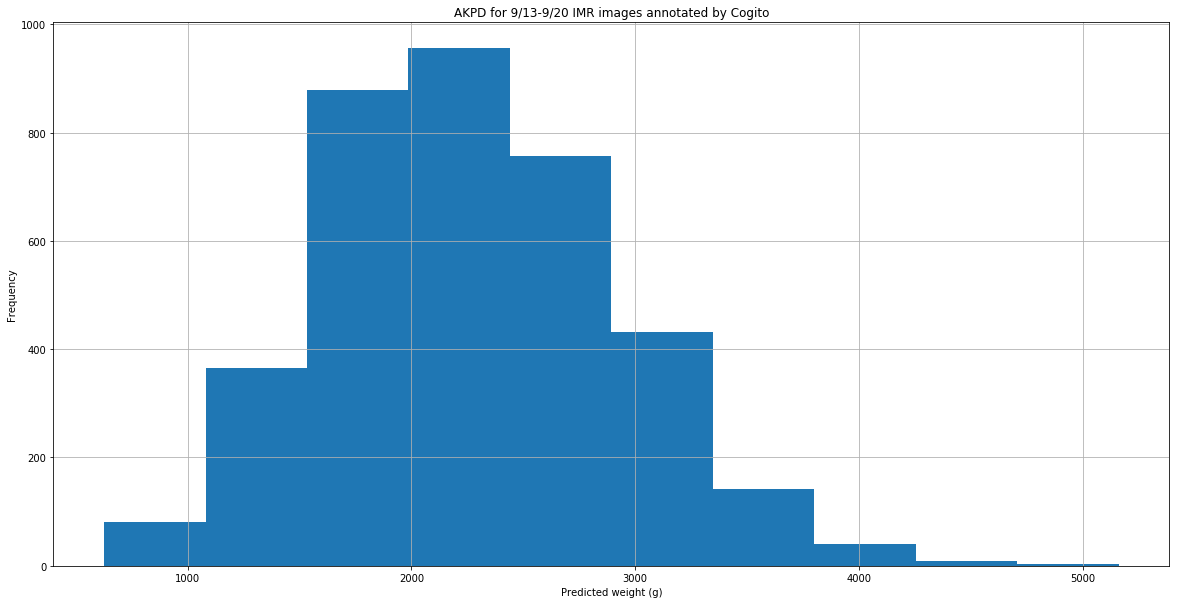

In [60]:
plt.figure(figsize=(20, 10))
plt.hist(wp[cs > 0.5])
plt.title('AKPD for 9/13-9/20 IMR images annotated by Cogito')
plt.xlabel('Predicted weight (g)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [57]:
np.mean(wp[cs > 0.5])

2261.8650970433587

In [58]:
np.median(wp[cs > 0.5])

2213.645428419113

In [64]:
(cs > 0.5).sum() / len(cs)

0.3746801760311125

In [61]:
(2261.8650970433587 - 2070) / 2070

0.09268845267795105

In [62]:
(2213.645428419113 - 2070) / 2070

0.06939392677251843